Simple test of app/pipeline.py in jupyter notebook.
This file made use of functions from app/pipeline.py, but I did a slight modifications. 
Most importantly, I often deleted "self" or "self." from the functions.

# Where should this jupyter notebook located?

In [1]:
%pwd

'/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion'

In [2]:
%ls -l

total 29032
drwxr-xr-x  15 kohei  staff      480 Jan 11 04:07 -mksamplefits_old/
-rw-r--r--   1 kohei  staff     1066 Jan  7 22:13 Dockerfile.build
-rw-r--r--   1 kohei  staff     3059 Jan  7 22:13 Jenkinsfile
-rw-r--r--   1 kohei  staff    13671 Jan  7 22:12 MANUAL.md
-rw-r--r--   1 kohei  staff     7272 Jan  7 22:13 README.md
-rw-r--r--   1 kohei  staff     1260 Jan  7 22:12 REFURBISHMENT.md
drwxr-xr-x  16 kohei  staff      512 Jan 13 15:19 app/
drwxr-xr-x  11 kohei  staff      352 Jan  7 22:13 common/
drwxr-xr-x   5 kohei  staff      160 Jan  7 22:12 config/
drwxr-xr-x   4 kohei  staff      128 Jan  7 22:13 doc/
drwxr-xr-x   7 kohei  staff      224 Jan 11 21:18 estimation/
drwxr-xr-x   8 kohei  staff      256 Jan 13 10:07 image/
drwxr-xr-x  16 kohei  staff      512 Jan 11 23:13 mksamplefits/
drwxr-xr-x  13 kohei  staff      416 Jan 11 23:28 mksamplefits2_static/
drwxr-xr-x  12 kohei  staff      384 Jan 12 05:48 mksamplefits3_single_star/
drwxr-xr-x   6 kohei  staff      192 Jan  7 2

In [3]:
%ls -l app/

total 200
-rw-r--r--  1 kohei  staff      0 Jan  7 22:13 __init__.py
drwxr-xr-x  7 kohei  staff    224 Jan 12 06:12 __pycache__/
-rw-r--r--@ 1 kohei  staff  15553 Jan 11 22:40 calculate_center_position.py
-rw-r--r--@ 1 kohei  staff   1393 Jan  7 22:13 calculate_star_position.py
-rw-r--r--  1 kohei  staff   6189 Jan  7 22:13 generate_image_data.py
-rw-r--r--  1 kohei  staff   4110 Jan  7 22:13 generate_star_center.py
-rw-r--r--@ 1 kohei  staff    519 Jan  7 22:13 pipeline.json
-rw-r--r--@ 1 kohei  staff  36919 Jan 11 23:12 pipeline.py
-rw-r--r--@ 1 kohei  staff    608 Jan 11 23:01 pipeline_stellar_motion_1.json
-rw-r--r--@ 1 kohei  staff    624 Jan 11 23:18 pipeline_stellar_motion_2_static.json
-rw-r--r--@ 1 kohei  staff    634 Jan 12 05:57 pipeline_stellar_motion_3.json
-rw-r--r--@ 1 kohei  staff    630 Jan 13 15:19 pipeline_stellar_motion_4.json
-rw-r--r--  1 kohei  staff   1251 Jan  7 22:13 reverse_calculation_of_psf.py


In [4]:
import argparse
import csv
import importlib
import pathlib
import sys
import os
import json

#sys.path.append('../../')#kohei
sys.path.append('../')#kohei
#sys.path.append(str(pathlib.Path(__file__).resolve().parent) + '/../')

from config.module import np_module
from common.logger import Logger
from common.listutil import ListUtil
from app.calculate_center_position import CenterCalculator
from image.large_frame_processor import LargeFrameProcessor
from image.distortion import MappedStarObservationsOnPlate, DistortionCalculator, DistortionParameters
from estimation.position import MappedStarObservations, PositionEstimation

np = importlib.import_module(np_module)

logger = Logger(__name__)

#kohei
import sys
from inspect import currentframe, getframeinfo
frameinfo = getframeinfo(currentframe())
#print(frameinfo.filename, frameinfo.lineno)


/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 10


In [5]:
from matplotlib import pyplot

# Read json file

In [6]:
f = open('/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/pipeline_stellar_motion_3.json')

In [7]:
%cat app/pipeline_stellar_motion_3.json

{
    "framecsvpath": "mksamplefits3_single_star/dataset/frames.csv",
    "outputdir": "outputdir_stellar_motion_3",
    "brighterthreshold": 20000,
    "darkerthreshold": 16000,
    "dpixel": 2.6E-06,
    "starimagesize": 9,
    "centeriteration": 20,
    "positioniteration": 20,
    "lighterstarsamerange": 20.0,
    "darkerstarsamerange": 4.0,
    "largeframesamerange": 4.0,
    "positiontosolve": 2,
    "xmagnification": 3,
    "ymagnification": 3,
    "knownstarspath": "mksamplefits3_single_star/dataset/known_stars.csv", "knownstarsneighborhood": 10.0,
    "plateparameterdimension": 5,
    "psfbrightnessthreshold": 2000
}


In [8]:
json_data = json.load(f)

In [9]:
frame_csv_path=json_data['framecsvpath']
output_directory=json_data['outputdir']
brighter_threshold=json_data['brighterthreshold']
darker_threshold=json_data['darkerthreshold']
dpixel=json_data['dpixel']
star_image_size=json_data['starimagesize']
lighter_star_same_range=json_data['lighterstarsamerange']
darker_star_same_range=json_data['darkerstarsamerange']
large_frame_same_range=json_data['largeframesamerange']
center_iteration=json_data['centeriteration']
x_magnification=json_data['xmagnification']
y_magnification=json_data['ymagnification']
position_to_solve=json_data['positiontosolve']
position_iteration=json_data['positioniteration']
known_stars_path=json_data['knownstarspath']
known_stars_neighborhood=json_data['knownstarsneighborhood']
plate_parameter_dimension=json_data['plateparameterdimension']
psf_brightness_threshold=json_data['psfbrightnessthreshold']

In [10]:
lighter_star_same_ecliptic_range = lighter_star_same_range * dpixel
known_stars_ecliptic_neighborhood = known_stars_neighborhood * dpixel
darker_star_same_ecliptic_range = darker_star_same_range * dpixel




In [11]:

class LargeFrameInfo:
    """
    Large frame information.
    """

    def __init__(self, csv_rows, csv_dir):
        """
        Initialize object.

        Parameters
        ----------
        csv_rows: list
            List of CSV rows
        csv_dir: str
            CSV file path
        """
        self.__directory = pathlib.Path(csv_dir).parent.joinpath(csv_rows[0])
        self.__time = float(csv_rows[1])
        self.__longitude = float(csv_rows[2])

    @property
    def directory(self):
        return str(self.__directory)

    @property
    def time(self):
        return self.__time

    @property
    def longitude(self):
        return self.__longitude

    def get_star_center_file_name(self):
        return 'center_' + self.__directory.resolve().name + '.csv'

    def get_plate_parameter_file_name(self):
        return 'plate_' + self.__directory.resolve().name + '.csv'

In [12]:
def __parse_frame_csv():
    """
    Load large frame information file.

    Returns
    -------
    large_frame_info_list: list
        List of LargeFrameInfo
    """
    with open(frame_csv_path) as fr:
        reader = csv.reader(fr)
        next(reader)
        return [LargeFrameInfo(r, frame_csv_path) for r in reader]
large_frame_info_list = __parse_frame_csv()

In [13]:
def __parse_known_stars_csv():
    """
    Parse known stars CSV file.

    Returns
    -------
    known_stars: np.array (2 order)
        List of (star id ( = -1), lambda, beta, mu lambda, mu beta, pi)
    """
    if os.path.exists(known_stars_path):
        with open(known_stars_path) as fr:
            reader = csv.reader(fr)
            next(reader)
            # element is (star id, lambda, beta, mu lambda, mu beta, pi)
            # -1 of star id means not mapped
            return np.array([[-1, float(r[0]), float(r[1]), float(r[2]), float(r[3]), float(r[4])] for r in reader])

    logger.warn('Known stars position file %s is not found.', known_stars_path[0])
    return np.array([])

known_star_params=__parse_known_stars_csv()

In [14]:

# parse each large frame
plate_id_offset = 1
all_star_data = []
star_id_lambda_beta_list = []
time_list = []
plate_data_list = []
c_plate_parameter_list = []
d_plate_parameter_list = []

In [15]:
for large_frame_info in large_frame_info_list:
    large_frame_info.directory
    print(large_frame_info.directory)
    print(large_frame_info.get_star_center_file_name())
    print(large_frame_info.get_plate_parameter_file_name())
    print(plate_id_offset)
    print(known_star_params)
    print(psf_brightness_threshold)

mksamplefits3_single_star/dataset/frame00000
center_frame00000.csv
plate_frame00000.csv
1
[[-1.00000000e+00  4.64687383e+00 -9.55758431e-02  3.85391903e-05
   3.52756613e-05  3.65979487e-05]
 [-1.00000000e+00  4.65138149e+00 -9.01716796e-02  2.66450707e-05
   4.00768546e-06  2.27972941e-05]
 [-1.00000000e+00  4.64534257e+00 -8.80898088e-02  4.73539003e-05
   1.67675388e-05  1.54702965e-05]
 ...
 [-1.00000000e+00  4.64875331e+00 -9.97288602e-02  2.85312099e-05
   9.04468392e-06  4.98054343e-05]
 [-1.00000000e+00  4.64483656e+00 -9.57740472e-02  1.04299233e-05
   9.43017529e-06  4.07493527e-05]
 [-1.00000000e+00  4.65750332e+00 -1.02507554e-01  2.07930334e-05
   3.95266103e-05  4.28359871e-05]]
2000
mksamplefits3_single_star/dataset/frame00001
center_frame00001.csv
plate_frame00001.csv
1
[[-1.00000000e+00  4.64687383e+00 -9.55758431e-02  3.85391903e-05
   3.52756613e-05  3.65979487e-05]
 [-1.00000000e+00  4.65138149e+00 -9.01716796e-02  2.66450707e-05
   4.00768546e-06  2.27972941e-05]
 

In [16]:
def estimate_center_from_one_large_frame(directory, output_center_csv_name, output_plate_csv_name, plate_id_offset, known_star_params, psf_brightness_threshold):
    
    large_frame_processor = LargeFrameProcessor(
            plate_id_offset=plate_id_offset,
            directory=directory,
            dpixel=dpixel,
            star_image_size=star_image_size
    )
    print(psf_brightness_threshold)
    

    center_calculator = CenterCalculator(
        center_iteration=center_iteration[0],
        x_magnification=x_magnification[0],
        y_magnification=y_magnification[0],
        max_iteration=center_iteration[0],
        psf_brightness_threshold=psf_brightness_threshold
    )
    print(lighter_star_same_ecliptic_range)
    print(brighter_threshold[0])
    
    brighter_star_position_in_pixel, extracted_brighter_star_image_list = \
    large_frame_processor.execute(
            same_star_ecliptic_range=lighter_star_same_ecliptic_range,
            binary_threshold=brighter_threshold
    )
    
    return \
    brighter_star_position_in_pixel, \
    extracted_brighter_star_image_list

# Have a detailed look at the first element of large_frame_info_list

In [17]:
large_frame_info = large_frame_info_list[0]

In [18]:
large_frame_info.directory

'mksamplefits3_single_star/dataset/frame00000'

In [19]:
directory, output_center_csv_name, output_plate_csv_name, plate_id_offset, known_star_params, psf_brightness_threshold = \
large_frame_info.directory, \
large_frame_info.get_star_center_file_name(), \
large_frame_info.get_plate_parameter_file_name(), \
plate_id_offset, \
known_star_params, \
psf_brightness_threshold
    
large_frame_processor = LargeFrameProcessor(
            plate_id_offset=plate_id_offset,
            directory=directory,
            dpixel=dpixel,
            star_image_size=star_image_size
)
print(psf_brightness_threshold)
    

center_calculator = CenterCalculator(
        center_iteration=center_iteration,
        x_magnification=x_magnification,
        y_magnification=y_magnification,
        max_iteration=center_iteration,
        psf_brightness_threshold=psf_brightness_threshold
)
print(lighter_star_same_ecliptic_range)
print(brighter_threshold)
    
brighter_star_position_in_pixel, extracted_brighter_star_image_list = \
large_frame_processor.execute(
            same_star_ecliptic_range=lighter_star_same_ecliptic_range,
            binary_threshold=brighter_threshold
)
    


2000
5.2000000000000004e-05
20000


2021-01-14 12:39:19,347  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate000.fits" with binary threshold 20000.
2021-01-14 12:39:19,567  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate001.fits" with binary threshold 20000.
2021-01-14 12:39:19,794  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate002.fits" with binary threshold 20000.
2021-01-14 12:39:20,020  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate003.fits" with binary threshold 20000.
2021-01-14 12:39:20,246  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate004.fits" with binary threshold 20000.
2021-01-14 12:39:20,482  INFO  image.large_frame_processor : 11 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate0

In [20]:
# estimate center position for brighter stars
brighter_star_position_in_pixel = brighter_star_position_in_pixel[:, [0, 1, 4, 5]]
        

In [21]:
brighter_star_position_in_pixel

array([[1.000e+00, 1.000e+00, 3.960e+02, 1.005e+03],
       [1.000e+00, 2.000e+00, 4.520e+02, 9.230e+02],
       [1.000e+00, 3.000e+00, 3.570e+02, 8.730e+02],
       [1.000e+00, 4.000e+00, 8.350e+02, 6.790e+02],
       [1.000e+00, 5.000e+00, 4.930e+02, 6.750e+02],
       [1.000e+00, 6.000e+00, 3.680e+02, 6.560e+02],
       [1.000e+00, 7.000e+00, 5.210e+02, 6.200e+02],
       [1.000e+00, 8.000e+00, 8.350e+02, 3.480e+02],
       [1.000e+00, 9.000e+00, 3.490e+02, 2.120e+02],
       [1.000e+00, 1.000e+01, 2.730e+02, 1.900e+02],
       [2.000e+00, 1.000e+00, 4.560e+02, 9.980e+02],
       [2.000e+00, 2.000e+00, 5.120e+02, 9.160e+02],
       [2.000e+00, 4.000e+00, 8.940e+02, 6.730e+02],
       [2.000e+00, 5.000e+00, 5.530e+02, 6.690e+02],
       [2.000e+00, 6.000e+00, 4.280e+02, 6.500e+02],
       [2.000e+00, 7.000e+00, 5.810e+02, 6.130e+02],
       [2.000e+00, 1.100e+01, 3.390e+02, 4.740e+02],
       [2.000e+00, 8.000e+00, 8.950e+02, 3.420e+02],
       [2.000e+00, 9.000e+00, 4.090e+02, 2.050

## The following cell takes 3 minutes...

In [22]:
star_pixel_position_with_errors, psf_coefficient = center_calculator.execute(
            star_positions_in_pixel=brighter_star_position_in_pixel,
            all_extracted_star_images=extracted_brighter_star_image_list
)

2021-01-14 12:39:24,030  INFO  app.calculate_center_position : Calculation of center coordinates is stared. plates=6, stars=11, star images=61
2021-01-14 12:39:24,031  INFO  app.calculate_center_position : Calculate the tentative center position using a Gaussian function.
2021-01-14 12:39:24,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1038.618120)
2021-01-14 12:39:24,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 7644.716014)
2021-01-14 12:39:24,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 625.935419)
2021-01-14 12:39:24,043  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.667536)
2021-01-14 12:39:24,045  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.030323)
2021-01-14 12:39:24,048  DEBUG  common.leastsquare : Solving with least square calculation (iterati

2021-01-14 12:39:24,175  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 1.800230)
2021-01-14 12:39:24,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.014800)
2021-01-14 12:39:24,179  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000232)
2021-01-14 12:39:24,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000827)
2021-01-14 12:39:24,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000431)
2021-01-14 12:39:24,184  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000738)
2021-01-14 12:39:24,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001473)
2021-01-14 12:39:24,188  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000476)
2021-

before_center_positions []


2021-01-14 12:39:24,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000487)
2021-01-14 12:39:24,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000614)
2021-01-14 12:39:24,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000015)
2021-01-14 12:39:24,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000806)
2021-01-14 12:39:24,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000022)
2021-01-14 12:39:24,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000710)
2021-01-14 12:39:24,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000578)
2021-01-14 12:39:24,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1267.378045

2021-01-14 12:39:24,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001210)
2021-01-14 12:39:24,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1781.777571)
2021-01-14 12:39:24,375  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 12411.983532)
2021-01-14 12:39:24,377  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 668.748105)
2021-01-14 12:39:24,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 1.458444)
2021-01-14 12:39:24,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005768)
2021-01-14 12:39:24,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002257)
2021-01-14 12:39:24,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001187

2021-01-14 12:39:24,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002951)
2021-01-14 12:39:24,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001021)
2021-01-14 12:39:24,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000225)
2021-01-14 12:39:24,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000133)
2021-01-14 12:39:24,516  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000871)
2021-01-14 12:39:24,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001536)
2021-01-14 12:39:24,521  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000094)
2021-01-14 12:39:24,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000748)
2021

2021-01-14 12:39:24,660  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000519)
2021-01-14 12:39:24,662  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000931)
2021-01-14 12:39:24,664  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000046)
2021-01-14 12:39:24,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000719)
2021-01-14 12:39:24,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001916)
2021-01-14 12:39:24,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001498)
2021-01-14 12:39:24,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000011)
2021-01-14 12:39:24,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000209)


2021-01-14 12:39:24,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000064)
2021-01-14 12:39:24,806  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.001597)
2021-01-14 12:39:24,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000480)
2021-01-14 12:39:24,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1638.063163)
2021-01-14 12:39:24,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 7517.045517)
2021-01-14 12:39:24,813  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 269.944961)
2021-01-14 12:39:24,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.631513)
2021-01-14 12:39:24,818  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.00621

2021-01-14 12:39:24,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 141.642261)
2021-01-14 12:39:24,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 4.528434)
2021-01-14 12:39:24,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.102191)
2021-01-14 12:39:24,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.003422)
2021-01-14 12:39:24,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000743)
2021-01-14 12:39:24,950  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001081)
2021-01-14 12:39:24,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000459)
2021-01-14 12:39:24,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000643)
2021

2021-01-14 12:39:25,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000194)
2021-01-14 12:39:25,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000874)
2021-01-14 12:39:25,081  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.001108)
2021-01-14 12:39:25,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000073)
2021-01-14 12:39:25,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000151)
2021-01-14 12:39:25,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000462)
2021-01-14 12:39:25,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001367)
2021-01-14 12:39:25,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001017)


2021-01-14 12:39:25,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000106)
2021-01-14 12:39:25,218  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000712)
2021-01-14 12:39:25,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000122)
2021-01-14 12:39:25,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000429)
2021-01-14 12:39:25,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001077)
2021-01-14 12:39:25,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1630.899021)
2021-01-14 12:39:25,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 5527.331069)
2021-01-14 12:39:25,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 157.758

2021-01-14 12:39:25,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 7382.469622)
2021-01-14 12:39:25,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 746.925058)
2021-01-14 12:39:25,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 1.280585)
2021-01-14 12:39:25,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.036888)
2021-01-14 12:39:25,363  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001911)
2021-01-14 12:39:25,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000069)
2021-01-14 12:39:25,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000479)
2021-01-14 12:39:25,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001268)
202

2021-01-14 12:39:25,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000201)
2021-01-14 12:39:25,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000845)
2021-01-14 12:39:25,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000548)
2021-01-14 12:39:25,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000119)
2021-01-14 12:39:25,506  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000051)
2021-01-14 12:39:25,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000130)
2021-01-14 12:39:25,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000411)
2021-01-14 12:39:25,512  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000033)
20

2021-01-14 12:39:25,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000647)
2021-01-14 12:39:25,642  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000108)
2021-01-14 12:39:25,645  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001512)
2021-01-14 12:39:25,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000255)
2021-01-14 12:39:25,649  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.001947)
2021-01-14 12:39:25,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000518)
2021-01-14 12:39:25,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001681)
2021-01-14 12:39:25,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1643.316118

2021-01-14 12:39:25,788  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.001223)
2021-01-14 12:39:25,791  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001730)
2021-01-14 12:39:25,794  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 914.545381)
2021-01-14 12:39:25,795  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 7981.482650)
2021-01-14 12:39:25,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 883.692327)
2021-01-14 12:39:25,799  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 3.380882)
2021-01-14 12:39:25,801  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.054549)
2021-01-14 12:39:25,803  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001099)

2021-01-14 12:39:25,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009413)
2021-01-14 12:39:25,931  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000810)
2021-01-14 12:39:25,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000229)
2021-01-14 12:39:25,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000056)
2021-01-14 12:39:25,937  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000027)
2021-01-14 12:39:25,939  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000818)
2021-01-14 12:39:25,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000777)
2021-01-14 12:39:25,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000076)
2021-

2021-01-14 12:39:26,074  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000842)
2021-01-14 12:39:26,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000329)
2021-01-14 12:39:26,078  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000317)
2021-01-14 12:39:26,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000233)
2021-01-14 12:39:26,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002033)
2021-01-14 12:39:26,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001223)
2021-01-14 12:39:26,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000331)
2021-01-14 12:39:26,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000233)


2021-01-14 12:39:26,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001703)
2021-01-14 12:39:26,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.001171)
2021-01-14 12:39:26,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000111)
2021-01-14 12:39:26,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001280)
2021-01-14 12:39:26,223  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 967.090659)
2021-01-14 12:39:26,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 9273.449584)
2021-01-14 12:39:26,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 1278.797340)
2021-01-14 12:39:26,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 10.197

2021-01-14 12:39:26,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 479.547617)
2021-01-14 12:39:26,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.303308)
2021-01-14 12:39:26,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008875)
2021-01-14 12:39:26,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000140)
2021-01-14 12:39:26,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000042)
2021-01-14 12:39:26,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000434)
2021-01-14 12:39:26,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000180)
2021-01-14 12:39:26,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000084)
2021-

2021-01-14 12:39:26,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000133)
2021-01-14 12:39:26,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000331)
2021-01-14 12:39:26,495  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000362)
2021-01-14 12:39:26,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000169)
2021-01-14 12:39:26,499  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000324)
2021-01-14 12:39:26,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000625)
2021-01-14 12:39:26,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000484)
2021-01-14 12:39:26,506  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000199)
2

2021-01-14 12:39:26,626  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001315)
2021-01-14 12:39:26,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000588)
2021-01-14 12:39:26,630  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000111)
2021-01-14 12:39:26,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000700)
2021-01-14 12:39:26,634  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.001626)
2021-01-14 12:39:26,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001116)
2021-01-14 12:39:26,671  INFO  app.calculate_center_position : Iteration 1 of 20 for calculating star center...
2021-01-14 12:39:26,680  DEBUG  app.calculate_center_position : Size of all pixel data -> 4941
2021-01-14 12:39:26,690  INFO  app.calculat

# use a Gaussian function to calculate a temporary center position.
0 [-0.38074586 -0.04904188] 71456.33470907071 0.569700099159365
1 [-0.49862608 -0.33316875] 57886.47771397675 0.5716828489374705
2 [ 0.12381206 -0.21391947] 24519.364774550824 0.5771123179235994
3 [ 0.30792393 -0.49570096] 142758.38234220585 0.5686924324446994
4 [ 0.15673018 -0.10454981] 48965.95914770587 0.5723782106771769
5 [ 0.25938695 -0.06558279] 101732.68095173036 0.5691323863459141
6 [-0.45879287  0.42446456] 91064.05234878414 0.5700705041053895
7 [ 0.20971018 -0.07421378] 105573.02700457948 0.5697157922352917
8 [-0.22754931  0.24525232] 138768.42007233176 0.5691468807521535
9 [-0.46639992 -0.09597915] 114913.41179648039 0.5690748942206035
10 [ 0.04833621 -0.14889526] 71096.64769839986 0.5705674910109536
11 [-0.06768029 -0.4242469 ] 58308.05184983003 0.570229511478885
12 [-0.2657423   0.40896168] 142543.52755766627 0.5689879543380006
13 [-0.41640871 -0.19369964] 49006.5998736965 0.5722677955017135
14 [-0.3096257

-4.15673 1.1045498 471.0 1 16
-4.15673 2.10455 458.0 1 19
-4.15673 3.10455 437.0 1 22
-4.15673 4.10455 445.0 1 25
-3.1567302 -3.89545 471.0 4 1
-3.1567302 -2.89545 462.0 4 4
-3.1567302 -1.8954502 436.0 4 7
-3.1567302 -0.8954502 477.0 4 10
-3.1567302 0.10454981 471.0 4 13
-3.1567302 1.1045498 446.0 4 16
-3.1567302 2.10455 444.0 4 19
-3.1567302 3.10455 470.0 4 22
-3.1567302 4.10455 449.0 4 25
-2.1567302 -3.89545 455.0 7 1
-2.1567302 -2.89545 441.0 7 4
-2.1567302 -1.8954502 564.0 7 7
-2.1567302 -0.8954502 1140.0 7 10
-2.1567302 0.10454981 1744.0 7 13
-2.1567302 1.1045498 1024.0 7 16
-2.1567302 2.10455 507.0 7 19
-2.1567302 3.10455 455.0 7 22
-2.1567302 4.10455 441.0 7 25
-1.1567302 -3.89545 452.0 10 1
-1.1567302 -2.89545 469.0 10 4
-1.1567302 -1.8954502 1532.0 10 7
-1.1567302 -0.8954502 9892.0 10 10
-1.1567302 0.10454981 17945.0 10 13
-1.1567302 1.1045498 7341.0 10 16
-1.1567302 2.10455 1054.0 10 19
-1.1567302 3.10455 475.0 10 22
-1.1567302 4.10455 454.0 10 25
-0.15673018 -3.89545 457.0 1

-0.9323197 1.4242469 6542.0 10 17
-0.9323197 2.4242468 783.0 10 20
-0.9323197 3.4242468 467.0 10 23
-0.9323197 4.424247 439.0 10 26
0.06768029 -3.5757532 448.0 13 2
0.06768029 -2.5757532 767.0 13 5
0.06768029 -1.5757531 9027.0 13 8
0.06768029 -0.5757531 45282.0 13 11
0.06768029 0.4242469 51104.0 13 14
0.06768029 1.4242469 12571.0 13 17
0.06768029 2.4242468 1017.0 13 20
0.06768029 3.4242468 473.0 13 23
0.06768029 4.424247 445.0 13 26
1.0676802 -3.5757532 459.0 16 2
1.0676802 -2.5757532 606.0 16 5
1.0676802 -1.5757531 4139.0 16 8
1.0676802 -0.5757531 19045.0 16 11
1.0676802 0.4242469 21212.0 16 14
1.0676802 1.4242469 5384.0 16 17
1.0676802 2.4242468 699.0 16 20
1.0676802 3.4242468 450.0 16 23
1.0676802 4.424247 468.0 16 26
2.0676804 -3.5757532 468.0 19 2
2.0676804 -2.5757532 482.0 19 5
2.0676804 -1.5757531 782.0 19 8
2.0676804 -0.5757531 2094.0 19 11
2.0676804 0.4242469 2323.0 19 14
2.0676804 1.4242469 882.0 19 17
2.0676804 2.4242468 485.0 19 20
2.0676804 3.4242468 447.0 19 23
2.0676804 

4.363679 -3.83128 441.0 26 2
4.363679 -2.83128 463.0 26 5
4.363679 -1.83128 470.0 26 8
4.363679 -0.83128 448.0 26 11
4.363679 0.16871999 458.0 26 14
4.363679 1.16872 459.0 26 17
4.363679 2.16872 447.0 26 20
4.363679 3.16872 454.0 26 23
4.363679 4.16872 456.0 26 26
-4.1967006 -4.1495414 459.0 0 1
-4.1967006 -3.1495414 470.0 0 4
-4.1967006 -2.1495414 469.0 0 7
-4.1967006 -1.1495414 442.0 0 10
-4.1967006 -0.14954141 446.0 0 13
-4.1967006 0.85045856 437.0 0 16
-4.1967006 1.8504586 456.0 0 19
-4.1967006 2.8504586 435.0 0 22
-4.1967006 3.8504586 444.0 0 25
-3.1967003 -4.1495414 437.0 3 1
-3.1967003 -3.1495414 457.0 3 4
-3.1967003 -2.1495414 454.0 3 7
-3.1967003 -1.1495414 490.0 3 10
-3.1967003 -0.14954141 487.0 3 13
-3.1967003 0.85045856 484.0 3 16
-3.1967003 1.8504586 440.0 3 19
-3.1967003 2.8504586 471.0 3 22
-3.1967003 3.8504586 455.0 3 25
-2.1967003 -4.1495414 445.0 6 1
-2.1967003 -3.1495414 470.0 6 4
-2.1967003 -2.1495414 554.0 6 7
-2.1967003 -1.1495414 1629.0 6 10
-2.1967003 -0.1495414

3.801852 3.262472 435.0 24 23
3.801852 4.2624717 459.0 24 26
-4.298656 -3.7682054 447.0 0 2
-4.298656 -2.7682054 468.0 0 5
-4.298656 -1.7682054 465.0 0 8
-4.298656 -0.76820546 465.0 0 11
-4.298656 0.23179454 448.0 0 14
-4.298656 1.2317946 458.0 0 17
-4.298656 2.2317946 467.0 0 20
-4.298656 3.2317946 448.0 0 23
-4.298656 4.2317944 465.0 0 26
-3.2986562 -3.7682054 460.0 3 2
-3.2986562 -2.7682054 443.0 3 5
-3.2986562 -1.7682054 445.0 3 8
-3.2986562 -0.76820546 451.0 3 11
-3.2986562 0.23179454 477.0 3 14
-3.2986562 1.2317946 471.0 3 17
-3.2986562 2.2317946 466.0 3 20
-3.2986562 3.2317946 470.0 3 23
-3.2986562 4.2317944 461.0 3 26
-2.2986562 -3.7682054 446.0 6 2
-2.2986562 -2.7682054 474.0 6 5
-2.2986562 -1.7682054 588.0 6 8
-2.2986562 -0.76820546 1456.0 6 11
-2.2986562 0.23179454 2005.0 6 14
-2.2986562 1.2317946 967.0 6 17
-2.2986562 2.2317946 475.0 6 20
-2.2986562 3.2317946 461.0 6 23
-2.2986562 4.2317944 463.0 6 26
-1.2986561 -3.7682054 443.0 9 2
-1.2986561 -2.7682054 508.0 9 5
-1.298656

-2.6235273 -1.2148618 547.0 5 9
-2.6235273 -0.2148618 704.0 5 12
-2.6235273 0.7851382 637.0 5 15
-2.6235273 1.7851382 487.0 5 18
-2.6235273 2.7851381 444.0 5 21
-2.6235273 3.7851381 436.0 5 24
-1.6235272 -4.214862 435.0 8 0
-1.6235272 -3.2148619 451.0 8 3
-1.6235272 -2.2148619 627.0 8 6
-1.6235272 -1.2148618 2970.0 8 9
-1.6235272 -0.2148618 7813.0 8 12
-1.6235272 0.7851382 5158.0 8 15
-1.6235272 1.7851382 1113.0 8 18
-1.6235272 2.7851381 454.0 8 21
-1.6235272 3.7851381 438.0 8 24
-0.6235272 -4.214862 468.0 11 0
-0.6235272 -3.2148619 455.0 11 3
-0.6235272 -2.2148619 1392.0 11 6
-0.6235272 -1.2148618 14379.0 11 9
-0.6235272 -0.2148618 41647.0 11 12
-0.6235272 0.7851382 27246.0 11 15
-0.6235272 1.7851382 4208.0 11 18
-0.6235272 2.7851381 567.0 11 21
-0.6235272 3.7851381 443.0 11 24
0.3764728 -4.214862 442.0 14 0
0.3764728 -3.2148619 477.0 14 3
0.3764728 -2.2148619 1585.0 14 6
0.3764728 -1.2148618 17005.0 14 9
0.3764728 -0.2148618 50530.0 14 12
0.3764728 0.7851382 32670.0 14 15
0.3764728 1

-0.32340375 3.523705 451.0 12 24
0.6765963 -4.476295 460.0 15 0
0.6765963 -3.476295 469.0 15 3
0.6765963 -2.476295 1066.0 15 6
0.6765963 -1.4762949 14471.0 15 9
0.6765963 -0.4762949 62889.0 15 12
0.6765963 0.5237051 60787.0 15 15
0.6765963 1.5237051 12884.0 15 18
0.6765963 2.523705 937.0 15 21
0.6765963 3.523705 457.0 15 24
1.6765963 -4.476295 438.0 18 0
1.6765963 -3.476295 450.0 18 3
1.6765963 -2.476295 536.0 18 6
1.6765963 -1.4762949 2676.0 18 9
1.6765963 -0.4762949 10621.0 18 12
1.6765963 0.5237051 10130.0 18 15
1.6765963 1.5237051 2485.0 18 18
1.6765963 2.523705 517.0 18 21
1.6765963 3.523705 466.0 18 24
2.6765962 -4.476295 467.0 21 0
2.6765962 -3.476295 438.0 21 3
2.6765962 -2.476295 456.0 21 6
2.6765962 -1.4762949 530.0 21 9
2.6765962 -0.4762949 780.0 21 12
2.6765962 0.5237051 773.0 21 15
2.6765962 1.5237051 526.0 21 18
2.6765962 2.523705 472.0 21 21
2.6765962 3.523705 466.0 21 24
3.6765962 -4.476295 462.0 24 0
3.6765962 -3.476295 442.0 24 3
3.6765962 -2.476295 448.0 24 6
3.67659

-4.2998147 0.04758667 435.0 0 13
-4.2998147 1.0475867 446.0 0 16
-4.2998147 2.0475867 469.0 0 19
-4.2998147 3.0475867 446.0 0 22
-4.2998147 4.0475864 442.0 0 25
-3.2998145 -3.9524133 454.0 3 1
-3.2998145 -2.9524133 455.0 3 4
-3.2998145 -1.9524133 466.0 3 7
-3.2998145 -0.9524133 466.0 3 10
-3.2998145 0.04758667 463.0 3 13
-3.2998145 1.0475867 466.0 3 16
-3.2998145 2.0475867 457.0 3 19
-3.2998145 3.0475867 458.0 3 22
-3.2998145 4.0475864 452.0 3 25
-2.2998145 -3.9524133 441.0 6 1
-2.2998145 -2.9524133 466.0 6 4
-2.2998145 -1.9524133 497.0 6 7
-2.2998145 -0.9524133 820.0 6 10
-2.2998145 0.04758667 1263.0 6 13
-2.2998145 1.0475867 822.0 6 16
-2.2998145 2.0475867 460.0 6 19
-2.2998145 3.0475867 440.0 6 22
-2.2998145 4.0475864 441.0 6 25
-1.2998145 -3.9524133 468.0 9 1
-1.2998145 -2.9524133 475.0 9 4
-1.2998145 -1.9524133 1154.0 9 7
-1.2998145 -0.9524133 7092.0 9 10
-1.2998145 0.04758667 13942.0 9 13
-1.2998145 1.0475867 6165.0 9 16
-1.2998145 2.0475867 959.0 9 19
-1.2998145 3.0475867 449.0 

1.3227353 -0.96023744 15477.0 17 10
1.3227353 0.039762545 30238.0 17 13
1.3227353 1.0397625 13510.0 17 16
1.3227353 2.0397625 1572.0 17 19
1.3227353 3.0397625 463.0 17 22
1.3227353 4.0397625 456.0 17 25
2.3227353 -3.9602375 460.0 20 1
2.3227353 -2.9602375 451.0 20 4
2.3227353 -1.9602375 543.0 20 7
2.3227353 -0.96023744 1337.0 20 10
2.3227353 0.039762545 2167.0 20 13
2.3227353 1.0397625 1280.0 20 16
2.3227353 2.0397625 500.0 20 19
2.3227353 3.0397625 441.0 20 22
2.3227353 4.0397625 469.0 20 25
3.3227353 -3.9602375 446.0 23 1
3.3227353 -2.9602375 453.0 23 4
3.3227353 -1.9602375 445.0 23 7
3.3227353 -0.96023744 449.0 23 10
3.3227353 0.039762545 464.0 23 13
3.3227353 1.0397625 465.0 23 16
3.3227353 2.0397625 445.0 23 19
3.3227353 3.0397625 460.0 23 22
3.3227353 4.0397625 448.0 23 25
4.3227353 -3.9602375 459.0 26 1
4.3227353 -2.9602375 447.0 26 4
4.3227353 -1.9602375 471.0 26 7
4.3227353 -0.96023744 438.0 26 10
4.3227353 0.039762545 439.0 26 13
4.3227353 1.0397625 440.0 26 16
4.3227353 2.03

-0.8249709 -3.7578988 467.0 11 2
-0.8249709 -2.7578988 603.0 11 5
-0.8249709 -1.7578988 5999.0 11 8
-0.8249709 -0.75789875 39260.0 11 11
-0.8249709 0.24210124 57971.0 11 14
-0.8249709 1.2421012 18884.0 11 17
-0.8249709 2.2421012 1661.0 11 20
-0.8249709 3.2421012 466.0 11 23
-0.8249709 4.242101 438.0 11 26
0.1750291 -3.7578988 461.0 14 2
0.1750291 -2.7578988 708.0 14 5
0.1750291 -1.7578988 9523.0 14 8
0.1750291 -0.75789875 64141.0 14 11
0.1750291 0.24210124 95103.0 14 14
0.1750291 1.2421012 30654.0 14 17
0.1750291 2.2421012 2467.0 14 20
0.1750291 3.2421012 490.0 14 23
0.1750291 4.242101 443.0 14 26
1.175029 -3.7578988 454.0 17 2
1.175029 -2.7578988 514.0 17 5
1.175029 -1.7578988 3638.0 17 8
1.175029 -0.75789875 23137.0 17 11
1.175029 0.24210124 34022.0 17 14
1.175029 1.2421012 11125.0 17 17
1.175029 2.2421012 1139.0 17 20
1.175029 3.2421012 448.0 17 23
1.175029 4.242101 451.0 17 26
2.175029 -3.7578988 457.0 20 2
2.175029 -2.7578988 443.0 20 5
2.175029 -1.7578988 691.0 20 8
2.175029 -0.7

2021-01-14 12:39:32,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 184005.214510)
2021-01-14 12:39:32,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:39:33,269  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:39:33,301  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:39:33,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.276113)
2021-01-14 12:39:33,308  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.124495)
2021-01-14 12:39:33,312  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.012104)
2021-01-14 12:39:33,315  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.013046)
2021-01-14 12:39:33,319  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:39:33,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.386810)
2021-01-14 12:39:33,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.387964)
2021-01-14 12:39:33,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.390806)
2021-01-14 12:39:33,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.389775)
2021-01-14 12:39:33,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.387234)
2021-01-14 12:39:33,522  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.447990)
2021-01-14 12:39:33,525  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.333195)
2021-01-14 12:39:33,529  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.547734)
202

2021-01-14 12:39:33,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:39:33,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:39:33,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:39:33,760  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:39:33,764  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.259140)
2021-01-14 12:39:33,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.111308)
2021-01-14 12:39:33,771  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.042393)
2021-01-14 12:39:33,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012391)
2021-

2021-01-14 12:39:33,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000232)
2021-01-14 12:39:34,000  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000004)
2021-01-14 12:39:34,003  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:39:34,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:39:34,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:39:34,014  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.321846)
2021-01-14 12:39:34,018  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.076323)
2021-01-14 12:39:34,022  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.027528)
2021-01-

2021-01-14 12:39:34,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.121770)
2021-01-14 12:39:34,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010091)
2021-01-14 12:39:34,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002834)
2021-01-14 12:39:34,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000891)
2021-01-14 12:39:34,255  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000288)
2021-01-14 12:39:34,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000093)
2021-01-14 12:39:34,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000030)
2021-01-14 12:39:34,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000010)
2021-01-

2021-01-14 12:39:34,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000022)
2021-01-14 12:39:34,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000008)
2021-01-14 12:39:34,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-14 12:39:34,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:39:34,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:39:34,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:39:34,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:39:34,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-14 12:39:34,743  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000051)
2021-01-14 12:39:34,747  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000031)
2021-01-14 12:39:34,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000019)
2021-01-14 12:39:34,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000012)
2021-01-14 12:39:34,758  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000007)
2021-01-14 12:39:34,762  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.400934)
2021-01-14 12:39:34,766  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.016621)
2021-01-14 12:39:34,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.030828)
202

2021-01-14 12:39:34,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.152353)
2021-01-14 12:39:34,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.191350)
2021-01-14 12:39:34,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.191270)
2021-01-14 12:39:35,001  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.181492)
2021-01-14 12:39:35,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.184571)
2021-01-14 12:39:35,009  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.183794)
2021-01-14 12:39:35,012  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.184300)
2021-01-14 12:39:35,016  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.184111)
2021-01-

2021-01-14 12:39:35,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001714)
2021-01-14 12:39:35,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001055)
2021-01-14 12:39:35,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000645)
2021-01-14 12:39:35,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000394)
2021-01-14 12:39:35,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000241)
2021-01-14 12:39:35,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000147)
2021-01-14 12:39:35,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000089)
2021-01-14 12:39:35,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000054)
20

2021-01-14 12:39:35,487  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.048323)
2021-01-14 12:39:35,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.047273)
2021-01-14 12:39:35,495  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.046080)
2021-01-14 12:39:35,499  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.045216)
2021-01-14 12:39:35,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.044232)
2021-01-14 12:39:35,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.043504)
2021-01-14 12:39:35,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.042672)
2021-01-14 12:39:35,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.252788)
2

2021-01-14 12:39:35,746  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.316282)
2021-01-14 12:39:35,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.248694)
2021-01-14 12:39:35,753  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.121756)
2021-01-14 12:39:35,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.139771)
2021-01-14 12:39:35,760  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.148552)
2021-01-14 12:39:35,763  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.186434)
2021-01-14 12:39:35,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.282974)
2021-01-14 12:39:35,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.234328)
2021-01

2021-01-14 12:39:36,003  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000004)
2021-01-14 12:39:36,008  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000002)
2021-01-14 12:39:36,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000001)
2021-01-14 12:39:36,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.302943)
2021-01-14 12:39:36,019  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.628267)
2021-01-14 12:39:36,023  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.399377)
2021-01-14 12:39:36,027  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.652542)
2021-01-14 12:39:36,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.209381)
2021-

2021-01-14 12:39:36,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.117927)
2021-01-14 12:39:36,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.118688)
2021-01-14 12:39:36,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.130445)
2021-01-14 12:39:36,274  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.129648)
2021-01-14 12:39:36,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.118546)
2021-01-14 12:39:36,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.119132)
2021-01-14 12:39:36,284  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.130049)
2021-01-14 12:39:36,288  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.129307)
2021-0

2021-01-14 12:39:36,524  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.148287)
2021-01-14 12:39:36,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.220716)
2021-01-14 12:39:36,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.282540)
2021-01-14 12:39:36,536  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.223410)
2021-01-14 12:39:36,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.148835)
2021-01-14 12:39:36,543  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.220755)
2021-01-14 12:39:36,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.282246)
2021-01-14 12:39:36,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.223394)


2021-01-14 12:39:36,773  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.027788)
2021-01-14 12:39:36,776  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.010770)
2021-01-14 12:39:36,780  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.004308)
2021-01-14 12:39:36,785  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001724)
2021-01-14 12:39:36,790  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000691)
2021-01-14 12:39:36,795  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000277)
2021-01-14 12:39:36,799  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000111)
2021-01-14 12:39:36,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000045)
2021-

2021-01-14 12:39:37,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.503879)
2021-01-14 12:39:37,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.302522)
2021-01-14 12:39:37,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.259075)
2021-01-14 12:39:37,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.240577)
2021-01-14 12:39:37,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.228921)
2021-01-14 12:39:37,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.240694)
2021-01-14 12:39:37,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.251877)
2021-01-14 12:39:37,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.240237)
2021-01

2021-01-14 12:39:37,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000060)
2021-01-14 12:39:37,377  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000025)
2021-01-14 12:39:37,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000011)
2021-01-14 12:39:37,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000005)
2021-01-14 12:39:37,389  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000002)
2021-01-14 12:39:37,393  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
2021-01-14 12:39:37,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:39:37,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-14 12:39:37,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.329066)
2021-01-14 12:39:37,638  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.287974)
2021-01-14 12:39:37,641  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.309520)
2021-01-14 12:39:37,645  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.349365)
2021-01-14 12:39:37,649  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.328661)
2021-01-14 12:39:37,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.290385)
2021-01-14 12:39:37,657  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.149815)
2021-01-14 12:39:37,662  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.131938)
20

 
center_positions [array([-0.33226929, -0.23309771]), array([-0.53101864, -0.36521098]), array([ 0.12286636, -0.16461543]), array([ 0.38814486, -0.91627923]), array([ 0.12747636, -0.15052204]), array([ 0.26908646, -0.03337596]), array([-0.49662489,  0.48825586]), array([ 0.24208344, -0.010291  ]), array([-0.24112814,  0.10207222]), array([-0.50399595,  0.00512411]), array([ 0.06509678, -0.18252855]), array([ 0.01768641, -0.34785331]), array([-0.37414934,  0.2589385 ]), array([-0.12205047, -0.46165331]), array([-0.34725323, -0.02885509]), array([0.02285207, 0.44814614]), array([-0.11823007, -1.38295899]), array([-0.40424348, -0.03204332]), array([ 0.20748536, -0.11653575]), array([-0.02919663,  0.078396  ]), array([-0.29802905, -0.26303162]), array([-0.45950466, -0.45391977]), array([ 0.13410581, -0.15949062]), array([0.31591322, 0.0372837 ]), array([ 0.16913031, -0.2067575 ]), array([ 0.32125727, -0.1134352 ]), array([-0.42691376,  0.15285647]), array([ 0.29355619, -0.09566397]), arra

2021-01-14 12:39:41,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 22247.425277)
2021-01-14 12:39:42,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:39:42,362  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:39:42,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.232133)
2021-01-14 12:39:42,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.111548)
2021-01-14 12:39:42,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.091023)
2021-01-14 12:39:42,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.238836)
2021-01-14 12:39:42,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.158919)
2021-01-14 12:39:42,383  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:39:42,563  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.147930)
2021-01-14 12:39:42,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.202914)
2021-01-14 12:39:42,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.187754)
2021-01-14 12:39:42,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.141558)
2021-01-14 12:39:42,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.078907)
2021-01-14 12:39:42,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.089257)
2021-01-14 12:39:42,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.305616)
2021-01-14 12:39:42,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.246301)
2021-01

2021-01-14 12:39:42,789  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.118190)
2021-01-14 12:39:42,792  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.159449)
2021-01-14 12:39:42,795  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021793)
2021-01-14 12:39:42,799  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001130)
2021-01-14 12:39:42,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000249)
2021-01-14 12:39:42,805  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000068)
2021-01-14 12:39:42,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000018)
2021-01-14 12:39:42,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000005)
2021-01-

2021-01-14 12:39:43,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.039673)
2021-01-14 12:39:43,014  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.048625)
2021-01-14 12:39:43,018  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.068125)
2021-01-14 12:39:43,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.071583)
2021-01-14 12:39:43,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.076235)
2021-01-14 12:39:43,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.076287)
2021-01-14 12:39:43,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.075302)
2021-01-14 12:39:43,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.075549)
2021-01

2021-01-14 12:39:43,291  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:39:43,295  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:39:43,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.136484)
2021-01-14 12:39:43,302  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.030982)
2021-01-14 12:39:43,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.011305)
2021-01-14 12:39:43,309  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004697)
2021-01-14 12:39:43,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001892)
2021-01-14 12:39:43,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000783)
2021-01

2021-01-14 12:39:43,546  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.137851)
2021-01-14 12:39:43,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.137869)
2021-01-14 12:39:43,555  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.137888)
2021-01-14 12:39:43,560  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.137883)
2021-01-14 12:39:43,565  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.137877)
2021-01-14 12:39:43,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.137879)
2021-01-14 12:39:43,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.240099)
2021-01-14 12:39:43,577  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.128138)
20

2021-01-14 12:39:43,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.198669)
2021-01-14 12:39:43,837  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.267294)
2021-01-14 12:39:43,842  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.224829)
2021-01-14 12:39:43,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.155988)
2021-01-14 12:39:43,849  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.144658)
2021-01-14 12:39:43,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.122627)
2021-01-14 12:39:43,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.150326)
2021-01-14 12:39:43,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.117927)
2021-01-

2021-01-14 12:39:44,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000058)
2021-01-14 12:39:44,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.269278)
2021-01-14 12:39:44,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.127805)
2021-01-14 12:39:44,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021325)
2021-01-14 12:39:44,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004146)
2021-01-14 12:39:44,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001543)
2021-01-14 12:39:44,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001559)
2021-01-14 12:39:44,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001715)
2021-01

2021-01-14 12:39:44,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.011928)
2021-01-14 12:39:44,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.005976)
2021-01-14 12:39:44,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002685)
2021-01-14 12:39:44,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001259)
2021-01-14 12:39:44,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000579)
2021-01-14 12:39:44,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000268)
2021-01-14 12:39:44,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000124)
2021-01-14 12:39:44,352  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000057)
2021

2021-01-14 12:39:44,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.142474)
2021-01-14 12:39:44,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.076901)
2021-01-14 12:39:44,637  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.261725)
2021-01-14 12:39:44,641  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.224450)
2021-01-14 12:39:44,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.117079)
2021-01-14 12:39:44,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.203097)
2021-01-14 12:39:44,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.215544)
2021-01-14 12:39:44,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.113119)


2021-01-14 12:39:44,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:39:44,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:39:44,954  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.308924)
2021-01-14 12:39:44,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.108969)
2021-01-14 12:39:44,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.026847)
2021-01-14 12:39:44,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.011695)
2021-01-14 12:39:44,974  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010952)
2021-01-14 12:39:44,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.012624)
2021-0

2021-01-14 12:39:45,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000013)
2021-01-14 12:39:45,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000004)
2021-01-14 12:39:45,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:39:45,240  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:39:45,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:39:45,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:39:45,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:39:45,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-14 12:39:45,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.959545)
2021-01-14 12:39:45,471  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 2.132300)
2021-01-14 12:39:45,474  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.412681)
2021-01-14 12:39:45,478  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.062108)
2021-01-14 12:39:45,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.053043)
2021-01-14 12:39:45,484  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.032477)
2021-01-14 12:39:45,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.034264)
2021-01-14 12:39:45,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.025661)
2021-

2021-01-14 12:39:45,710  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.134006)
2021-01-14 12:39:45,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.134032)
2021-01-14 12:39:45,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.134039)
2021-01-14 12:39:45,720  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.134045)
2021-01-14 12:39:45,724  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.134046)
2021-01-14 12:39:45,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.134048)
2021-01-14 12:39:45,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.134048)
2021-01-14 12:39:45,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.134048)


2021-01-14 12:39:45,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.291243)
2021-01-14 12:39:45,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.296528)
2021-01-14 12:39:45,955  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.296279)
2021-01-14 12:39:45,958  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.296102)
2021-01-14 12:39:45,962  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.296017)
2021-01-14 12:39:45,966  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.296013)
2021-01-14 12:39:45,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.295999)
2021-01-14 12:39:45,973  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.295997)
2021-0

2021-01-14 12:39:46,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.119718)
2021-01-14 12:39:46,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.120735)
2021-01-14 12:39:46,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.120224)
2021-01-14 12:39:46,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.119700)
2021-01-14 12:39:46,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.119966)
2021-01-14 12:39:46,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.120242)
2021-01-14 12:39:46,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.120103)
2021-01-14 12:39:46,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.119959)


2021-01-14 12:39:46,459  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.139077)
2021-01-14 12:39:46,463  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.077733)
2021-01-14 12:39:46,466  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.117783)
2021-01-14 12:39:46,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.148896)
2021-01-14 12:39:46,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.116594)
2021-01-14 12:39:46,477  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.352220)
2021-01-14 12:39:46,480  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.176112)
2021-01-14 12:39:46,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.112344)
202

2021-01-14 12:39:46,703  DEBUG  app.calculate_center_position : Size of all pixel data -> 4941
2021-01-14 12:39:46,707  INFO  app.calculate_center_position : Calculating PSF coefficient...


 
center_positions [array([-0.30665883, -0.20315802]), array([-0.45243865, -0.3138306 ]), array([ 0.11680418, -0.33700679]), array([ 0.40369106, -0.97341633]), array([ 0.12221867, -0.15810125]), array([ 0.30049742, -0.07902236]), array([0.00452242, 0.15450369]), array([ 0.30205666, -0.06976089]), array([-0.25652794,  0.21097762]), array([-0.48125594, -0.05842545]), array([0.01705978, 0.00725752]), array([-0.11016076, -0.08442922]), array([-0.25964933,  0.29736806]), array([-0.37187205, -0.21862914]), array([-0.34175349, -0.07711363]), array([0.04603921, 0.11413714]), array([ 0.05291275, -0.2128033 ]), array([-0.3967943 , -0.08701159]), array([0.36973714, 0.10628387]), array([-0.23264266,  0.03969981]), array([-0.363735  , -0.23038355]), array([-0.48093435, -0.26548556]), array([ 0.08487176, -0.36249102]), array([0.3877088 , 0.13734247]), array([ 0.16139626, -0.21829561]), array([ 0.36806921, -0.13699084]), array([-0.10538389,  0.08567929]), array([ 0.36247539, -0.12845426]), array([-0.

2021-01-14 12:39:50,061  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 17153.099081)
2021-01-14 12:39:50,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:39:50,457  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:39:50,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.220132)
2021-01-14 12:39:50,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.131254)
2021-01-14 12:39:50,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.043976)
2021-01-14 12:39:50,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008877)
2021-01-14 12:39:50,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002381)
2021-01-14 12:39:50,479  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:39:50,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.242841)
2021-01-14 12:39:50,664  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.360754)
2021-01-14 12:39:50,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.379883)
2021-01-14 12:39:50,671  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.581336)
2021-01-14 12:39:50,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.619752)
2021-01-14 12:39:50,679  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.049288)
2021-01-14 12:39:50,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.055443)
2021-01-14 12:39:50,686  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.109626)
202

2021-01-14 12:39:50,893  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.054551)
2021-01-14 12:39:50,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005161)
2021-01-14 12:39:50,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000576)
2021-01-14 12:39:50,903  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000093)
2021-01-14 12:39:50,907  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000016)
2021-01-14 12:39:50,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000003)
2021-01-14 12:39:50,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:39:50,917  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:39:51,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.043274)
2021-01-14 12:39:51,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.006239)
2021-01-14 12:39:51,126  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000522)
2021-01-14 12:39:51,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000048)
2021-01-14 12:39:51,133  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000004)
2021-01-14 12:39:51,136  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:39:51,139  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:39:51,143  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-14 12:39:51,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.068597)
2021-01-14 12:39:51,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.080050)
2021-01-14 12:39:51,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.105605)
2021-01-14 12:39:51,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.089338)
2021-01-14 12:39:51,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.053799)
2021-01-14 12:39:51,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.067146)
2021-01-14 12:39:51,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.104100)
2021-01-14 12:39:51,363  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.088174)


2021-01-14 12:39:51,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000461)
2021-01-14 12:39:51,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000163)
2021-01-14 12:39:51,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000041)
2021-01-14 12:39:51,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000011)
2021-01-14 12:39:51,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-14 12:39:51,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:39:51,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:39:51,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:39:51,792  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.052283)
2021-01-14 12:39:51,796  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.066558)
2021-01-14 12:39:51,799  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.160281)
2021-01-14 12:39:51,803  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.082195)
2021-01-14 12:39:51,806  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.030484)
2021-01-14 12:39:51,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.053564)
2021-01-14 12:39:51,813  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.024510)
2021-01-14 12:39:51,817  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.047471)


2021-01-14 12:39:52,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.006077)
2021-01-14 12:39:52,020  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.005159)
2021-01-14 12:39:52,023  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.004370)
2021-01-14 12:39:52,027  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.448625)
2021-01-14 12:39:52,030  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.492739)
2021-01-14 12:39:52,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.411907)
2021-01-14 12:39:52,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.529135)
2021-01-14 12:39:52,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.486236)
2021-

2021-01-14 12:39:52,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.075037)
2021-01-14 12:39:52,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.074999)
2021-01-14 12:39:52,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.074998)
2021-01-14 12:39:52,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.075001)
2021-01-14 12:39:52,260  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.075001)
2021-01-14 12:39:52,264  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.075001)
2021-01-14 12:39:52,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.075001)
2021-01-14 12:39:52,271  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.075001)
20

2021-01-14 12:39:52,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.128718)
2021-01-14 12:39:52,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.121927)
2021-01-14 12:39:52,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.127520)
2021-01-14 12:39:52,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.132887)
2021-01-14 12:39:52,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.128270)
2021-01-14 12:39:52,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.123004)
2021-01-14 12:39:52,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.127492)
2021-01-14 12:39:52,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.518769)
2

2021-01-14 12:39:52,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.095000)
2021-01-14 12:39:52,700  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.138818)
2021-01-14 12:39:52,703  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.143396)
2021-01-14 12:39:52,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.143012)
2021-01-14 12:39:52,710  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.143084)
2021-01-14 12:39:52,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.143071)
2021-01-14 12:39:52,717  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.143075)
2021-01-14 12:39:52,721  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.143074)
2021

2021-01-14 12:39:52,920  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:39:52,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:39:52,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:39:52,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.288328)
2021-01-14 12:39:52,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.399398)
2021-01-14 12:39:52,937  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.661000)
2021-01-14 12:39:52,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.243119)
2021-01-14 12:39:52,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.213332)
2021-01-

2021-01-14 12:39:53,146  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.101360)
2021-01-14 12:39:53,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.101356)
2021-01-14 12:39:53,152  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.101360)
2021-01-14 12:39:53,156  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.101361)
2021-01-14 12:39:53,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.101360)
2021-01-14 12:39:53,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.101360)
2021-01-14 12:39:53,166  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.101360)
2021-01-14 12:39:53,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.101360)


2021-01-14 12:39:53,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:39:53,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:39:53,374  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.067050)
2021-01-14 12:39:53,378  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.111272)
2021-01-14 12:39:53,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.078953)
2021-01-14 12:39:53,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.417972)
2021-01-14 12:39:53,389  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.592484)
2021-01-14 12:39:53,392  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.398666)
2021-0

2021-01-14 12:39:53,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.182110)
2021-01-14 12:39:53,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.066723)
2021-01-14 12:39:53,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.011473)
2021-01-14 12:39:53,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002356)
2021-01-14 12:39:53,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001089)
2021-01-14 12:39:53,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000479)
2021-01-14 12:39:53,612  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000214)
2021-01-14 12:39:53,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000094)
2021-

2021-01-14 12:39:53,825  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000041)
2021-01-14 12:39:53,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000049)
2021-01-14 12:39:53,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000009)
2021-01-14 12:39:53,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000014)
2021-01-14 12:39:53,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000006)
2021-01-14 12:39:53,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000005)
2021-01-14 12:39:53,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000003)
2021-01-14 12:39:53,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000002)
2

 
center_positions [array([-0.10500209,  0.02229577]), array([-0.44224826, -0.28636577]), array([ 0.12348481, -0.23451328]), array([0.60459003, 0.28963663]), array([ 0.16132546, -0.15544269]), array([ 0.3210859 , -0.10486442]), array([-0.10562777,  0.15354021]), array([-0.20152515,  0.03905878]), array([-0.243459  ,  0.20675947]), array([-0.49915264, -0.08493912]), array([-0.16608492, -0.04883225]), array([-0.10156244, -0.05796045]), array([-0.32526238,  0.30918422]), array([-0.14277815, -0.11730598]), array([-0.40133491, -0.11432634]), array([0.1164099 , 0.12636458]), array([-0.05449463, -0.14004079]), array([-0.43784272, -0.11058427]), array([0.34838083, 0.03823596]), array([ 0.30425864, -0.09493079]), array([-0.38129448, -0.19540996]), array([-0.45229154, -0.38130907]), array([ 0.13360719, -0.26060688]), array([0.40640317, 0.14274239]), array([0.01692672, 0.0531876 ]), array([0.25548325, 0.49683255]), array([-0.0619873 ,  0.13844788]), array([ 0.32830536, -0.67708284]), array([0.259

2021-01-14 12:39:57,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 28214.166096)
2021-01-14 12:39:57,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:39:58,003  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:39:58,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.165100)
2021-01-14 12:39:58,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.049701)
2021-01-14 12:39:58,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.007181)
2021-01-14 12:39:58,018  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000353)
2021-01-14 12:39:58,022  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000015)
2021-01-14 12:39:58,026  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:39:58,207  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.190727)
2021-01-14 12:39:58,211  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.222836)
2021-01-14 12:39:58,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.737434)
2021-01-14 12:39:58,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.114915)
2021-01-14 12:39:58,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.861297)
2021-01-14 12:39:58,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.222663)
2021-01-14 12:39:58,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.573272)
2021-01-14 12:39:58,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.162283)


2021-01-14 12:39:58,450  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.128324)
2021-01-14 12:39:58,454  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.053988)
2021-01-14 12:39:58,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.013889)
2021-01-14 12:39:58,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.011820)
2021-01-14 12:39:58,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009142)
2021-01-14 12:39:58,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.007719)
2021-01-14 12:39:58,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.006179)
2021-01-14 12:39:58,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.005206)
2021-0

2021-01-14 12:39:58,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.070429)
2021-01-14 12:39:58,710  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.070429)
2021-01-14 12:39:58,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.070429)
2021-01-14 12:39:58,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.070429)
2021-01-14 12:39:58,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.070429)
2021-01-14 12:39:58,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.070429)
2021-01-14 12:39:58,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.070429)
2021-01-14 12:39:58,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.070429)


2021-01-14 12:39:58,958  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.031790)
2021-01-14 12:39:58,961  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.054524)
2021-01-14 12:39:58,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.055009)
2021-01-14 12:39:58,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.050594)
2021-01-14 12:39:58,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.054939)
2021-01-14 12:39:58,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.064690)
2021-01-14 12:39:58,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.059338)
2021-01-14 12:39:58,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.045603)
2021

2021-01-14 12:39:59,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.017626)
2021-01-14 12:39:59,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001921)
2021-01-14 12:39:59,223  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000078)
2021-01-14 12:39:59,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-14 12:39:59,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:39:59,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:39:59,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:39:59,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.216037)
2021-01-

2021-01-14 12:39:59,509  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000106)
2021-01-14 12:39:59,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000053)
2021-01-14 12:39:59,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000027)
2021-01-14 12:39:59,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000014)
2021-01-14 12:39:59,529  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000007)
2021-01-14 12:39:59,533  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000003)
2021-01-14 12:39:59,539  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000002)
2021-01-14 12:39:59,545  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000001)


2021-01-14 12:39:59,837  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.038328)
2021-01-14 12:39:59,842  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002050)
2021-01-14 12:39:59,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000352)
2021-01-14 12:39:59,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000089)
2021-01-14 12:39:59,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000022)
2021-01-14 12:39:59,861  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000005)
2021-01-14 12:39:59,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:39:59,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-14 12:40:00,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000512)
2021-01-14 12:40:00,131  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000388)
2021-01-14 12:40:00,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000293)
2021-01-14 12:40:00,138  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000222)
2021-01-14 12:40:00,142  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000168)
2021-01-14 12:40:00,146  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000127)
2021-01-14 12:40:00,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000096)
2021-01-14 12:40:00,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.214611)
2

2021-01-14 12:40:00,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.028244)
2021-01-14 12:40:00,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.328164)
2021-01-14 12:40:00,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.096581)
2021-01-14 12:40:00,419  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.079878)
2021-01-14 12:40:00,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.022337)
2021-01-14 12:40:00,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001243)
2021-01-14 12:40:00,432  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000228)
2021-01-14 12:40:00,436  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000042)
2021-01

2021-01-14 12:40:00,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000056)
2021-01-14 12:40:00,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000025)
2021-01-14 12:40:00,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000010)
2021-01-14 12:40:00,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000005)
2021-01-14 12:40:00,732  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000002)
2021-01-14 12:40:00,737  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
2021-01-14 12:40:00,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:00,747  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-14 12:40:00,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01-14 12:40:00,954  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:40:00,958  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:00,961  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:00,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:00,967  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:00,971  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:00,974  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-14 12:40:01,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.006471)
2021-01-14 12:40:01,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.005643)
2021-01-14 12:40:01,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.004875)
2021-01-14 12:40:01,180  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.004252)
2021-01-14 12:40:01,183  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.003682)
2021-01-14 12:40:01,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.003211)
2021-01-14 12:40:01,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.428967)
2021-01-14 12:40:01,193  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.282142)
20

2021-01-14 12:40:01,431  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.122958)
2021-01-14 12:40:01,436  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.123162)
2021-01-14 12:40:01,440  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.115372)
2021-01-14 12:40:01,444  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.103755)
2021-01-14 12:40:01,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.128604)
2021-01-14 12:40:01,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.099174)
2021-01-14 12:40:01,458  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.037348)
2021-01-14 12:40:01,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.119224)
2021-01-

2021-01-14 12:40:01,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000003)
2021-01-14 12:40:01,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:01,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:01,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:01,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:01,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:01,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.207529)
2021-01-14 12:40:01,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.200035)
202

2021-01-14 12:40:01,977  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000027)
2021-01-14 12:40:01,981  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000010)
2021-01-14 12:40:01,985  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000004)
2021-01-14 12:40:01,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
2021-01-14 12:40:01,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-14 12:40:01,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:02,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:02,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


 
center_positions [array([-0.0890585 ,  0.06877046]), array([-0.08916175, -0.01915152]), array([ 0.107668  , -0.19629465]), array([-1.02542907,  3.95147847]), array([ 0.14177045, -0.12607491]), array([-0.17426986,  0.06185428]), array([-0.07263804,  0.16534451]), array([-0.18304707,  0.06982716]), array([-0.2407336 ,  0.24645829]), array([-0.61471398,  0.4717303 ]), array([-0.12391873,  0.01869348]), array([-0.15174066, -0.08952544]), array([0.23367366, 0.18804464]), array([-0.04952617, -0.01593369]), array([-0.17147015,  0.08756469]), array([0.16001725, 0.07479134]), array([-0.01328061, -0.12528407]), array([-0.65600068,  0.52391928]), array([0.36597643, 0.02646008]), array([-0.22068684,  0.05826947]), array([-0.11381885,  0.02911442]), array([-0.11438157, -0.03115924]), array([ 0.11832171, -0.21400157]), array([0.41084949, 0.16527679]), array([-0.1120708 , -0.08029587]), array([-0.20578217, -0.02177979]), array([-0.10107245,  0.15143658]), array([-0.20947945, -0.00745262]), array([-

2021-01-14 12:40:06,377  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 40168.031180)
2021-01-14 12:40:06,890  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:06,945  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:06,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.146185)
2021-01-14 12:40:06,955  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.050911)
2021-01-14 12:40:06,960  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.006587)
2021-01-14 12:40:06,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000342)
2021-01-14 12:40:06,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000015)
2021-01-14 12:40:06,974  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:07,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.252260)
2021-01-14 12:40:07,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.240768)
2021-01-14 12:40:07,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.252841)
2021-01-14 12:40:07,162  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.259773)
2021-01-14 12:40:07,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.252269)
2021-01-14 12:40:07,172  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.248665)
2021-01-14 12:40:07,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.252951)
2021-01-14 12:40:07,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.256370)
202

2021-01-14 12:40:07,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.063985)
2021-01-14 12:40:07,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009073)
2021-01-14 12:40:07,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001613)
2021-01-14 12:40:07,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000106)
2021-01-14 12:40:07,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000015)
2021-01-14 12:40:07,522  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-14 12:40:07,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:07,531  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-14 12:40:07,795  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.169935)
2021-01-14 12:40:07,798  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.077676)
2021-01-14 12:40:07,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.053798)
2021-01-14 12:40:07,806  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.046480)
2021-01-14 12:40:07,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.008885)
2021-01-14 12:40:07,814  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000518)
2021-01-14 12:40:07,818  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:40:07,821  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:40:08,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.084162)
2021-01-14 12:40:08,067  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.075746)
2021-01-14 12:40:08,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.015502)
2021-01-14 12:40:08,075  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007744)
2021-01-14 12:40:08,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003390)
2021-01-14 12:40:08,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001431)
2021-01-14 12:40:08,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000597)
2021-01-14 12:40:08,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000248)
2021-01-

2021-01-14 12:40:08,303  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:08,307  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:08,310  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:08,314  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:08,318  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:08,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.203170)
2021-01-14 12:40:08,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.083937)
2021-01-14 12:40:08,328  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010818)
202

2021-01-14 12:40:08,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002142)
2021-01-14 12:40:08,578  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000733)
2021-01-14 12:40:08,582  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000236)
2021-01-14 12:40:08,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000078)
2021-01-14 12:40:08,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000025)
2021-01-14 12:40:08,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000008)
2021-01-14 12:40:08,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-14 12:40:08,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021

2021-01-14 12:40:08,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.051297)
2021-01-14 12:40:08,840  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.056159)
2021-01-14 12:40:08,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.073900)
2021-01-14 12:40:08,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.068362)
2021-01-14 12:40:08,852  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.047578)
2021-01-14 12:40:08,856  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.053614)
2021-01-14 12:40:08,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.076467)
2021-01-14 12:40:08,864  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.069572)
2021

2021-01-14 12:40:09,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:09,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:09,112  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:09,116  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:09,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:09,122  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:09,126  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:09,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.115995)
2

2021-01-14 12:40:09,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000048)
2021-01-14 12:40:09,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000008)
2021-01-14 12:40:09,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:40:09,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:09,377  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:09,380  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:09,384  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:09,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.235880)
20

2021-01-14 12:40:09,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:09,620  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:09,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:09,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:09,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:09,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:09,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.141435)
2021-01-14 12:40:09,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.075999)
20

2021-01-14 12:40:09,880  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.033924)
2021-01-14 12:40:09,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023629)
2021-01-14 12:40:09,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.027202)
2021-01-14 12:40:09,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.046587)
2021-01-14 12:40:09,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009075)
2021-01-14 12:40:09,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002416)
2021-01-14 12:40:09,904  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001105)
2021-01-14 12:40:09,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000430)
2021-01-

2021-01-14 12:40:10,138  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:10,142  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:10,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.427444)
2021-01-14 12:40:10,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.268761)
2021-01-14 12:40:10,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.112379)
2021-01-14 12:40:10,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.034073)
2021-01-14 12:40:10,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.023892)
2021-01-14 12:40:10,166  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.018845)
2021-0

2021-01-14 12:40:10,388  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025420)
2021-01-14 12:40:10,392  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002840)
2021-01-14 12:40:10,396  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000126)
2021-01-14 12:40:10,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000014)
2021-01-14 12:40:10,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-14 12:40:10,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:10,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:10,416  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:40:10,641  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000037)
2021-01-14 12:40:10,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000012)
2021-01-14 12:40:10,648  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000004)
2021-01-14 12:40:10,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-14 12:40:10,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:10,659  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:10,662  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:10,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)


2021-01-14 12:40:10,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.058586)
2021-01-14 12:40:10,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.058586)
2021-01-14 12:40:10,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.530915)
2021-01-14 12:40:10,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.370311)
2021-01-14 12:40:10,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.232015)
2021-01-14 12:40:10,917  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.131381)
2021-01-14 12:40:10,920  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.126473)
2021-01-14 12:40:10,924  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.069349)
2021-0

 
center_positions [array([-0.08475931,  0.07819825]), array([-0.06416862,  0.02388191]), array([-0.09019037, -0.13782238]), array([-0.24436527,  0.74230543]), array([-0.13801366, -0.08808846]), array([-0.20516701,  0.01817458]), array([0.08290513, 0.14619028]), array([-0.21083969,  0.02807665]), array([0.24534232, 0.12828766]), array([-0.58870644,  0.75445208]), array([-0.13984982,  0.01965343]), array([-0.16480652, -0.09929637]), array([0.24820983, 0.20053153]), array([-0.03940174,  0.02163204]), array([-0.15881202,  0.09207538]), array([0.16001186, 0.07932204]), array([ 0.06952789, -0.16505522]), array([-0.15949976,  0.09975789]), array([-0.28668638,  0.38694677]), array([-0.39073651,  0.50305288]), array([-0.10411881,  0.05156164]), array([-0.08859804, -0.0101268 ]), array([-0.09566797, -0.13741144]), array([0.42458409, 0.20646453]), array([-0.14752063, -0.09955809]), array([-0.23764406, -0.04342863]), array([0.11457742, 0.11580576]), array([ 0.31808759, -0.12178655]), array([-0.30

2021-01-14 12:40:14,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 41389.536873)
2021-01-14 12:40:15,315  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:15,350  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:15,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.192471)
2021-01-14 12:40:15,359  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.070619)
2021-01-14 12:40:15,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.001643)
2021-01-14 12:40:15,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000020)
2021-01-14 12:40:15,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000001)
2021-01-14 12:40:15,373  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:15,553  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072472)
2021-01-14 12:40:15,556  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019522)
2021-01-14 12:40:15,560  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001367)
2021-01-14 12:40:15,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000183)
2021-01-14 12:40:15,567  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000013)
2021-01-14 12:40:15,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:40:15,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:15,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:40:15,800  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.052639)
2021-01-14 12:40:15,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.052639)
2021-01-14 12:40:15,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.385376)
2021-01-14 12:40:15,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.091583)
2021-01-14 12:40:15,816  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.291480)
2021-01-14 12:40:15,820  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.254914)
2021-01-14 12:40:15,824  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.133983)
2021-01-14 12:40:15,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.059738)
2021-0

2021-01-14 12:40:16,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013682)
2021-01-14 12:40:16,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000252)
2021-01-14 12:40:16,051  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000032)
2021-01-14 12:40:16,054  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:40:16,058  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:16,062  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:16,065  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:16,069  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:40:16,283  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:16,287  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:40:16,291  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:16,294  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:16,297  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:16,301  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.328171)
2021-01-14 12:40:16,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.110638)
2021-01-14 12:40:16,308  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.057258)
202

2021-01-14 12:40:16,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:40:16,545  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:16,549  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:16,553  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.148388)
2021-01-14 12:40:16,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.071417)
2021-01-14 12:40:16,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.027288)
2021-01-14 12:40:16,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002765)
2021-01-14 12:40:16,568  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000147)
2021-

2021-01-14 12:40:16,785  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000044)
2021-01-14 12:40:16,789  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:40:16,793  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:16,796  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:16,799  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:16,803  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.527339)
2021-01-14 12:40:16,807  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.098325)
2021-01-14 12:40:16,811  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.136900)
2021-01-

2021-01-14 12:40:17,020  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.011407)
2021-01-14 12:40:17,023  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002814)
2021-01-14 12:40:17,026  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000716)
2021-01-14 12:40:17,030  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000182)
2021-01-14 12:40:17,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000046)
2021-01-14 12:40:17,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000012)
2021-01-14 12:40:17,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01-14 12:40:17,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-0

2021-01-14 12:40:17,260  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:40:17,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:17,267  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.134265)
2021-01-14 12:40:17,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.242450)
2021-01-14 12:40:17,274  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.079600)
2021-01-14 12:40:17,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015478)
2021-01-14 12:40:17,280  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004356)
2021-01-14 12:40:17,284  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001433)
2021-0

2021-01-14 12:40:17,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:17,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:17,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:17,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:17,521  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.178143)
2021-01-14 12:40:17,525  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.054024)
2021-01-14 12:40:17,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.005802)
2021-01-14 12:40:17,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000270)
2021

2021-01-14 12:40:17,748  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:17,751  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:17,755  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:17,759  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:17,762  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:17,766  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.340050)
2021-01-14 12:40:17,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.311835)
2021-01-14 12:40:17,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.398420)
2021-

2021-01-14 12:40:17,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000714)
2021-01-14 12:40:17,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000395)
2021-01-14 12:40:18,001  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000219)
2021-01-14 12:40:18,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000121)
2021-01-14 12:40:18,010  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000067)
2021-01-14 12:40:18,014  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000037)
2021-01-14 12:40:18,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000021)
2021-01-14 12:40:18,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000011)


2021-01-14 12:40:18,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.037300)
2021-01-14 12:40:18,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.044488)
2021-01-14 12:40:18,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.051400)
2021-01-14 12:40:18,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.054897)
2021-01-14 12:40:18,255  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.058460)
2021-01-14 12:40:18,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.059334)
2021-01-14 12:40:18,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.060058)
2021-01-14 12:40:18,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.060181)
2021

2021-01-14 12:40:18,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002386)
2021-01-14 12:40:18,484  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000360)
2021-01-14 12:40:18,487  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000054)
2021-01-14 12:40:18,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000008)
2021-01-14 12:40:18,494  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:40:18,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:18,501  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:18,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

 
center_positions [array([-0.08766522,  0.08450317]), array([-0.07323883,  0.03992933]), array([-0.06715262, -0.11537667]), array([0.12477918, 1.4208153 ]), array([-0.12230075, -0.04869969]), array([ 0.27547427, -0.10939452]), array([0.10579865, 0.12735019]), array([ 0.28091647, -0.1041843 ]), array([0.22145484, 0.1680839 ]), array([-0.11810589,  0.15903515]), array([-0.15345427, -0.00355597]), array([-0.13792588, -0.05242575]), array([0.18683676, 0.11100757]), array([-0.06857609,  0.0246739 ]), array([-0.13881474,  0.11733224]), array([0.17975503, 0.00778218]), array([-0.03837504, -0.11239341]), array([-0.16315966,  0.48280763]), array([-0.27565366,  0.13993481]), array([-0.44840558,  0.49633841]), array([-0.10541634,  0.06272439]), array([-0.09188448,  0.01139801]), array([-0.07210047, -0.12125608]), array([-0.51487637,  0.50132631]), array([-0.12861259, -0.06921006]), array([-0.21837807, -0.02933429]), array([0.11059461, 0.12012241]), array([-0.24162485,  0.79565983]), array([-0.20

2021-01-14 12:40:22,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 46783.039065)
2021-01-14 12:40:23,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:23,106  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:23,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.139272)
2021-01-14 12:40:23,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.020076)
2021-01-14 12:40:23,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000438)
2021-01-14 12:40:23,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000008)
2021-01-14 12:40:23,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:40:23,131  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:23,309  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000008)
2021-01-14 12:40:23,312  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.168621)
2021-01-14 12:40:23,316  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.053684)
2021-01-14 12:40:23,319  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.009770)
2021-01-14 12:40:23,324  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000451)
2021-01-14 12:40:23,327  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000037)
2021-01-14 12:40:23,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-14 12:40:23,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01

2021-01-14 12:40:23,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000024)
2021-01-14 12:40:23,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-14 12:40:23,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-14 12:40:23,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:23,604  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:23,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:23,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:23,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.204145)
2021

2021-01-14 12:40:23,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:23,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:23,874  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:23,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:23,881  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:23,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:23,889  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.255914)
2021-01-14 12:40:23,893  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.070107)
202

2021-01-14 12:40:24,114  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.145037)
2021-01-14 12:40:24,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.053522)
2021-01-14 12:40:24,121  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021089)
2021-01-14 12:40:24,124  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005505)
2021-01-14 12:40:24,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001924)
2021-01-14 12:40:24,130  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000369)
2021-01-14 12:40:24,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000160)
2021-01-14 12:40:24,137  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000026)
2021-01-

2021-01-14 12:40:24,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-14 12:40:24,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:24,382  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:24,391  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:24,394  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:24,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:24,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.216003)
2021-01-14 12:40:24,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.112741)
20

2021-01-14 12:40:24,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.131827)
2021-01-14 12:40:24,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023753)
2021-01-14 12:40:24,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000701)
2021-01-14 12:40:24,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000056)
2021-01-14 12:40:24,648  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-14 12:40:24,652  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:24,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:24,659  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:40:24,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000128)
2021-01-14 12:40:24,880  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000074)
2021-01-14 12:40:24,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000043)
2021-01-14 12:40:24,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000025)
2021-01-14 12:40:24,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000014)
2021-01-14 12:40:24,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000008)
2021-01-14 12:40:24,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000005)
2021-01-14 12:40:24,903  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000003)
2

2021-01-14 12:40:25,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.320697)
2021-01-14 12:40:25,137  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.258204)
2021-01-14 12:40:25,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.142404)
2021-01-14 12:40:25,145  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.092782)
2021-01-14 12:40:25,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.048651)
2021-01-14 12:40:25,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.027240)
2021-01-14 12:40:25,156  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.011932)
2021-01-14 12:40:25,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.007184)
2021-01-

2021-01-14 12:40:25,374  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.299290)
2021-01-14 12:40:25,377  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.107244)
2021-01-14 12:40:25,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.125247)
2021-01-14 12:40:25,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.090280)
2021-01-14 12:40:25,389  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.066588)
2021-01-14 12:40:25,393  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.030817)
2021-01-14 12:40:25,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.029356)
2021-01-14 12:40:25,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.027137)
2021-01

2021-01-14 12:40:25,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:25,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:25,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:25,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:25,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.223434)
2021-01-14 12:40:25,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.144161)
2021-01-14 12:40:25,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.058544)
2021-01-14 12:40:25,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021927)
2021-

2021-01-14 12:40:25,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.114434)
2021-01-14 12:40:25,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.015527)
2021-01-14 12:40:25,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008691)
2021-01-14 12:40:25,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005847)
2021-01-14 12:40:25,863  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004142)
2021-01-14 12:40:25,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002853)
2021-01-14 12:40:25,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002007)
2021-01-14 12:40:25,873  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001392)
2021-01-

2021-01-14 12:40:26,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:26,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.146808)
2021-01-14 12:40:26,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.062759)
2021-01-14 12:40:26,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023032)
2021-01-14 12:40:26,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002890)
2021-01-14 12:40:26,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000056)
2021-01-14 12:40:26,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-14 12:40:26,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01

 
center_positions [array([-0.0948005 ,  0.07750591]), array([-0.07492981,  0.04476919]), array([-0.06968333, -0.10146322]), array([-0.33181717,  0.72942002]), array([-0.12156356, -0.04757568]), array([-0.19763835,  0.0280332 ]), array([0.12607621, 0.0901009 ]), array([-0.19918567,  0.04273846]), array([0.20066405, 0.10839641]), array([-0.13066335,  0.18214593]), array([-0.14516509,  0.00960273]), array([-0.12841135, -0.03726919]), array([0.20747362, 0.11918903]), array([-0.07918095,  0.00762072]), array([-0.13126856,  0.14701918]), array([ 0.18228622, -0.04744153]), array([-0.04289507, -0.09650858]), array([-0.12808946,  0.15894494]), array([-0.26127341,  0.11985845]), array([-0.17224933,  0.12578518]), array([-0.10063113,  0.07515302]), array([-0.08391874,  0.03163168]), array([-0.07364924, -0.10775491]), array([ 0.3228574 , -0.03579234]), array([-0.1267933 , -0.06279392]), array([-0.20750646, -0.01485949]), array([0.12531126, 0.09575694]), array([-0.21124519, -0.00752444]), array([-

2021-01-14 12:40:30,563  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 57246.231714)
2021-01-14 12:40:30,981  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:31,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:40:31,392  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:31,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.097241)
2021-01-14 12:40:31,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057053)
2021-01-14 12:40:31,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.009759)
2021-01-14 12:40:31,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000866)
2021-01-14 12:40:31,410  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:31,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:31,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:31,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:31,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:31,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.166918)
2021-01-14 12:40:31,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.049398)
2021-01-14 12:40:31,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004328)
2021-01-14 12:40:31,620  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000094)
2021-

2021-01-14 12:40:31,840  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.017380)
2021-01-14 12:40:31,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005799)
2021-01-14 12:40:31,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001483)
2021-01-14 12:40:31,852  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000583)
2021-01-14 12:40:31,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000211)
2021-01-14 12:40:31,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000079)
2021-01-14 12:40:31,864  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000029)
2021-01-14 12:40:31,867  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000011)
2021-01

2021-01-14 12:40:32,106  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:40:32,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:40:32,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:32,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.113209)
2021-01-14 12:40:32,121  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.221941)
2021-01-14 12:40:32,126  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.084699)
2021-01-14 12:40:32,130  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.026715)
2021-01-14 12:40:32,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.006611)
2021-01-

2021-01-14 12:40:32,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000606)
2021-01-14 12:40:32,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000082)
2021-01-14 12:40:32,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000011)
2021-01-14 12:40:32,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:40:32,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:32,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:32,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:32,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-14 12:40:32,581  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000004)
2021-01-14 12:40:32,585  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-14 12:40:32,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000001)
2021-01-14 12:40:32,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:32,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:32,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:32,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:32,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-14 12:40:32,817  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001235)
2021-01-14 12:40:32,821  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000836)
2021-01-14 12:40:32,825  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000564)
2021-01-14 12:40:32,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000381)
2021-01-14 12:40:32,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000257)
2021-01-14 12:40:32,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000174)
2021-01-14 12:40:32,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000117)
2021-01-14 12:40:32,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000079)


2021-01-14 12:40:33,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.139538)
2021-01-14 12:40:33,068  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.028239)
2021-01-14 12:40:33,072  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006030)
2021-01-14 12:40:33,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000616)
2021-01-14 12:40:33,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000070)
2021-01-14 12:40:33,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000006)
2021-01-14 12:40:33,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:40:33,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:40:33,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000206)
2021-01-14 12:40:33,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000073)
2021-01-14 12:40:33,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000026)
2021-01-14 12:40:33,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000009)
2021-01-14 12:40:33,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01-14 12:40:33,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:40:33,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:33,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-14 12:40:33,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.197570)
2021-01-14 12:40:33,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.182760)
2021-01-14 12:40:33,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.065829)
2021-01-14 12:40:33,607  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015357)
2021-01-14 12:40:33,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001458)
2021-01-14 12:40:33,614  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000092)
2021-01-14 12:40:33,618  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000008)
2021-01-14 12:40:33,622  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-14 12:40:33,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.233749)
2021-01-14 12:40:33,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.040939)
2021-01-14 12:40:33,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003325)
2021-01-14 12:40:33,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000184)
2021-01-14 12:40:33,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000023)
2021-01-14 12:40:33,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000001)
2021-01-14 12:40:33,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:33,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-14 12:40:34,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000111)
2021-01-14 12:40:34,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000054)
2021-01-14 12:40:34,096  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000027)
2021-01-14 12:40:34,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000013)
2021-01-14 12:40:34,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000006)
2021-01-14 12:40:34,106  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000003)
2021-01-14 12:40:34,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000002)
2021-01-14 12:40:34,114  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000001)


 
center_positions [array([-0.09887756,  0.07482059]), array([-0.07350853,  0.05027986]), array([-0.06868965, -0.10921199]), array([-0.34736463, -0.09061875]), array([-0.12084014, -0.04065194]), array([-0.19727099,  0.03112821]), array([0.13038725, 0.07045193]), array([-0.19726956,  0.04918219]), array([0.19881771, 0.12203553]), array([-0.12402983,  0.18347741]), array([-0.14395061,  0.01965832]), array([-0.12113336, -0.01091987]), array([0.21045515, 0.13527594]), array([-0.07571834,  0.01755405]), array([-0.13188647,  0.14652318]), array([0.16721872, 0.00474715]), array([-0.04278357, -0.09444959]), array([-0.12738454,  0.16009704]), array([ 0.27161074, -0.0082805 ]), array([-0.17116431,  0.1367712 ]), array([-0.10281624,  0.0748654 ]), array([-0.07896085,  0.04357145]), array([-0.07349865, -0.11966106]), array([ 0.30891048, -0.03644124]), array([-0.12562665, -0.05813687]), array([-0.20777459, -0.01386651]), array([0.1284413 , 0.07975306]), array([-0.20957154, -0.00303248]), array([0.1

2021-01-14 12:40:38,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 76794.522749)
2021-01-14 12:40:38,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:38,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:40:38,945  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:38,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.072951)
2021-01-14 12:40:38,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.123146)
2021-01-14 12:40:38,960  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.029177)
2021-01-14 12:40:38,963  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004216)
2021-01-14 12:40:38,967  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:39,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005632)
2021-01-14 12:40:39,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001737)
2021-01-14 12:40:39,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000611)
2021-01-14 12:40:39,161  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000204)
2021-01-14 12:40:39,165  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000070)
2021-01-14 12:40:39,169  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000024)
2021-01-14 12:40:39,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000008)
2021-01-14 12:40:39,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000003)
2021-0

2021-01-14 12:40:39,411  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.007065)
2021-01-14 12:40:39,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000339)
2021-01-14 12:40:39,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000006)
2021-01-14 12:40:39,423  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:40:39,427  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:39,430  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:39,434  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.184567)
2021-01-14 12:40:39,438  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.068612)
2021-01-

2021-01-14 12:40:39,673  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.123264)
2021-01-14 12:40:39,677  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.217472)
2021-01-14 12:40:39,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.037803)
2021-01-14 12:40:39,685  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008574)
2021-01-14 12:40:39,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000558)
2021-01-14 12:40:39,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000089)
2021-01-14 12:40:39,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000011)
2021-01-14 12:40:39,702  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-

2021-01-14 12:40:39,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000014)
2021-01-14 12:40:39,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:40:39,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:39,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:39,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:39,960  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:39,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:39,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.229465)
2021-0

2021-01-14 12:40:40,209  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:40,213  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.215730)
2021-01-14 12:40:40,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.096316)
2021-01-14 12:40:40,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010882)
2021-01-14 12:40:40,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001307)
2021-01-14 12:40:40,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000042)
2021-01-14 12:40:40,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-14 12:40:40,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-

2021-01-14 12:40:40,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000007)
2021-01-14 12:40:40,471  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-14 12:40:40,474  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:40,478  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:40,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:40,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:40,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:40,495  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:40:40,758  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:40,762  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.113598)
2021-01-14 12:40:40,766  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.044503)
2021-01-14 12:40:40,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.009652)
2021-01-14 12:40:40,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000511)
2021-01-14 12:40:40,778  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000041)
2021-01-14 12:40:40,782  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:40:40,787  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-

2021-01-14 12:40:41,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000210)
2021-01-14 12:40:41,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000146)
2021-01-14 12:40:41,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000101)
2021-01-14 12:40:41,043  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000070)
2021-01-14 12:40:41,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.290530)
2021-01-14 12:40:41,052  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.190517)
2021-01-14 12:40:41,058  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.072280)
2021-01-14 12:40:41,063  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015067)
2021

2021-01-14 12:40:41,322  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000639)
2021-01-14 12:40:41,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000006)
2021-01-14 12:40:41,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:40:41,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:40:41,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:41,341  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.106756)
2021-01-14 12:40:41,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.048099)
2021-01-14 12:40:41,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003476)
2021-01-

2021-01-14 12:40:41,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:41,612  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:41,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.062322)
2021-01-14 12:40:41,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.581500)
2021-01-14 12:40:41,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.178689)
2021-01-14 12:40:41,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.094674)
2021-01-14 12:40:41,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.097319)
2021-01-14 12:40:41,637  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.074566)
2021-01-

 
center_positions [array([-0.10177783,  0.08026123]), array([-0.07601531,  0.04830796]), array([-0.06653806, -0.10919001]), array([-0.22398036,  0.17692865]), array([-0.11884339, -0.03138563]), array([-0.19599436,  0.03624263]), array([0.13100001, 0.0703453 ]), array([-0.19434748,  0.05911456]), array([0.2003504 , 0.12167611]), array([-0.11571338,  0.18568052]), array([-0.14397624,  0.02537518]), array([-0.11849588, -0.00555842]), array([0.20498025, 0.13873666]), array([-0.0750987,  0.0207503]), array([-0.13270349,  0.14683679]), array([0.16876395, 0.00062876]), array([-0.03852854, -0.08695693]), array([-0.12795308,  0.16013674]), array([ 0.26305445, -0.00033238]), array([-0.17204891,  0.1453993 ]), array([-0.10645317,  0.07523442]), array([-0.08017831,  0.03846413]), array([-0.07304953, -0.11738125]), array([ 0.30169459, -0.03634173]), array([-0.12220762, -0.04895269]), array([-0.20993743, -0.02194099]), array([0.13134051, 0.07297484]), array([-0.21443187, -0.0184103 ]), array([0.197

2021-01-14 12:40:45,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 60755.766496)
2021-01-14 12:40:46,288  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:46,683  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:40:46,717  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:46,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.075682)
2021-01-14 12:40:46,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.170824)
2021-01-14 12:40:46,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.075630)
2021-01-14 12:40:46,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009244)
2021-01-14 12:40:46,737  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:46,919  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000207)
2021-01-14 12:40:46,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000063)
2021-01-14 12:40:46,927  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000019)
2021-01-14 12:40:46,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000006)
2021-01-14 12:40:46,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-14 12:40:46,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:46,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:46,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-14 12:40:47,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.191098)
2021-01-14 12:40:47,174  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.074280)
2021-01-14 12:40:47,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.006820)
2021-01-14 12:40:47,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000899)
2021-01-14 12:40:47,184  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000162)
2021-01-14 12:40:47,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000028)
2021-01-14 12:40:47,193  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000005)
2021-01-14 12:40:47,197  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-

2021-01-14 12:40:47,437  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000266)
2021-01-14 12:40:47,440  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000038)
2021-01-14 12:40:47,444  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000005)
2021-01-14 12:40:47,448  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-14 12:40:47,451  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:47,455  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:47,459  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:47,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-14 12:40:47,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:40:47,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:47,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:47,703  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:47,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:47,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.255973)
2021-01-14 12:40:47,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.090403)
2021-01-14 12:40:47,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.045410)
2021-0

2021-01-14 12:40:47,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:40:47,939  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.298906)
2021-01-14 12:40:47,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.073440)
2021-01-14 12:40:47,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025918)
2021-01-14 12:40:47,952  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002665)
2021-01-14 12:40:47,957  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000243)
2021-01-14 12:40:47,961  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000032)
2021-01-14 12:40:47,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01

2021-01-14 12:40:48,195  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002821)
2021-01-14 12:40:48,199  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000194)
2021-01-14 12:40:48,202  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000030)
2021-01-14 12:40:48,206  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000005)
2021-01-14 12:40:48,209  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:40:48,213  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:48,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:48,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:40:48,445  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.040446)
2021-01-14 12:40:48,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.121733)
2021-01-14 12:40:48,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.035320)
2021-01-14 12:40:48,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005104)
2021-01-14 12:40:48,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000358)
2021-01-14 12:40:48,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000031)
2021-01-14 12:40:48,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000007)
2021-01-14 12:40:48,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-

2021-01-14 12:40:48,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000002)
2021-01-14 12:40:48,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000001)
2021-01-14 12:40:48,736  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000001)
2021-01-14 12:40:48,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:40:48,745  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.097193)
2021-01-14 12:40:48,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.158328)
2021-01-14 12:40:48,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.053792)
2021-01-14 12:40:48,759  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.017628)
2021

2021-01-14 12:40:48,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:48,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.182654)
2021-01-14 12:40:49,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.160395)
2021-01-14 12:40:49,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.059522)
2021-01-14 12:40:49,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012035)
2021-01-14 12:40:49,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000953)
2021-01-14 12:40:49,018  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000212)
2021-01-14 12:40:49,022  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000018)
2021-01-

2021-01-14 12:40:49,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:49,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:49,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.153777)
2021-01-14 12:40:49,260  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.046005)
2021-01-14 12:40:49,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002956)
2021-01-14 12:40:49,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000303)
2021-01-14 12:40:49,271  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000031)
2021-01-14 12:40:49,275  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-0

 
center_positions [array([-0.10322587,  0.08099362]), array([-0.07915031,  0.04637959]), array([-0.06387317, -0.1069278 ]), array([-0.23171219,  0.18450965]), array([-0.12116456, -0.02422947]), array([-0.19601494,  0.03794201]), array([0.12988299, 0.07016753]), array([-0.19387946,  0.06885566]), array([0.20061693, 0.11735949]), array([-0.11748025,  0.18033859]), array([-0.14489237,  0.02863914]), array([-0.11781435,  0.00070759]), array([0.20463717, 0.14538628]), array([-0.07858418,  0.02544958]), array([-0.13348178,  0.14738389]), array([ 0.17006841, -0.00023865]), array([-0.03163111, -0.08182001]), array([-0.12954978,  0.15929522]), array([0.25735813, 0.00649783]), array([-0.16999822,  0.14826475]), array([-0.10904491,  0.07378692]), array([-0.08240091,  0.03538871]), array([-0.06933825, -0.10471227]), array([ 0.29866618, -0.04138996]), array([-0.12257906, -0.04138105]), array([-0.21102956, -0.03229715]), array([0.13174483, 0.0682861 ]), array([-0.19245906,  0.09684843]), array([0.2

2021-01-14 12:40:53,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 38125.909217)
2021-01-14 12:40:54,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:40:54,142  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:40:54,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.077040)
2021-01-14 12:40:54,152  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.177437)
2021-01-14 12:40:54,157  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.080395)
2021-01-14 12:40:54,161  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010525)
2021-01-14 12:40:54,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000555)
2021-01-14 12:40:54,171  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:40:54,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000030)
2021-01-14 12:40:54,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000019)
2021-01-14 12:40:54,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000012)
2021-01-14 12:40:54,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000008)
2021-01-14 12:40:54,359  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000005)
2021-01-14 12:40:54,363  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000003)
2021-01-14 12:40:54,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.044610)
2021-01-14 12:40:54,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.141229)
20

2021-01-14 12:40:54,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000001)
2021-01-14 12:40:54,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:40:54,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:54,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.113809)
2021-01-14 12:40:54,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.047978)
2021-01-14 12:40:54,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.007593)
2021-01-14 12:40:54,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000235)
2021-01-14 12:40:54,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000006)
2021-01-

2021-01-14 12:40:55,016  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000156)
2021-01-14 12:40:55,020  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000027)
2021-01-14 12:40:55,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000005)
2021-01-14 12:40:55,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-14 12:40:55,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:40:55,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:55,043  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:40:55,048  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-14 12:40:55,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.074426)
2021-01-14 12:40:55,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.042251)
2021-01-14 12:40:55,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008108)
2021-01-14 12:40:55,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002664)
2021-01-14 12:40:55,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000668)
2021-01-14 12:40:55,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000169)
2021-01-14 12:40:55,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000043)
2021-01-14 12:40:55,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000011)
2021-01-

2021-01-14 12:40:55,663  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001216)
2021-01-14 12:40:55,667  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000161)
2021-01-14 12:40:55,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000077)
2021-01-14 12:40:55,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000009)
2021-01-14 12:40:55,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000005)
2021-01-14 12:40:55,684  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:40:55,688  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:40:55,692  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-14 12:40:55,927  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000112)
2021-01-14 12:40:55,932  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000001)
2021-01-14 12:40:55,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:40:55,939  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:40:55,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.140575)
2021-01-14 12:40:55,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.038295)
2021-01-14 12:40:55,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.012922)
2021-01-14 12:40:55,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004145)
2021-01-

2021-01-14 12:40:56,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004250)
2021-01-14 12:40:56,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000233)
2021-01-14 12:40:56,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000018)
2021-01-14 12:40:56,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:40:56,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:40:56,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:40:56,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:40:56,274  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.387052)
2021-01

2021-01-14 12:40:56,567  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:40:56,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:40:56,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.131410)
2021-01-14 12:40:56,581  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.024006)
2021-01-14 12:40:56,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002084)
2021-01-14 12:40:56,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000054)
2021-01-14 12:40:56,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000002)
2021-01-14 12:40:56,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-0

2021-01-14 12:40:56,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000181)
2021-01-14 12:40:56,882  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000091)
2021-01-14 12:40:56,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000046)
2021-01-14 12:40:56,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000023)
2021-01-14 12:40:56,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000012)
2021-01-14 12:40:56,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000006)
2021-01-14 12:40:56,907  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000003)
2021-01-14 12:40:56,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000002)


2021-01-14 12:40:57,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.030936)
2021-01-14 12:40:57,171  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.005074)
2021-01-14 12:40:57,175  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000910)
2021-01-14 12:40:57,179  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000168)
2021-01-14 12:40:57,183  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000031)
2021-01-14 12:40:57,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000006)
2021-01-14 12:40:57,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:40:57,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:40:57,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.067201)
2021-01-14 12:40:57,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.029135)
2021-01-14 12:40:57,494  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.039714)
2021-01-14 12:40:57,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003623)
2021-01-14 12:40:57,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000153)
2021-01-14 12:40:57,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000013)
2021-01-14 12:40:57,512  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:40:57,517  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

 
center_positions [array([-0.10385982,  0.08157271]), array([-0.08056689,  0.04797042]), array([-0.06348074, -0.10256631]), array([-0.41512142,  0.16155278]), array([-0.12419089, -0.02746246]), array([-0.19589525,  0.04907959]), array([0.12956442, 0.0695777 ]), array([-0.19506215,  0.0734745 ]), array([0.19966266, 0.11245675]), array([-0.11761199,  0.17414671]), array([-0.14566377,  0.03435729]), array([-0.11737956,  0.01064707]), array([0.20783972, 0.14717474]), array([-0.08107184,  0.02868136]), array([-0.13287915,  0.14634694]), array([ 0.17047878, -0.00077855]), array([-0.02478889, -0.08310161]), array([-0.12914801,  0.15664745]), array([0.25326582, 0.00878288]), array([-0.16746429,  0.15362986]), array([-0.10994093,  0.07520205]), array([-0.08348109,  0.03821222]), array([-0.06734702, -0.09434307]), array([ 0.2956499 , -0.04550483]), array([-0.12446845, -0.04354332]), array([-0.19331609,  0.08286694]), array([0.13180724, 0.06664803]), array([-0.19515053,  0.10732799]), array([0.1

2021-01-14 12:41:01,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 56841.365233)
2021-01-14 12:41:02,112  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:02,154  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:02,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.098923)
2021-01-14 12:41:02,164  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.065475)
2021-01-14 12:41:02,169  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.015227)
2021-01-14 12:41:02,174  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001232)
2021-01-14 12:41:02,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000073)
2021-01-14 12:41:02,183  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:02,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.185472)
2021-01-14 12:41:02,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.030372)
2021-01-14 12:41:02,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.016348)
2021-01-14 12:41:02,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002152)
2021-01-14 12:41:02,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000285)
2021-01-14 12:41:02,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000034)
2021-01-14 12:41:02,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000004)
2021-01-14 12:41:02,380  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-

2021-01-14 12:41:02,619  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.017358)
2021-01-14 12:41:02,623  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001238)
2021-01-14 12:41:02,627  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000126)
2021-01-14 12:41:02,631  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000013)
2021-01-14 12:41:02,635  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:02,639  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:02,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:02,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:41:02,883  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000037)
2021-01-14 12:41:02,887  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-14 12:41:02,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:02,895  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:02,898  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:02,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.112619)
2021-01-14 12:41:02,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.536334)
2021-01-14 12:41:02,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.226153)
2021-01-

2021-01-14 12:41:03,165  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-14 12:41:03,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:03,175  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:03,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:03,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:03,191  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:03,197  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:41:03,201  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.289362)
20

2021-01-14 12:41:03,464  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001327)
2021-01-14 12:41:03,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000124)
2021-01-14 12:41:03,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000080)
2021-01-14 12:41:03,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000010)
2021-01-14 12:41:03,480  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000005)
2021-01-14 12:41:03,484  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:41:03,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:03,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:41:03,710  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000026)
2021-01-14 12:41:03,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000008)
2021-01-14 12:41:03,717  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-14 12:41:03,720  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000001)
2021-01-14 12:41:03,724  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:03,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:03,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:41:03,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-14 12:41:03,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.020171)
2021-01-14 12:41:03,987  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001458)
2021-01-14 12:41:03,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000162)
2021-01-14 12:41:03,994  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000015)
2021-01-14 12:41:03,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:04,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:04,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:04,010  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:41:04,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.019036)
2021-01-14 12:41:04,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001467)
2021-01-14 12:41:04,224  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000030)
2021-01-14 12:41:04,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-14 12:41:04,231  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:04,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:04,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:04,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.400247)
2021-01

2021-01-14 12:41:04,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000335)
2021-01-14 12:41:04,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000012)
2021-01-14 12:41:04,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:41:04,490  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:04,494  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:04,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:04,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.051674)
2021-01-14 12:41:04,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.018858)
2021-01

2021-01-14 12:41:04,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.007389)
2021-01-14 12:41:04,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007916)
2021-01-14 12:41:04,757  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.012247)
2021-01-14 12:41:04,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.022096)
2021-01-14 12:41:04,764  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.012025)
2021-01-14 12:41:04,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001207)
2021-01-14 12:41:04,771  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000184)
2021-01-14 12:41:04,775  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000030)
2021-01

2021-01-14 12:41:05,025  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:41:05,030  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:41:05,034  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:41:05,055  INFO  app.calculate_center_position : Iteration 13 of 20 for calculating star center...
2021-01-14 12:41:05,062  DEBUG  app.calculate_center_position : Size of all pixel data -> 4941
2021-01-14 12:41:05,065  INFO  app.calculate_center_position : Calculating PSF coefficient...


 
center_positions [array([-0.10176979,  0.08442152]), array([-0.0830416 ,  0.05007402]), array([-0.06121057, -0.09141946]), array([-0.43680858,  0.17052383]), array([-0.12656979, -0.03834535]), array([-0.19914279,  0.04030397]), array([0.12735533, 0.06553694]), array([-0.19846629,  0.06230582]), array([0.20138959, 0.11901545]), array([-0.11241081,  0.16847426]), array([-0.1469164 ,  0.03995809]), array([-0.11956723,  0.01980494]), array([0.24289259, 0.20860465]), array([-0.08359996,  0.03100237]), array([-0.1304685,  0.1454203]), array([ 0.17084446, -0.00425084]), array([ 0.02737512, -0.07340686]), array([-0.1263183,  0.1538135]), array([0.2520952 , 0.00669805]), array([-0.16684423,  0.15959691]), array([-0.11026586,  0.07824709]), array([-0.0871562 ,  0.04095982]), array([-0.06288178, -0.08467656]), array([ 0.29243061, -0.04722407]), array([-0.12483069, -0.04123759]), array([-0.19649568,  0.07560156]), array([0.13034198, 0.06371568]), array([-0.19794031,  0.09597101]), array([-0.1348

2021-01-14 12:41:09,811  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 24426.964913)
2021-01-14 12:41:10,374  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:10,417  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:10,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.072516)
2021-01-14 12:41:10,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.204869)
2021-01-14 12:41:10,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.117031)
2021-01-14 12:41:10,431  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015282)
2021-01-14 12:41:10,434  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000874)
2021-01-14 12:41:10,436  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:10,619  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.107857)
2021-01-14 12:41:10,623  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.054315)
2021-01-14 12:41:10,626  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004188)
2021-01-14 12:41:10,630  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001998)
2021-01-14 12:41:10,634  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000200)
2021-01-14 12:41:10,637  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000057)
2021-01-14 12:41:10,641  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000009)
2021-01-14 12:41:10,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-

2021-01-14 12:41:10,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001747)
2021-01-14 12:41:10,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000059)
2021-01-14 12:41:10,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-14 12:41:10,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:10,916  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:10,920  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:10,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.200729)
2021-01-14 12:41:10,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.081090)
2021-01-

2021-01-14 12:41:11,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000805)
2021-01-14 12:41:11,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000183)
2021-01-14 12:41:11,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000042)
2021-01-14 12:41:11,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000009)
2021-01-14 12:41:11,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-14 12:41:11,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:11,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:11,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-14 12:41:11,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.093244)
2021-01-14 12:41:11,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.033180)
2021-01-14 12:41:11,544  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006231)
2021-01-14 12:41:11,549  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000063)
2021-01-14 12:41:11,553  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000010)
2021-01-14 12:41:11,558  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-14 12:41:11,562  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:11,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:41:11,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.070697)
2021-01-14 12:41:11,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.140549)
2021-01-14 12:41:11,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.090112)
2021-01-14 12:41:11,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009506)
2021-01-14 12:41:11,856  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001777)
2021-01-14 12:41:11,861  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000726)
2021-01-14 12:41:11,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000299)
2021-01-14 12:41:11,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000123)
2021-01

2021-01-14 12:41:12,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.193136)
2021-01-14 12:41:12,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072132)
2021-01-14 12:41:12,160  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025043)
2021-01-14 12:41:12,164  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006629)
2021-01-14 12:41:12,168  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001068)
2021-01-14 12:41:12,172  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000135)
2021-01-14 12:41:12,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000016)
2021-01-14 12:41:12,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-

2021-01-14 12:41:12,414  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.175207)
2021-01-14 12:41:12,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.052639)
2021-01-14 12:41:12,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002723)
2021-01-14 12:41:12,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000170)
2021-01-14 12:41:12,429  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000011)
2021-01-14 12:41:12,433  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:41:12,437  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:12,440  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:41:12,687  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.057232)
2021-01-14 12:41:12,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005940)
2021-01-14 12:41:12,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001745)
2021-01-14 12:41:12,700  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000542)
2021-01-14 12:41:12,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000169)
2021-01-14 12:41:12,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000053)
2021-01-14 12:41:12,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000016)
2021-01-14 12:41:12,717  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000005)
2021-01

2021-01-14 12:41:13,004  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000031)
2021-01-14 12:41:13,009  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000007)
2021-01-14 12:41:13,014  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-14 12:41:13,019  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:13,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:13,029  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:13,034  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:13,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:41:13,318  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.095697)
2021-01-14 12:41:13,322  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021224)
2021-01-14 12:41:13,327  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002150)
2021-01-14 12:41:13,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000271)
2021-01-14 12:41:13,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000013)
2021-01-14 12:41:13,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:13,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:13,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:41:13,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.184152)
2021-01-14 12:41:13,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.065270)
2021-01-14 12:41:13,618  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009002)
2021-01-14 12:41:13,622  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000628)
2021-01-14 12:41:13,627  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000084)
2021-01-14 12:41:13,631  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000013)
2021-01-14 12:41:13,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:13,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

 
center_positions [array([-0.10199032,  0.08457993]), array([-0.08518691,  0.0480726 ]), array([-0.05957087, -0.08624248]), array([-0.44004124,  0.16978055]), array([-0.12761539, -0.04409311]), array([-0.20333673,  0.02525421]), array([0.28198   , 0.31833863]), array([-0.20288437,  0.05082691]), array([0.19936231, 0.12615671]), array([-0.10796444,  0.16223737]), array([-0.14941267,  0.03681634]), array([-0.12226939,  0.01807289]), array([0.24331767, 0.21450744]), array([-0.08692589,  0.02929523]), array([-0.12936185,  0.14247817]), array([ 0.17236009, -0.00764667]), array([ 0.03233581, -0.07389016]), array([-0.12431272,  0.14913236]), array([0.25283132, 0.01110394]), array([-0.16734763,  0.16809739]), array([-0.11145189,  0.07641871]), array([-0.08964743,  0.03851161]), array([-0.06132741, -0.08054295]), array([ 0.29183066, -0.04734176]), array([-0.12569474, -0.04090146]), array([-0.19855178,  0.06520184]), array([0.1278356 , 0.06760988]), array([-0.19987953,  0.090504  ]), array([0.2

2021-01-14 12:41:18,025  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 20843.830647)
2021-01-14 12:41:18,631  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:18,685  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:18,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.068962)
2021-01-14 12:41:18,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.152359)
2021-01-14 12:41:18,702  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.055097)
2021-01-14 12:41:18,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007091)
2021-01-14 12:41:18,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000404)
2021-01-14 12:41:18,717  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:18,887  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.039136)
2021-01-14 12:41:18,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.154361)
2021-01-14 12:41:18,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.063054)
2021-01-14 12:41:18,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010422)
2021-01-14 12:41:18,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003050)
2021-01-14 12:41:18,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000962)
2021-01-14 12:41:18,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000300)
2021-01-14 12:41:18,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000094)
2021-01-

2021-01-14 12:41:19,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.404837)
2021-01-14 12:41:19,194  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.149355)
2021-01-14 12:41:19,198  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010850)
2021-01-14 12:41:19,202  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001755)
2021-01-14 12:41:19,206  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000193)
2021-01-14 12:41:19,211  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000019)
2021-01-14 12:41:19,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-14 12:41:19,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-14 12:41:19,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01-14 12:41:19,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:19,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:19,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:19,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.184854)
2021-01-14 12:41:19,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.016481)
2021-01-14 12:41:19,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000809)
2021-01-14 12:41:19,524  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000022)
2021-01

2021-01-14 12:41:19,779  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.113865)
2021-01-14 12:41:19,783  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.032204)
2021-01-14 12:41:19,787  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004150)
2021-01-14 12:41:19,792  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000075)
2021-01-14 12:41:19,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:41:19,801  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:41:19,806  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:19,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.187759)
2021-01-

2021-01-14 12:41:20,061  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.217366)
2021-01-14 12:41:20,065  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.148467)
2021-01-14 12:41:20,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.055688)
2021-01-14 12:41:20,074  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.006634)
2021-01-14 12:41:20,078  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000162)
2021-01-14 12:41:20,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:20,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:20,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:41:20,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.195737)
2021-01-14 12:41:20,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084469)
2021-01-14 12:41:20,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008484)
2021-01-14 12:41:20,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000410)
2021-01-14 12:41:20,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000019)
2021-01-14 12:41:20,363  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000001)
2021-01-14 12:41:20,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:20,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-14 12:41:20,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:20,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.536962)
2021-01-14 12:41:20,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.225295)
2021-01-14 12:41:20,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.126030)
2021-01-14 12:41:20,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.060198)
2021-01-14 12:41:20,637  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.012159)
2021-01-14 12:41:20,641  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000408)
2021-01-14 12:41:20,645  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000007)
2021-01

2021-01-14 12:41:20,880  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.010511)
2021-01-14 12:41:20,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000844)
2021-01-14 12:41:20,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000010)
2021-01-14 12:41:20,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:20,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:20,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:20,904  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.545438)
2021-01-14 12:41:20,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.132634)
2021-

2021-01-14 12:41:21,165  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000013)
2021-01-14 12:41:21,169  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-14 12:41:21,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:41:21,176  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:21,180  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:41:21,184  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:41:21,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:41:21,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.021280)
2

2021-01-14 12:41:21,441  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:21,445  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:21,450  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:21,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:21,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.044395)
2021-01-14 12:41:21,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.022004)
2021-01-14 12:41:21,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.032639)
2021-01-14 12:41:21,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003601)
2021-

2021-01-14 12:41:21,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000063)
2021-01-14 12:41:21,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000047)
2021-01-14 12:41:21,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000035)
2021-01-14 12:41:21,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000026)
2021-01-14 12:41:21,739  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000020)
2021-01-14 12:41:21,743  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000015)
2021-01-14 12:41:21,747  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.259322)
2021-01-14 12:41:21,751  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.078269)
20

 
center_positions [array([0.1124432, 0.0294115]), array([-0.08805729,  0.04772647]), array([-0.0565677, -0.0832471]), array([-0.44008379,  0.16718441]), array([ 0.11684688, -0.05068858]), array([-0.49563782,  0.17510316]), array([0.28496625, 0.31134279]), array([-0.49310346,  0.16850712]), array([0.25404264, 0.19622217]), array([-0.10804204,  0.16257569]), array([-0.15082538,  0.03178141]), array([-0.123942  ,  0.01683109]), array([0.24168617, 0.20796145]), array([-0.08963642,  0.02810004]), array([-0.12991481,  0.14228429]), array([ 0.17045797, -0.00148558]), array([ 0.03453981, -0.07125333]), array([-0.12471441,  0.14922756]), array([0.24773403, 0.01557488]), array([-0.1670205 ,  0.16606091]), array([-0.11371485,  0.07539774]), array([-0.09241672,  0.03838978]), array([-0.05854468, -0.07863913]), array([ 0.29097361, -0.04744324]), array([-0.12589049, -0.04021736]), array([-0.19855289,  0.05517541]), array([0.12864865, 0.06784161]), array([-0.20013208,  0.08133542]), array([0.2011248

2021-01-14 12:41:25,895  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 45779.522179)
2021-01-14 12:41:26,375  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:26,847  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:41:26,891  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:26,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.077245)
2021-01-14 12:41:26,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084971)
2021-01-14 12:41:26,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021885)
2021-01-14 12:41:26,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002339)
2021-01-14 12:41:26,914  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:27,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:27,096  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.067618)
2021-01-14 12:41:27,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.091134)
2021-01-14 12:41:27,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.030350)
2021-01-14 12:41:27,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008151)
2021-01-14 12:41:27,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002019)
2021-01-14 12:41:27,118  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000576)
2021-01-14 12:41:27,122  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000158)
2021-01

2021-01-14 12:41:27,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:41:27,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.523480)
2021-01-14 12:41:27,413  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.307984)
2021-01-14 12:41:27,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.094361)
2021-01-14 12:41:27,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.029971)
2021-01-14 12:41:27,427  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.011991)
2021-01-14 12:41:27,432  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.005478)
2021-01-14 12:41:27,436  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002991)
2021-01

2021-01-14 12:41:27,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000456)
2021-01-14 12:41:27,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000198)
2021-01-14 12:41:27,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000086)
2021-01-14 12:41:27,728  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000037)
2021-01-14 12:41:27,732  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000016)
2021-01-14 12:41:27,736  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000007)
2021-01-14 12:41:27,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000003)
2021-01-14 12:41:27,746  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000001)


2021-01-14 12:41:28,025  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:28,029  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:28,034  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:28,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.140200)
2021-01-14 12:41:28,042  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.121169)
2021-01-14 12:41:28,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.045451)
2021-01-14 12:41:28,052  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005948)
2021-01-14 12:41:28,057  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000485)
2021-01

2021-01-14 12:41:28,338  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:28,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.087127)
2021-01-14 12:41:28,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.185000)
2021-01-14 12:41:28,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.084070)
2021-01-14 12:41:28,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018330)
2021-01-14 12:41:28,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000712)
2021-01-14 12:41:28,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000016)
2021-01-14 12:41:28,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01

2021-01-14 12:41:28,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.002548)
2021-01-14 12:41:28,656  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000556)
2021-01-14 12:41:28,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000120)
2021-01-14 12:41:28,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000026)
2021-01-14 12:41:28,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000006)
2021-01-14 12:41:28,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-14 12:41:28,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:41:28,686  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-14 12:41:28,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.083698)
2021-01-14 12:41:28,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019992)
2021-01-14 12:41:28,973  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002036)
2021-01-14 12:41:28,978  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000062)
2021-01-14 12:41:28,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-14 12:41:28,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:28,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:28,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:41:29,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:41:29,273  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:29,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:29,283  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:29,287  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.092055)
2021-01-14 12:41:29,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026727)
2021-01-14 12:41:29,297  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003196)
2021-01-14 12:41:29,302  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000039)
2021-01-

2021-01-14 12:41:29,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001543)
2021-01-14 12:41:29,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000665)
2021-01-14 12:41:29,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000287)
2021-01-14 12:41:29,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000124)
2021-01-14 12:41:29,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000053)
2021-01-14 12:41:29,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000023)
2021-01-14 12:41:29,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000010)
2021-01-14 12:41:29,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000004)
2021

2021-01-14 12:41:29,869  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:41:29,873  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:41:29,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.151797)
2021-01-14 12:41:29,881  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.137714)
2021-01-14 12:41:29,885  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.060847)
2021-01-14 12:41:29,889  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.019450)
2021-01-14 12:41:29,893  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001893)
2021-01-14 12:41:29,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000182)
2021-0

2021-01-14 12:41:30,126  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000020)
2021-01-14 12:41:30,130  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000010)
2021-01-14 12:41:30,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000005)
2021-01-14 12:41:30,137  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000003)
2021-01-14 12:41:30,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.055699)
2021-01-14 12:41:30,146  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.070347)
2021-01-14 12:41:30,150  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019118)
2021-01-14 12:41:30,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001762)
2021

2021-01-14 12:41:30,398  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:41:30,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:30,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:30,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:30,414  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:30,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:30,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.199103)
2021-01-14 12:41:30,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.060654)
2021

 
center_positions [array([0.11431905, 0.03094213]), array([-0.09225513,  0.04728584]), array([-0.05212596, -0.08091104]), array([-0.43873834,  0.15687557]), array([ 0.12042119, -0.05175708]), array([ 0.19492564, -0.01633965]), array([0.29342754, 0.29828823]), array([ 0.19640722, -0.00488118]), array([0.22971605, 0.17329794]), array([-0.10439722,  0.15738222]), array([ 0.1457499 , -0.01511866]), array([-0.12726044,  0.0166886 ]), array([ 1.2834004, -0.6195849]), array([-0.09155965,  0.02712557]), array([-0.12905474,  0.139074  ]), array([0.16666843, 0.0058827 ]), array([ 0.03179489, -0.06890837]), array([-0.12292198,  0.14559335]), array([0.2450963, 0.0208392]), array([-0.16804119,  0.17039159]), array([-0.11538216,  0.07417264]), array([-0.09782127,  0.03932976]), array([-0.05570812, -0.07802131]), array([ 0.29009577, -0.0534115 ]), array([-0.12697777, -0.03864135]), array([-0.20014753,  0.04193096]), array([0.12686275, 0.06831104]), array([-0.20044353,  0.07177346]), array([0.1992491

2021-01-14 12:41:33,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 91876.183965)
2021-01-14 12:41:34,275  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:34,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:41:34,683  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:34,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.177900)
2021-01-14 12:41:34,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.056493)
2021-01-14 12:41:34,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.006355)
2021-01-14 12:41:34,703  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000350)
2021-01-14 12:41:34,707  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:34,887  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000458)
2021-01-14 12:41:34,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000293)
2021-01-14 12:41:34,895  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000187)
2021-01-14 12:41:34,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000119)
2021-01-14 12:41:34,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000076)
2021-01-14 12:41:34,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000049)
2021-01-14 12:41:34,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000031)
2021-01-14 12:41:34,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000020)


2021-01-14 12:41:35,144  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.040860)
2021-01-14 12:41:35,148  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012093)
2021-01-14 12:41:35,152  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004975)
2021-01-14 12:41:35,157  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002054)
2021-01-14 12:41:35,160  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000863)
2021-01-14 12:41:35,164  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000361)
2021-01-14 12:41:35,168  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000151)
2021-01-14 12:41:35,172  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000063)
2021-01

2021-01-14 12:41:35,401  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-14 12:41:35,405  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:41:35,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:41:35,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.054626)
2021-01-14 12:41:35,416  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.140068)
2021-01-14 12:41:35,420  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.076684)
2021-01-14 12:41:35,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.032561)
2021-01-14 12:41:35,427  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002734)
2021-

2021-01-14 12:41:35,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.091252)
2021-01-14 12:41:35,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.057985)
2021-01-14 12:41:35,650  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.017062)
2021-01-14 12:41:35,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.104230)
2021-01-14 12:41:35,657  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.066701)
2021-01-14 12:41:35,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.052059)
2021-01-14 12:41:35,665  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.095358)
2021-01-14 12:41:35,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.059562)


2021-01-14 12:41:35,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.058482)
2021-01-14 12:41:35,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.108932)
2021-01-14 12:41:35,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.037736)
2021-01-14 12:41:35,895  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008978)
2021-01-14 12:41:35,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001387)
2021-01-14 12:41:35,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000278)
2021-01-14 12:41:35,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000055)
2021-01-14 12:41:35,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000011)
2021-01-

2021-01-14 12:41:36,132  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000110)
2021-01-14 12:41:36,135  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000068)
2021-01-14 12:41:36,139  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000042)
2021-01-14 12:41:36,143  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000026)
2021-01-14 12:41:36,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000016)
2021-01-14 12:41:36,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000010)
2021-01-14 12:41:36,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000006)
2021-01-14 12:41:36,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.133955)
2

2021-01-14 12:41:36,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000067)
2021-01-14 12:41:36,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000016)
2021-01-14 12:41:36,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000004)
2021-01-14 12:41:36,390  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:41:36,394  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:36,398  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:36,401  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:36,405  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:41:36,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.651930)
2021-01-14 12:41:36,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.126433)
2021-01-14 12:41:36,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.140462)
2021-01-14 12:41:36,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.068088)
2021-01-14 12:41:36,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.021911)
2021-01-14 12:41:36,650  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002263)
2021-01-14 12:41:36,654  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000146)
2021-01-14 12:41:36,658  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000022)
2021-01-

2021-01-14 12:41:36,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:41:36,890  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:36,894  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:41:36,898  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:41:36,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:41:36,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.152417)
2021-01-14 12:41:36,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.101335)
2021-01-14 12:41:36,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.018298)
202

2021-01-14 12:41:37,144  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:37,148  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:37,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:37,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:41:37,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.136450)
2021-01-14 12:41:37,161  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.040916)
2021-01-14 12:41:37,165  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.015704)
2021-01-14 12:41:37,169  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004734)
2021

2021-01-14 12:41:37,390  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000043)
2021-01-14 12:41:37,393  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000020)
2021-01-14 12:41:37,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000009)
2021-01-14 12:41:37,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000004)
2021-01-14 12:41:37,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000002)
2021-01-14 12:41:37,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000001)
2021-01-14 12:41:37,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:41:37,416  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-14 12:41:37,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002691)
2021-01-14 12:41:37,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000121)
2021-01-14 12:41:37,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000011)
2021-01-14 12:41:37,650  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:41:37,654  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:37,658  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:37,662  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:37,665  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:41:37,890  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.180386)
2021-01-14 12:41:37,894  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.124972)
2021-01-14 12:41:37,898  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.156225)
2021-01-14 12:41:37,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.110082)
2021-01-14 12:41:37,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.044351)
2021-01-14 12:41:37,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.141230)
2021-01-14 12:41:37,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.113756)
2021-01-14 12:41:37,916  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.184905)
2

2021-01-14 12:41:38,144  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000003)
2021-01-14 12:41:38,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000001)
2021-01-14 12:41:38,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.125707)
2021-01-14 12:41:38,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.046338)
2021-01-14 12:41:38,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019027)
2021-01-14 12:41:38,162  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004988)
2021-01-14 12:41:38,166  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000696)
2021-01-14 12:41:38,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000074)
2021-0

 
center_positions [array([0.11822013, 0.032227  ]), array([-0.10251547,  0.04618921]), array([ 0.04245783, -0.08077132]), array([-0.23187978,  0.21633044]), array([ 0.12175701, -0.04975256]), array([ 0.19488565, -0.01200359]), array([0.11449352, 0.07384677]), array([ 1.95937664e-01, -1.68360979e-04]), array([1.21167551, 0.35538837]), array([0.13776649, 0.10150906]), array([ 0.14777988, -0.01115271]), array([-0.13181519,  0.01409625]), array([1.22602964, 0.35354384]), array([ 0.09226498, -0.0062015 ]), array([0.14884828, 0.06758523]), array([1.02404282, 0.09036566]), array([ 0.03596314, -0.06579206]), array([0.14583477, 0.07734257]), array([0.99861624, 0.15627428]), array([0.18414802, 0.05225438]), array([0.12134474, 0.02414068]), array([-0.10779254,  0.03774951]), array([-0.05578036, -0.07134781]), array([1.21507721, 0.25450833]), array([ 0.11737609, -0.04967816]), array([ 0.19203038, -0.0125646 ]), array([0.12370151, 0.07322796]), array([ 0.1941409 , -0.00225305]), array([0.20124312,

2021-01-14 12:41:42,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 127481.796196)
2021-01-14 12:41:42,454  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:41:42,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:41:42,860  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:42,864  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.353495)
2021-01-14 12:41:42,868  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.247702)
2021-01-14 12:41:42,871  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.149736)
2021-01-14 12:41:42,874  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.033655)
2021-01-14 12:41:42,878  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:43,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.345738)
2021-01-14 12:41:43,067  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.285047)
2021-01-14 12:41:43,071  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.090756)
2021-01-14 12:41:43,075  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.035465)
2021-01-14 12:41:43,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003503)
2021-01-14 12:41:43,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000467)
2021-01-14 12:41:43,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000082)
2021-01-14 12:41:43,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000016)
2021-01-

2021-01-14 12:41:43,319  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.010935)
2021-01-14 12:41:43,323  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.003585)
2021-01-14 12:41:43,328  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.022703)
2021-01-14 12:41:43,332  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.273661)
2021-01-14 12:41:43,336  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.267246)
2021-01-14 12:41:43,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.183958)
2021-01-14 12:41:43,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.133879)
2021-01-14 12:41:43,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.078565)


2021-01-14 12:41:43,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000003)
2021-01-14 12:41:43,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:43,578  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:43,582  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:43,585  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:43,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.157774)
2021-01-14 12:41:43,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.060192)
2021-01-14 12:41:43,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008107)
2021-

2021-01-14 12:41:43,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.057958)
2021-01-14 12:41:43,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.010418)
2021-01-14 12:41:43,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000311)
2021-01-14 12:41:43,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000029)
2021-01-14 12:41:43,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01-14 12:41:43,837  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:43,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:43,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-14 12:41:44,066  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-14 12:41:44,069  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-14 12:41:44,073  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:44,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:44,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:44,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:44,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:44,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-14 12:41:44,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.676153)
2021-01-14 12:41:44,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.144707)
2021-01-14 12:41:44,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.078378)
2021-01-14 12:41:44,330  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.028432)
2021-01-14 12:41:44,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008912)
2021-01-14 12:41:44,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009385)
2021-01-14 12:41:44,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.008404)
2021-01-14 12:41:44,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.008114)
2021-01-

2021-01-14 12:41:44,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.161005)
2021-01-14 12:41:44,591  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.069292)
2021-01-14 12:41:44,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.094095)
2021-01-14 12:41:44,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.063335)
2021-01-14 12:41:44,604  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.076160)
2021-01-14 12:41:44,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.061915)
2021-01-14 12:41:44,612  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.011573)
2021-01-14 12:41:44,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.090423)
2021

2021-01-14 12:41:44,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010745)
2021-01-14 12:41:44,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009510)
2021-01-14 12:41:44,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009880)
2021-01-14 12:41:44,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.012159)
2021-01-14 12:41:44,874  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.018395)
2021-01-14 12:41:44,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.037524)
2021-01-14 12:41:44,881  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.124529)
2021-01-14 12:41:44,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.163706)
2021-0

2021-01-14 12:41:45,132  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.098365)
2021-01-14 12:41:45,136  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.020937)
2021-01-14 12:41:45,140  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.086000)
2021-01-14 12:41:45,145  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.091956)
2021-01-14 12:41:45,150  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.207910)
2021-01-14 12:41:45,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.163585)
2021-01-14 12:41:45,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.034830)
2021-01-14 12:41:45,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.012268)
2021-

2021-01-14 12:41:45,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000617)
2021-01-14 12:41:45,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000261)
2021-01-14 12:41:45,414  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000113)
2021-01-14 12:41:45,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000048)
2021-01-14 12:41:45,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000021)
2021-01-14 12:41:45,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000009)
2021-01-14 12:41:45,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000004)
2021-01-14 12:41:45,432  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
202

2021-01-14 12:41:45,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.142350)
2021-01-14 12:41:45,677  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.085858)
2021-01-14 12:41:45,681  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.081735)
2021-01-14 12:41:45,685  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.090143)
2021-01-14 12:41:45,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.077054)
2021-01-14 12:41:45,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.108484)
2021-01-14 12:41:45,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.074390)
2021-01-14 12:41:45,706  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.007033)
2021-

2021-01-14 12:41:45,978  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.097242)
2021-01-14 12:41:45,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.098360)
2021-01-14 12:41:45,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.423999)
2021-01-14 12:41:45,990  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072935)
2021-01-14 12:41:45,994  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.235614)
2021-01-14 12:41:45,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.101172)
2021-01-14 12:41:46,003  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.031727)
2021-01-14 12:41:46,008  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004469)
2021-0

2021-01-14 12:41:46,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.069934)
2021-01-14 12:41:46,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.192521)
2021-01-14 12:41:46,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.111095)
2021-01-14 12:41:46,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.072553)
2021-01-14 12:41:46,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.158044)
2021-01-14 12:41:46,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.101611)
2021-01-14 12:41:46,264  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.071035)
2021-01-14 12:41:46,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.184430)


2021-01-14 12:41:46,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.410800)
2021-01-14 12:41:46,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.184190)
2021-01-14 12:41:46,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.134332)
2021-01-14 12:41:46,524  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.161799)
2021-01-14 12:41:46,529  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.042952)
2021-01-14 12:41:46,534  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002757)
2021-01-14 12:41:46,539  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000081)
2021-01-14 12:41:46,544  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000014)
2021-01-

 
center_positions [array([0.12081765, 0.03218511]), array([0.09815162, 0.01112754]), array([ 0.05290449, -0.07562141]), array([0.24365103, 0.00915891]), array([ 0.12417289, -0.04771244]), array([0.91906074, 0.12449417]), array([1.29800195, 0.32807337]), array([0.92493136, 0.12838906]), array([1.02311175, 0.1367481 ]), array([0.28003513, 0.22004717]), array([ 0.14933926, -0.01134003]), array([ 0.12316455, -0.01775258]), array([1.21445409, 0.36066915]), array([ 0.09388507, -0.00325535]), array([0.15396429, 0.06543128]), array([1.00700302, 0.09710459]), array([ 0.0333838 , -0.05955282]), array([0.15298523, 0.07501639]), array([1.10305737, 0.14802069]), array([0.18441875, 0.05014781]), array([0.12516834, 0.02381486]), array([-0.10841149,  0.03353751]), array([ 0.04897537, -0.07619531]), array([ 1.55909639, -0.12486699]), array([ 0.12246494, -0.04879365]), array([ 0.19896602, -0.01951757]), array([ 0.81904913, -0.12771496]), array([ 0.19931584, -0.00938176]), array([1.22237629, 0.33079333]

2021-01-14 12:41:50,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 111526.999481)
2021-01-14 12:41:51,075  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000001)
2021-01-14 12:41:51,432  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:41:51,462  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:51,466  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.253371)
2021-01-14 12:41:51,470  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.171117)
2021-01-14 12:41:51,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.052609)
2021-01-14 12:41:51,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009495)
2021-01-14 12:41:51,480  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:41:51,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.152185)
2021-01-14 12:41:51,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.039686)
2021-01-14 12:41:51,674  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006213)
2021-01-14 12:41:51,678  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000284)
2021-01-14 12:41:51,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000009)
2021-01-14 12:41:51,686  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:41:51,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:51,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-14 12:41:51,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.004997)
2021-01-14 12:41:51,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.004577)
2021-01-14 12:41:51,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.003987)
2021-01-14 12:41:51,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003335)
2021-01-14 12:41:51,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.002706)
2021-01-14 12:41:51,932  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.002149)
2021-01-14 12:41:51,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.001679)
2021-01-14 12:41:51,939  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.001298)
202

2021-01-14 12:41:52,152  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.011049)
2021-01-14 12:41:52,156  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005760)
2021-01-14 12:41:52,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003161)
2021-01-14 12:41:52,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001734)
2021-01-14 12:41:52,166  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000953)
2021-01-14 12:41:52,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000525)
2021-01-14 12:41:52,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000289)
2021-01-14 12:41:52,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000160)
2021-0

2021-01-14 12:41:52,391  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:41:52,395  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:41:52,398  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:52,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:52,405  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:52,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.354435)
2021-01-14 12:41:52,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.351129)
2021-01-14 12:41:52,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.151131)
2021-01

2021-01-14 12:41:52,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000020)
2021-01-14 12:41:52,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:41:52,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:52,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:52,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:52,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.099095)
2021-01-14 12:41:52,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.014564)
2021-01-14 12:41:52,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002733)
2021-01

2021-01-14 12:41:52,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000013)
2021-01-14 12:41:52,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000005)
2021-01-14 12:41:52,864  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-14 12:41:52,867  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-14 12:41:52,871  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:41:52,874  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:41:52,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:41:52,881  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-14 12:41:53,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.156908)
2021-01-14 12:41:53,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.177070)
2021-01-14 12:41:53,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.179820)
2021-01-14 12:41:53,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.184084)
2021-01-14 12:41:53,102  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.185105)
2021-01-14 12:41:53,106  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.186064)
2021-01-14 12:41:53,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.186364)
2021-01-14 12:41:53,114  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.186598)
202

2021-01-14 12:41:53,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003616)
2021-01-14 12:41:53,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.003360)
2021-01-14 12:41:53,374  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.003067)
2021-01-14 12:41:53,378  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.002851)
2021-01-14 12:41:53,382  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.002610)
2021-01-14 12:41:53,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002427)
2021-01-14 12:41:53,390  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.002228)
2021-01-14 12:41:53,394  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.002071)


2021-01-14 12:41:53,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:41:53,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.617911)
2021-01-14 12:41:53,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.032006)
2021-01-14 12:41:53,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.160359)
2021-01-14 12:41:53,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.144506)
2021-01-14 12:41:53,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005987)
2021-01-14 12:41:53,648  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001575)
2021-01-14 12:41:53,652  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000062)
2021-01

2021-01-14 12:41:53,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000574)
2021-01-14 12:41:53,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000071)
2021-01-14 12:41:53,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000009)
2021-01-14 12:41:53,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-14 12:41:53,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:41:53,922  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:41:53,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:41:53,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:41:54,180  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000262)
2021-01-14 12:41:54,183  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000131)
2021-01-14 12:41:54,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000065)
2021-01-14 12:41:54,191  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000033)
2021-01-14 12:41:54,195  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000016)
2021-01-14 12:41:54,199  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000008)
2021-01-14 12:41:54,203  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000004)
2021-01-14 12:41:54,207  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000002)


2021-01-14 12:41:54,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.003537)
2021-01-14 12:41:54,427  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.003161)
2021-01-14 12:41:54,431  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.002777)
2021-01-14 12:41:54,434  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.002478)
2021-01-14 12:41:54,438  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.002181)
2021-01-14 12:41:54,441  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.448393)
2021-01-14 12:41:54,445  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.679589)
2021-01-14 12:41:54,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.057272)
202

2021-01-14 12:41:54,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.047689)
2021-01-14 12:41:54,669  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.131848)
2021-01-14 12:41:54,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.092937)
2021-01-14 12:41:54,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.062712)
2021-01-14 12:41:54,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.056841)
2021-01-14 12:41:54,683  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.037383)
2021-01-14 12:41:54,687  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.035245)
2021-01-14 12:41:54,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.025406)
2021-

2021-01-14 12:41:54,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.034722)
2021-01-14 12:41:54,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010200)
2021-01-14 12:41:54,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001003)
2021-01-14 12:41:54,915  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000220)
2021-01-14 12:41:54,919  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000049)
2021-01-14 12:41:54,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000016)
2021-01-14 12:41:54,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000005)
2021-01-14 12:41:54,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-

2021-01-14 12:41:55,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-14 12:41:55,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-14 12:41:55,170  INFO  app.calculate_center_position : Iteration 19 of 20 for calculating star center...
2021-01-14 12:41:55,176  DEBUG  app.calculate_center_position : Size of all pixel data -> 4941
2021-01-14 12:41:55,179  INFO  app.calculate_center_position : Calculating PSF coefficient...


 
center_positions [array([0.1203279 , 0.03470664]), array([0.10356315, 0.01525434]), array([ 0.05987135, -0.06703042]), array([ 0.42337089, -0.05093886]), array([ 0.12820674, -0.05561366]), array([ 0.25476014, -0.06962797]), array([ 0.37738507, -0.6964924 ]), array([ 0.26137822, -0.06777456]), array([ 0.8744739 , -0.19889113]), array([0.10039741, 0.54864837]), array([ 0.15119177, -0.01834718]), array([ 0.13063439, -0.01793436]), array([ 0.88396263, -0.22720332]), array([0.09653937, 0.00073639]), array([0.30299991, 0.22398059]), array([ 0.40086744, -0.1102766 ]), array([ 0.03395031, -0.05992238]), array([ 0.07716279, -0.39864332]), array([ 0.41812285, -0.08376356]), array([ 0.52696191, -0.09044227]), array([0.12758328, 0.02664818]), array([0.10767337, 0.00750329]), array([ 0.05959062, -0.06662638]), array([ 0.39021181, -0.08930672]), array([ 0.12948698, -0.05352542]), array([ 0.24401939, -0.05943785]), array([ 0.3560539 , -0.70329942]), array([ 0.24458118, -0.05414134]), array([ 0.4122

2021-01-14 12:41:58,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 127909.313310)
2021-01-14 12:41:59,314  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000001)
2021-01-14 12:41:59,769  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:41:59,815  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:41:59,820  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.186189)
2021-01-14 12:41:59,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.075482)
2021-01-14 12:41:59,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004698)
2021-01-14 12:41:59,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000242)
2021-01-14 12:41:59,834  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:42:00,026  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.014722)
2021-01-14 12:42:00,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.003253)
2021-01-14 12:42:00,045  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000615)
2021-01-14 12:42:00,055  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000098)
2021-01-14 12:42:00,071  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000016)
2021-01-14 12:42:00,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-14 12:42:00,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:42:00,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-14 12:42:00,388  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:42:00,392  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:00,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.277150)
2021-01-14 12:42:00,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.175583)
2021-01-14 12:42:00,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.072549)
2021-01-14 12:42:00,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.016314)
2021-01-14 12:42:00,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000735)
2021-01-14 12:42:00,419  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000046)
2021-01

2021-01-14 12:42:00,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.032449)
2021-01-14 12:42:00,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009943)
2021-01-14 12:42:00,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001545)
2021-01-14 12:42:00,681  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000365)
2021-01-14 12:42:00,685  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000079)
2021-01-14 12:42:00,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000017)
2021-01-14 12:42:00,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000004)
2021-01-14 12:42:00,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-0

2021-01-14 12:42:00,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.051310)
2021-01-14 12:42:00,915  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.005688)
2021-01-14 12:42:00,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000032)
2021-01-14 12:42:00,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-14 12:42:00,924  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:42:00,927  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:42:00,931  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.095616)
2021-01-14 12:42:00,934  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.015626)
2021-01-

2021-01-14 12:42:01,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000005)
2021-01-14 12:42:01,150  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000002)
2021-01-14 12:42:01,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-14 12:42:01,157  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:42:01,161  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:42:01,164  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:42:01,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-14 12:42:01,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-14 12:42:01,382  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.130103)
2021-01-14 12:42:01,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.041382)
2021-01-14 12:42:01,389  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.037362)
2021-01-14 12:42:01,392  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.016322)
2021-01-14 12:42:01,395  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001686)
2021-01-14 12:42:01,398  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000488)
2021-01-14 12:42:01,401  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000069)
2021-01-14 12:42:01,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000014)
2021-01-

2021-01-14 12:42:01,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.204113)
2021-01-14 12:42:01,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.045084)
2021-01-14 12:42:01,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010257)
2021-01-14 12:42:01,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002068)
2021-01-14 12:42:01,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000469)
2021-01-14 12:42:01,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000104)
2021-01-14 12:42:01,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000023)
2021-01-14 12:42:01,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000005)
2021-01-

2021-01-14 12:42:01,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.004848)
2021-01-14 12:42:01,904  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.003676)
2021-01-14 12:42:01,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.002822)
2021-01-14 12:42:01,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.002147)
2021-01-14 12:42:01,917  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001646)
2021-01-14 12:42:01,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.370814)
2021-01-14 12:42:01,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.474005)
2021-01-14 12:42:01,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.395986)
202

2021-01-14 12:42:02,169  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:42:02,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.186341)
2021-01-14 12:42:02,177  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.038415)
2021-01-14 12:42:02,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.001259)
2021-01-14 12:42:02,185  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000210)
2021-01-14 12:42:02,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000044)
2021-01-14 12:42:02,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000011)
2021-01-14 12:42:02,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01

2021-01-14 12:42:02,417  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000017)
2021-01-14 12:42:02,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-14 12:42:02,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:02,429  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:42:02,433  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:42:02,437  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:42:02,441  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.305378)
2021-01-14 12:42:02,446  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.225927)
2021

2021-01-14 12:42:02,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:02,678  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:42:02,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:42:02,686  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:42:02,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.121661)
2021-01-14 12:42:02,693  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.024623)
2021-01-14 12:42:02,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003418)
2021-01-14 12:42:02,702  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000147)
2021

2021-01-14 12:42:02,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.042724)
2021-01-14 12:42:02,944  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.069869)
2021-01-14 12:42:02,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.155583)
2021-01-14 12:42:02,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.124107)
2021-01-14 12:42:02,957  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.031915)
2021-01-14 12:42:02,962  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.312025)
2021-01-14 12:42:02,966  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.170676)
2021-01-14 12:42:02,970  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.074616)
202

 
center_positions [array([0.11822638, 0.03444002]), array([0.10189453, 0.01913216]), array([ 0.06051095, -0.08364105]), array([ 0.44660566, -0.04853096]), array([ 0.12666561, -0.05416218]), array([ 0.23422504, -0.06337956]), array([0.28828563, 0.26664865]), array([ 0.24403222, -0.06367917]), array([ 0.75329272, -0.64655689]), array([0.14558671, 0.11006837]), array([ 0.15077239, -0.01890739]), array([ 0.12811345, -0.01295062]), array([ 0.73964529, -0.64585443]), array([0.09737716, 0.00156791]), array([0.15010652, 0.07679016]), array([ 0.260405  , -0.10765942]), array([ 0.05281971, -0.06078485]), array([0.14933275, 0.08764644]), array([ 0.35657154, -0.0915166 ]), array([0.18094503, 0.06631868]), array([0.12467243, 0.03001811]), array([0.10513501, 0.01301538]), array([ 0.03805804, -0.10538738]), array([ 0.40622635, -0.10016898]), array([ 0.12576464, -0.05058793]), array([ 0.2106847, -0.0354693]), array([0.11940424, 0.0628121 ]), array([ 0.21100249, -0.02716532]), array([ 0.76815686, -0.6

2021-01-14 12:42:07,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 77430.040721)
2021-01-14 12:42:08,068  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-14 12:42:08,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-14 12:42:08,544  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-14 12:42:08,548  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.163146)
2021-01-14 12:42:08,552  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057050)
2021-01-14 12:42:08,555  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004231)
2021-01-14 12:42:08,559  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000163)
2021-01-14 12:42:08,563  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-14 12:42:08,746  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000020)
2021-01-14 12:42:08,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-14 12:42:08,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:42:08,758  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:42:08,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:42:08,766  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:08,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.272264)
2021-01-14 12:42:08,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.049406)
2021-01

2021-01-14 12:42:09,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.114066)
2021-01-14 12:42:09,010  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.026631)
2021-01-14 12:42:09,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002829)
2021-01-14 12:42:09,019  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000051)
2021-01-14 12:42:09,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:42:09,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:42:09,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:42:09,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.185027)
2021-01-

2021-01-14 12:42:09,304  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002813)
2021-01-14 12:42:09,308  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000537)
2021-01-14 12:42:09,312  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000089)
2021-01-14 12:42:09,316  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000015)
2021-01-14 12:42:09,320  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000003)
2021-01-14 12:42:09,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:09,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:42:09,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-14 12:42:09,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:42:09,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.090366)
2021-01-14 12:42:09,578  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026004)
2021-01-14 12:42:09,581  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002909)
2021-01-14 12:42:09,585  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000286)
2021-01-14 12:42:09,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000025)
2021-01-14 12:42:09,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-14 12:42:09,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-

2021-01-14 12:42:09,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002860)
2021-01-14 12:42:09,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000237)
2021-01-14 12:42:09,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000046)
2021-01-14 12:42:09,852  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000009)
2021-01-14 12:42:09,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-14 12:42:09,861  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:42:09,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:09,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-14 12:42:10,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000469)
2021-01-14 12:42:10,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000105)
2021-01-14 12:42:10,120  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000017)
2021-01-14 12:42:10,124  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000004)
2021-01-14 12:42:10,128  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-14 12:42:10,133  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:42:10,137  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:42:10,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-14 12:42:10,396  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:42:10,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:42:10,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-14 12:42:10,409  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.271795)
2021-01-14 12:42:10,413  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057952)
2021-01-14 12:42:10,417  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.016194)
2021-01-14 12:42:10,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002040)
2021-01-14 12:42:10,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000169)
2021-01

2021-01-14 12:42:10,663  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:42:10,667  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:42:10,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-14 12:42:10,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.176658)
2021-01-14 12:42:10,679  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.062166)
2021-01-14 12:42:10,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.007335)
2021-01-14 12:42:10,686  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000384)
2021-01-14 12:42:10,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000027)
2021-

2021-01-14 12:42:10,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-14 12:42:10,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-14 12:42:10,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-14 12:42:10,952  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-14 12:42:10,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-14 12:42:10,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-14 12:42:10,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-14 12:42:10,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-14 12:42:11,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.074364)
2021-01-14 12:42:11,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015063)
2021-01-14 12:42:11,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000638)
2021-01-14 12:42:11,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000036)
2021-01-14 12:42:11,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000004)
2021-01-14 12:42:11,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-14 12:42:11,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-14 12:42:11,274  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-14 12:42:11,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.112564)
2021-01-14 12:42:11,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026683)
2021-01-14 12:42:11,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004337)
2021-01-14 12:42:11,512  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000121)
2021-01-14 12:42:11,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000006)
2021-01-14 12:42:11,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-14 12:42:11,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-14 12:42:11,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-14 12:42:11,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.055349)
2021-01-14 12:42:11,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.055349)
2021-01-14 12:42:11,760  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.055349)
2021-01-14 12:42:11,764  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.055349)
2021-01-14 12:42:11,768  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.055349)
2021-01-14 12:42:11,773  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.264082)
2021-01-14 12:42:11,777  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084215)
2021-01-14 12:42:11,781  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.057235)
202

 
center_positions [array([0.11734473, 0.03629957]), array([0.09897875, 0.01675782]), array([ 0.06621936, -0.08881223]), array([0.24422382, 0.03809661]), array([ 0.12254572, -0.05773715]), array([ 0.21718404, -0.05836449]), array([0.1127614 , 0.06316375]), array([ 0.223236  , -0.05751068]), array([0.03937782, 0.59780661]), array([0.15172979, 0.11108093]), array([ 0.14385966, -0.01287651]), array([ 0.12178563, -0.01496852]), array([0.03268734, 0.59956222]), array([ 0.09443053, -0.00033376]), array([0.15117116, 0.0783882 ]), array([ 0.23958265, -0.10659543]), array([ 0.05457113, -0.06954769]), array([0.1516089 , 0.08853174]), array([ 0.39592337, -0.09313393]), array([0.17929489, 0.07172906]), array([0.12215288, 0.03050919]), array([0.0999392 , 0.00950441]), array([ 0.06089169, -0.09240412]), array([ 0.36883414, -0.09949937]), array([ 0.12082088, -0.05397523]), array([ 0.19605194, -0.02566922]), array([0.12223417, 0.06770198]), array([ 0.19475028, -0.01275208]), array([0.04409905, 0.59759

In [23]:
star_pixel_position_with_errors

array([[1.00000000e+00, 1.00000000e+00, 3.96117345e+02, 1.00503630e+03,
        9.97206708e-04, 9.97206708e-04],
       [1.00000000e+00, 2.00000000e+00, 4.52098979e+02, 9.23016758e+02,
        1.09447318e-03, 1.09447318e-03],
       [1.00000000e+00, 3.00000000e+00, 3.57066219e+02, 8.72911188e+02,
        1.56295154e-03, 1.56295154e-03],
       [1.00000000e+00, 4.00000000e+00, 8.35244224e+02, 6.79038097e+02,
        7.23560648e-04, 7.23560648e-04],
       [1.00000000e+00, 5.00000000e+00, 4.93122546e+02, 6.74942263e+02,
        1.17701060e-03, 1.17701060e-03],
       [1.00000000e+00, 6.00000000e+00, 3.68217184e+02, 6.55941636e+02,
        8.47984816e-04, 8.47984816e-04],
       [1.00000000e+00, 7.00000000e+00, 5.21112761e+02, 6.20063164e+02,
        8.92359708e-04, 8.92359708e-04],
       [1.00000000e+00, 8.00000000e+00, 8.35223236e+02, 3.47942489e+02,
        8.33411403e-04, 8.33411403e-04],
       [1.00000000e+00, 9.00000000e+00, 3.49039378e+02, 2.12597807e+02,
        7.33119625e-04, 

In [24]:
psf_coefficient

array([[ 7.07647177e+01,  3.14904103e+01,  6.72003545e+00,
         6.26443309e+01,  2.96088402e+01,  2.51306035e+02,
         2.61324931e+01,  7.31536469e+01,  3.05930828e+02,
         2.23918693e+01,  7.27836885e+01, -1.80477651e+02,
         8.25710019e+01,  2.62807594e+01, -1.35057984e+02,
         8.03256068e+01,  2.72225800e+01,  1.06088390e+02,
         4.52655591e+01,  5.40186901e+01, -6.72205096e+01,
         7.48908058e+01,  2.85095464e+01,  2.19114533e+02,
         3.39304391e+01,  6.45912968e+01,  2.24640784e+03],
       [ 4.16952940e+01,  5.93488911e+01,  7.60877980e+01,
         4.54308763e+01,  5.74021729e+01,  2.11488716e+01,
         5.62137264e+01,  4.52750883e+01,  6.21538350e+00,
         6.01839019e+01,  4.29507296e+01,  8.10006730e+01,
         4.61034696e+01,  5.42667564e+01,  1.03914581e+02,
         4.13981956e+01,  5.63848539e+01,  5.00635706e+01,
         5.30401094e+01,  4.93839746e+01,  6.79622519e+01,
         4.32786485e+01,  5.68376032e+01,  1.03515519e+

## We define saved_star_pixel_position_with_errors so that we can save the original array star_pixel_position_with_errors beforee it is overwritten. 

In [25]:
saved_star_pixel_position_with_errors = star_pixel_position_with_errors*1.
saved_psf_coefficient = psf_coefficient*1.

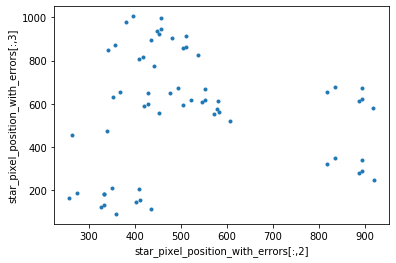

In [26]:
pyplot.plot(star_pixel_position_with_errors[:,2],
            star_pixel_position_with_errors[:,3], '.', ls='None')
pyplot.xlabel(r'star_pixel_position_with_errors[:,2]')
pyplot.ylabel(r'star_pixel_position_with_errors[:,3]')

pyplot.show()

1
2
3
4
5
6


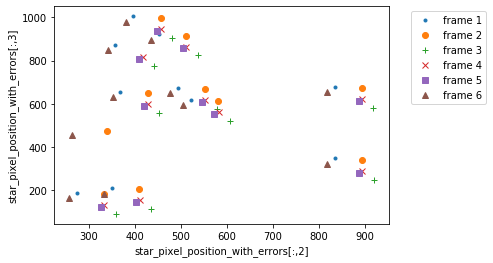

In [27]:
list_marker = ['.','o','+','x','s','^',]*10 # (It can handle up to 60 frames.)
for i_frame in range(1,7):# 6 frames
    print(i_frame)
    filter_tmp_plate_i = np.isclose(star_pixel_position_with_errors[:,0], i_frame)


    pyplot.plot(star_pixel_position_with_errors[filter_tmp_plate_i,2],
                star_pixel_position_with_errors[filter_tmp_plate_i,3],
                marker=list_marker[i_frame-1], ls='None', label='frame %d' % (i_frame))

pyplot.xlabel(r'star_pixel_position_with_errors[:,2]')
pyplot.ylabel(r'star_pixel_position_with_errors[:,3]')
pyplot.legend(bbox_to_anchor=(1.05, 1), )
pyplot.show()

# Possible location of the bug

## The function __overwrite_pixel_error_to_ecliptic is suspicious...

In [28]:

def __overwrite_pixel_error_to_ecliptic(star_pixel_position_with_errors):
    errors = star_pixel_position_with_errors[:, CenterCalculator.X_ERROR_INDEX:CenterCalculator.Y_ERROR_INDEX + 1]
    errors *= dpixel
    star_pixel_position_with_errors[:, CenterCalculator.X_ERROR_INDEX:CenterCalculator.Y_ERROR_INDEX + 1] = errors


If you want to check

- the behavior of the code with __overwrite_pixel_error_to_ecliptic enabled 
- the behavior of the code with __overwrite_pixel_error_to_ecliptic disabled

you need to set 

- TEST_overwrite = True
- TEST_overwrite = False

respectively.


In [29]:
TEST_overwrite = True # Default; This results in large values in c_vector.
#TEST_overwrite = False 



In [30]:
# retry:
star_pixel_position_with_errors = saved_star_pixel_position_with_errors *1.
psf_coefficient = saved_psf_coefficient*1.

if (TEST_overwrite):
    print('__overwrite_pixel_error_to_ecliptic is enabled.')
    __overwrite_pixel_error_to_ecliptic(star_pixel_position_with_errors=star_pixel_position_with_errors)
else:
    print('__overwrite_pixel_error_to_ecliptic is disabled.')


__overwrite_pixel_error_to_ecliptic is enabled.


In [31]:
star_pixel_position_with_errors

array([[1.00000000e+00, 1.00000000e+00, 3.96117345e+02, 1.00503630e+03,
        2.59273744e-09, 2.59273744e-09],
       [1.00000000e+00, 2.00000000e+00, 4.52098979e+02, 9.23016758e+02,
        2.84563026e-09, 2.84563026e-09],
       [1.00000000e+00, 3.00000000e+00, 3.57066219e+02, 8.72911188e+02,
        4.06367401e-09, 4.06367401e-09],
       [1.00000000e+00, 4.00000000e+00, 8.35244224e+02, 6.79038097e+02,
        1.88125768e-09, 1.88125768e-09],
       [1.00000000e+00, 5.00000000e+00, 4.93122546e+02, 6.74942263e+02,
        3.06022757e-09, 3.06022757e-09],
       [1.00000000e+00, 6.00000000e+00, 3.68217184e+02, 6.55941636e+02,
        2.20476052e-09, 2.20476052e-09],
       [1.00000000e+00, 7.00000000e+00, 5.21112761e+02, 6.20063164e+02,
        2.32013524e-09, 2.32013524e-09],
       [1.00000000e+00, 8.00000000e+00, 8.35223236e+02, 3.47942489e+02,
        2.16686965e-09, 2.16686965e-09],
       [1.00000000e+00, 9.00000000e+00, 3.49039378e+02, 2.12597807e+02,
        1.90611102e-09, 

In [32]:
saved_star_pixel_position_with_errors

array([[1.00000000e+00, 1.00000000e+00, 3.96117345e+02, 1.00503630e+03,
        9.97206708e-04, 9.97206708e-04],
       [1.00000000e+00, 2.00000000e+00, 4.52098979e+02, 9.23016758e+02,
        1.09447318e-03, 1.09447318e-03],
       [1.00000000e+00, 3.00000000e+00, 3.57066219e+02, 8.72911188e+02,
        1.56295154e-03, 1.56295154e-03],
       [1.00000000e+00, 4.00000000e+00, 8.35244224e+02, 6.79038097e+02,
        7.23560648e-04, 7.23560648e-04],
       [1.00000000e+00, 5.00000000e+00, 4.93122546e+02, 6.74942263e+02,
        1.17701060e-03, 1.17701060e-03],
       [1.00000000e+00, 6.00000000e+00, 3.68217184e+02, 6.55941636e+02,
        8.47984816e-04, 8.47984816e-04],
       [1.00000000e+00, 7.00000000e+00, 5.21112761e+02, 6.20063164e+02,
        8.92359708e-04, 8.92359708e-04],
       [1.00000000e+00, 8.00000000e+00, 8.35223236e+02, 3.47942489e+02,
        8.33411403e-04, 8.33411403e-04],
       [1.00000000e+00, 9.00000000e+00, 3.49039378e+02, 2.12597807e+02,
        7.33119625e-04, 

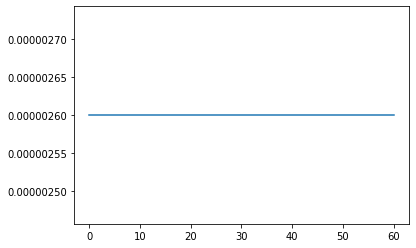

In [33]:
# error is multiplied by a factor.
pyplot.plot(star_pixel_position_with_errors[:,4]/saved_star_pixel_position_with_errors[:,4])

In [34]:
ecliptic_positions = large_frame_processor.convert_to_ecliptic(
star_pixel_position_with_errors=star_pixel_position_with_errors)


In [35]:
ecliptic_positions

array([[ 4.64547173, -0.1004345 ],
       [ 4.64561729, -0.10064775],
       [ 4.6453702 , -0.10077803],
       [ 4.64661346, -0.1012821 ],
       [ 4.64572395, -0.10129275],
       [ 4.64539919, -0.10134215],
       [ 4.64579672, -0.10143543],
       [ 4.64661341, -0.10214295],
       [ 4.64534933, -0.10249484],
       [ 4.64515202, -0.10255331],
       [ 4.64547206, -0.10043574],
       [ 4.6456176 , -0.10064895],
       [ 4.64661057, -0.10127915],
       [ 4.64572413, -0.10129111],
       [ 4.64539927, -0.1013403 ],
       [ 4.6457973 , -0.10143698],
       [ 4.64516762, -0.10179829],
       [ 4.64661348, -0.10214108],
       [ 4.64535051, -0.10249775],
       [ 4.64515235, -0.10255452],
       [ 4.64547218, -0.10043463],
       [ 4.64561772, -0.10064788],
       [ 4.64537062, -0.10077815],
       [ 4.64661162, -0.10128257],
       [ 4.64572437, -0.10129285],
       [ 4.64539957, -0.10134218],
       [ 4.64579718, -0.10143553],
       [ 4.64661376, -0.10214294],
       [ 4.64534977,

In [36]:
star_center_matrix = np.concatenate([
            star_pixel_position_with_errors[:, 0:MappedStarObservationsOnPlate.LONGITUDE_INDEX],
            ecliptic_positions,
            star_pixel_position_with_errors[:, MappedStarObservationsOnPlate.LONGITUDE_INDEX:]
], axis=1)

In [37]:
star_center_matrix

array([[ 1.00000000e+00,  1.00000000e+00,  4.64547173e+00,
        -1.00434503e-01,  3.96117345e+02,  1.00503630e+03,
         2.59273744e-09,  2.59273744e-09],
       [ 1.00000000e+00,  2.00000000e+00,  4.64561729e+00,
        -1.00647754e-01,  4.52098979e+02,  9.23016758e+02,
         2.84563026e-09,  2.84563026e-09],
       [ 1.00000000e+00,  3.00000000e+00,  4.64537020e+00,
        -1.00778028e-01,  3.57066219e+02,  8.72911188e+02,
         4.06367401e-09,  4.06367401e-09],
       [ 1.00000000e+00,  4.00000000e+00,  4.64661346e+00,
        -1.01282099e-01,  8.35244224e+02,  6.79038097e+02,
         1.88125768e-09,  1.88125768e-09],
       [ 1.00000000e+00,  5.00000000e+00,  4.64572395e+00,
        -1.01292748e-01,  4.93122546e+02,  6.74942263e+02,
         3.06022757e-09,  3.06022757e-09],
       [ 1.00000000e+00,  6.00000000e+00,  4.64539919e+00,
        -1.01342149e-01,  3.68217184e+02,  6.55941636e+02,
         2.20476052e-09,  2.20476052e-09],
       [ 1.00000000e+00,  7.000000

In [38]:
mapped_star_positions = MappedStarObservationsOnPlate(star_center_matrix=star_center_matrix)


In [39]:

# If not mapped yet, map blighter stars and known stars
if len(known_star_params) != 0 and known_star_params[0, 0] < 0:
    known_star_params = LargeFrameProcessor.map_known_stars(
                all_star_position=star_center_matrix,
                known_star_params=known_star_params,
                same_star_ecliptic_range=known_stars_ecliptic_neighborhood
    )
    logger.info('%d known stars are applied.', len(known_star_params))


2021-01-14 12:43:27,178  INFO  __main__ : 11 known stars are applied.


In [40]:
known_star_params

array([[ 7.00000000e+00,  4.64579883e+00, -1.01435491e-01,
         3.07744946e-05,  4.14946088e-05,  4.17334882e-05],
       [ 3.00000000e+00,  4.64537077e+00, -1.00776171e-01,
         2.94984693e-05,  4.74771806e-05,  9.01165615e-06],
       [ 4.00000000e+00,  4.64661284e+00, -1.01280098e-01,
         1.10035561e-06,  1.55943887e-06,  4.40834149e-05],
       [ 1.10000000e+01,  4.64516869e+00, -1.01797447e-01,
         4.35283201e-05,  4.68579008e-05,  1.95043346e-05],
       [ 5.00000000e+00,  4.64572467e+00, -1.01290897e-01,
         3.54672562e-05,  3.01499243e-05,  4.19518375e-05],
       [ 9.00000000e+00,  4.64535117e+00, -1.02495692e-01,
         4.92086085e-05,  3.39407283e-05,  3.39350733e-05],
       [ 1.00000000e+00,  4.64547259e+00, -1.00434281e-01,
         1.82441195e-05,  2.53214946e-05,  1.04189283e-05],
       [ 2.00000000e+00,  4.64561747e+00, -1.00647784e-01,
         3.89586797e-05,  9.54204166e-06,  2.68420093e-05],
       [ 8.00000000e+00,  4.64661394e+00, -1.021

In [41]:

def create_blighter_initial_parameters(star_positions, exp_term_number):
    """
        Create initial values for calculating distortion parameters using brighter stars.
        Plate parameters (c and d) are calculated from 3 stars in each plate.

        Parameters
        ----------
        star_positions: MappedStarObservationsOnPlate
            Star positions
        exp_term_number: int
            Plate parameter size (value assumes 1)

        Returns
        -------
        initial_parameters: DistortionParameters
            Initial values
    """

    # calculate coordinate average for each star
    lambda_vector, beta_vector = __average_for_each_star_id(
            unique_star_ids=star_positions.get_star_id_list(),
            star_index_list=star_positions.get_star_index_list(),
            lambda_list=star_positions.get_x_list(),
            beta_list=star_positions.get_y_list()
    )

    star_id_index = 1
    x_index = 2
    y_index = 3

    # calculate initial value of c_vector and d_vector for each plate
    c_vector = []
    d_vector = []
    for plate_index, plate_id in enumerate(np.unique(star_positions.get_plate_id_list())):
        same_plate_records = star_positions.get_records_by_plate_id(plate_id)
        if same_plate_records.shape[0] >= 3:
            # plate parameters can be calculated
            index1 = star_positions.get_star_id_mapping().get(int(same_plate_records[0, star_id_index]))
            index2 = star_positions.get_star_id_mapping().get(int(same_plate_records[1, star_id_index]))
            index3 = star_positions.get_star_id_mapping().get(int(same_plate_records[2, star_id_index]))
            parameter_matrix = np.array([
                    1.0,
                    float(lambda_vector[index1]),
                    float(beta_vector[index1]),
                    1.0,
                    float(lambda_vector[index2]),
                    float(beta_vector[index2]),
                    1.0,
                    float(lambda_vector[index3]),
                    float(beta_vector[index3])
            ]).reshape(3, 3)
            parameter_matrix = np.linalg.pinv(parameter_matrix)
            c_vector_in_plate = np.matmul(parameter_matrix, np.array(same_plate_records[0:3, x_index]))
            d_vector_in_plate = np.matmul(parameter_matrix, np.array(same_plate_records[0:3, y_index]))
        else:
            # plate parameters cannot be calculated
            logger.debug('Stars is too few to decide initial plate parameter. plate_id=%d, stars=%d',
                             plate_id, same_plate_records.shape[0])
            c_vector_in_plate = np.random.rand(3) - 0.5
            d_vector_in_plate = np.random.rand(3) - 0.5
        c_vector.extend(c_vector_in_plate.tolist())
        d_vector.extend(d_vector_in_plate.tolist())

    c_vector = np.array(c_vector)
    d_vector = np.array(d_vector)
    c_common_vector = np.zeros(int((exp_term_number + 1) * (exp_term_number + 2) / 2 - 3))
    d_common_vector = np.zeros(int((exp_term_number + 1) * (exp_term_number + 2) / 2 - 3))

    return DistortionParameters(lambda_vector, beta_vector, c_vector, d_vector, c_common_vector, d_common_vector)


In [42]:
def __average_for_each_star_id(unique_star_ids, star_index_list, lambda_list, beta_list):
    """
        Calculate average of lambda and beta value for each star.

        Parameters
        ----------
        unique_star_ids: np.array (1 order)
            Unique star ID list (ordered)

        Returns
        -------
        lambda_vector: np.array (1 order)
            Average value of lambda (array length is same to star ids)
        beta_vector: np.array (1 order)
            Average value of beta (array length is same to star ids)
    """
    onehot_star_id = np.eye(len(unique_star_ids))[star_index_list]
    onehot_star_id[onehot_star_id == 0] = np.nan
    onehot_x = lambda_list.reshape(-1, 1) * onehot_star_id
    onehot_y = beta_list.reshape(-1, 1) * onehot_star_id
    lambda_vector = np.nanmean(onehot_x, axis=0)
    beta_vector = np.nanmean(onehot_y, axis=0)
    return lambda_vector, beta_vector

In [43]:
initial_parameters_tmp = create_blighter_initial_parameters(star_positions=mapped_star_positions,
                                                                       exp_term_number=1)

In [44]:
initial_parameters_tmp.lambda_vector

array([4.64547169, 4.64561683, 4.64537006, 4.64661208, 4.64572387,
       4.64539908, 4.64579721, 4.64661329, 4.64535019, 4.64515198,
       4.64516773])

In [45]:
initial_parameters_tmp.beta_vector

array([-0.10043513, -0.1006484 , -0.10077796, -0.10128144, -0.10129243,
       -0.10134174, -0.10143614, -0.10214253, -0.10249675, -0.10255393,
       -0.10179848])

In [46]:
initial_parameters_tmp.c_vector

array([-8.04338752e-03,  1.00171450e+00, -7.84395470e-04,  2.81033231e-02,
        9.93818302e-01, -6.11286914e-03, -8.17860109e-03,  1.00174516e+00,
       -7.16616772e-04, -7.96298479e-03,  1.00169364e+00, -9.34143314e-04,
       -8.28508372e-03,  1.00176678e+00, -7.71329298e-04,  4.65759722e-02,
        9.90039827e-01,  3.04355648e-03])

In [47]:
initial_parameters_tmp.d_vector

array([-0.00984114,  0.00214864,  1.00139087, -0.02163698,  0.00472084,
        1.00292862, -0.0096778 ,  0.00211332,  1.00138467, -0.01061274,
        0.00231277,  1.00130317, -0.00999036,  0.00217976,  1.0013484 ,
        0.03316956, -0.00722916,  0.99589504])

In [48]:
initial_parameters_tmp.c_common_vector

array([], dtype=float64)

In [49]:
initial_parameters_tmp.d_common_vector

array([], dtype=float64)

In [50]:
# calculate distortion of plates by using brighter stars
distortion_calculator = DistortionCalculator(mapped_star_positions)
plate_parameters, plate_parameter_errors = distortion_calculator.calculate(
            known_star_params=known_star_params,
            max_iteration=position_iteration,
            initial_parameters=create_blighter_initial_parameters(star_positions=mapped_star_positions,
                                                                       exp_term_number=1)
        )

2021-01-14 12:43:36,241  INFO  image.distortion : Preparing least square calculation for star position parameters... (number of stars = 11, number of plates = 6)
2021-01-14 12:43:36,242  DEBUG  image.distortion : Known star indices: [ 6.  2.  3. 10.  4.  8.  0.  1.  7.  5.  9.]
2021-01-14 12:43:36,244  INFO  image.distortion : Start solving distortion parameters.
2021-01-14 12:43:36,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 475581.436723)
2021-01-14 12:43:36,319  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 2315396.144476)
2021-01-14 12:43:36,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 2751730.805753)
2021-01-14 12:43:36,386  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 1201157985.661090)
2021-01-14 12:43:36,417  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm 

star_position_restraint_return_size 22


2021-01-14 12:43:36,452  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 34224617351673.652344)
2021-01-14 12:43:36,486  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 40682735.310314)
2021-01-14 12:43:36,522  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 10558.259445)
2021-01-14 12:43:36,555  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.003302)
2021-01-14 12:43:36,590  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-

In [52]:
plate_parameters.c_vector

array([ 1.33554721e+13,  5.61238477e+11, -2.77645903e+12,  1.06379895e+13,
        6.15913011e+12, -2.39240496e+12,  1.37831633e+13,  2.03161151e+12,
       -2.86519185e+12,  1.30856313e+13, -8.79019137e+11, -2.82728653e+12,
        1.57931704e+13, -1.45876022e+12, -3.41544896e+12,  1.20482360e+13,
        2.43275484e+12, -2.61639863e+12])

## Short summary

- When TEST_overwrite = True (__overwrite_pixel_error_to_ecliptic is enabled), you will probably get very large plate_parameters.c_vector

- When TEST_overwrite = False (__overwrite_pixel_error_to_ecliptic is disabled), this problem seems to disappear. 

I am not sure if __overwrite_pixel_error_to_ecliptic is working as expected, but just in case I share this information. 
Hope it helps somebody!



# Script shown below is not cleaned yet...

In [272]:
mapped_star_positions.get_star_count()

11

In [273]:
plate_id_mapping = mapped_star_positions.get_plate_id_mapping()

In [274]:
for i in range(12):
    print(i, plate_id_mapping.get(i))

0 None
1 0
2 1
3 2
4 3
5 4
6 5
7 None
8 None
9 None
10 None
11 None


In [275]:
star_id_mapping = mapped_star_positions.get_star_id_mapping()

In [276]:
for i in range(13):
    print(i, star_id_mapping.get(i))

0 None
1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 None


In [277]:
initial_parameters_tmp.lambda_vector

array([4.64547169, 4.64561683, 4.64537006, 4.64661208, 4.64572387,
       4.64539908, 4.64579721, 4.64661329, 4.64535019, 4.64515198,
       4.64516773])

In [278]:
mapped_star_positions.get_xy_list() 

array([ 4.64547173,  4.64547206,  4.64547218,  4.64547029,  4.64547161,
        4.64547228,  4.64561729,  4.6456176 ,  4.64561772,  4.64561587,
        4.64561717,  4.64561532,  4.6453702 ,  0.        ,  4.64537062,
        4.64536881,  4.64537007,  4.64537062,  4.64661346,  4.64661057,
        4.64661162,  4.64661221,  4.64661384,  4.64661077,  4.64572395,
        4.64572413,  4.64572437,  4.64572259,  4.64572382,  4.64572435,
        4.64539919,  4.64539927,  4.64539957,  4.64539787,  4.64539908,
        4.6453995 ,  4.64579672,  4.6457973 ,  4.64579718,  4.64579796,
        4.64579659,  4.64579749,  4.64661341,  4.64661348,  4.64661376,
        4.64661211,  4.6466133 ,  4.6466137 ,  4.64534933,  4.64535051,
        4.64534977,  4.64535098,  4.64535002,  4.6453505 ,  4.64515202,
        4.64515235,  4.64515246,  4.64515055,  4.64515191,  4.64515257,
        0.        ,  4.64516762,  0.        ,  0.        ,  0.        ,
        4.64516783, -0.1004345 , -0.10043574, -0.10043463, -0.10

In [279]:
len(mapped_star_positions.get_xy_list() )

132

(-0.104, -0.1)

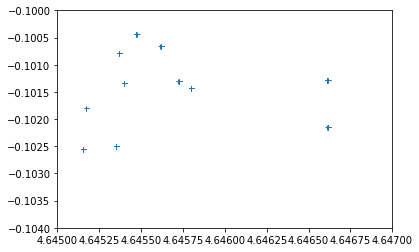

In [280]:
pyplot.plot(mapped_star_positions.get_xy_list()[0:66], 
            mapped_star_positions.get_xy_list()[66:132] , 
        '+', markersize=5)
pyplot.xlim([4.645,4.647])
pyplot.ylim([-0.104,-0.100])

In [281]:
mapped_star_positions.create_xy_covariance_matrix_without_no_value()

array([[9.94421219e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.97237736e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.97836462e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.42460667e-07, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.77251090e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.75272793e-06]])

In [282]:
mapped_star_positions.create_xy_covariance_matrix_without_no_value().shape

(122, 122)

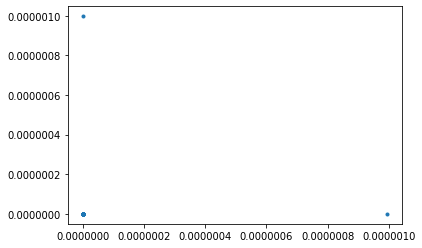

In [283]:
pyplot.plot(mapped_star_positions.create_xy_covariance_matrix_without_no_value()[:,0], 
            mapped_star_positions.create_xy_covariance_matrix_without_no_value()[:,1], '.')

In [284]:
mapped_star_positions.get_no_value_indices()[0].tolist() 

[13, 60, 62, 63, 64, 79, 126, 128, 129, 130]

In [285]:
mapped_star_positions.get_no_value_indices()

(array([ 13,  60,  62,  63,  64,  79, 126, 128, 129, 130]),)

In [286]:
mapped_star_positions.get_records_by_plate_id(1)

array([[ 1.00000000e+00,  1.00000000e+00,  4.64547173e+00,
        -1.00434503e-01,  3.96117345e+02,  1.00503630e+03,
         9.97206708e-04,  9.97206708e-04],
       [ 1.00000000e+00,  2.00000000e+00,  4.64561729e+00,
        -1.00647754e-01,  4.52098979e+02,  9.23016758e+02,
         1.09447318e-03,  1.09447318e-03],
       [ 1.00000000e+00,  3.00000000e+00,  4.64537020e+00,
        -1.00778028e-01,  3.57066219e+02,  8.72911188e+02,
         1.56295154e-03,  1.56295154e-03],
       [ 1.00000000e+00,  4.00000000e+00,  4.64661346e+00,
        -1.01282099e-01,  8.35244224e+02,  6.79038097e+02,
         7.23560648e-04,  7.23560648e-04],
       [ 1.00000000e+00,  5.00000000e+00,  4.64572395e+00,
        -1.01292748e-01,  4.93122546e+02,  6.74942263e+02,
         1.17701060e-03,  1.17701060e-03],
       [ 1.00000000e+00,  6.00000000e+00,  4.64539919e+00,
        -1.01342149e-01,  3.68217184e+02,  6.55941636e+02,
         8.47984816e-04,  8.47984816e-04],
       [ 1.00000000e+00,  7.000000

In [287]:
mapped_star_positions.get_xy_list()

array([ 4.64547173,  4.64547206,  4.64547218,  4.64547029,  4.64547161,
        4.64547228,  4.64561729,  4.6456176 ,  4.64561772,  4.64561587,
        4.64561717,  4.64561532,  4.6453702 ,  0.        ,  4.64537062,
        4.64536881,  4.64537007,  4.64537062,  4.64661346,  4.64661057,
        4.64661162,  4.64661221,  4.64661384,  4.64661077,  4.64572395,
        4.64572413,  4.64572437,  4.64572259,  4.64572382,  4.64572435,
        4.64539919,  4.64539927,  4.64539957,  4.64539787,  4.64539908,
        4.6453995 ,  4.64579672,  4.6457973 ,  4.64579718,  4.64579796,
        4.64579659,  4.64579749,  4.64661341,  4.64661348,  4.64661376,
        4.64661211,  4.6466133 ,  4.6466137 ,  4.64534933,  4.64535051,
        4.64534977,  4.64535098,  4.64535002,  4.6453505 ,  4.64515202,
        4.64515235,  4.64515246,  4.64515055,  4.64515191,  4.64515257,
        0.        ,  4.64516762,  0.        ,  0.        ,  0.        ,
        4.64516783, -0.1004345 , -0.10043574, -0.10043463, -0.10

In [288]:
known_star_params

array([[ 7.00000000e+00,  4.64579883e+00, -1.01435491e-01,
         3.07744946e-05,  4.14946088e-05,  4.17334882e-05],
       [ 3.00000000e+00,  4.64537077e+00, -1.00776171e-01,
         2.94984693e-05,  4.74771806e-05,  9.01165615e-06],
       [ 4.00000000e+00,  4.64661284e+00, -1.01280098e-01,
         1.10035561e-06,  1.55943887e-06,  4.40834149e-05],
       [ 1.10000000e+01,  4.64516869e+00, -1.01797447e-01,
         4.35283201e-05,  4.68579008e-05,  1.95043346e-05],
       [ 5.00000000e+00,  4.64572467e+00, -1.01290897e-01,
         3.54672562e-05,  3.01499243e-05,  4.19518375e-05],
       [ 9.00000000e+00,  4.64535117e+00, -1.02495692e-01,
         4.92086085e-05,  3.39407283e-05,  3.39350733e-05],
       [ 1.00000000e+00,  4.64547259e+00, -1.00434281e-01,
         1.82441195e-05,  2.53214946e-05,  1.04189283e-05],
       [ 2.00000000e+00,  4.64561747e+00, -1.00647784e-01,
         3.89586797e-05,  9.54204166e-06,  2.68420093e-05],
       [ 8.00000000e+00,  4.64661394e+00, -1.021

In [289]:
len(known_star_params)

11

In [293]:
# extract all stars, correct distortion, and mapping stars
# all_star_position_in_pixel is list of
# (plate id, star id, x in ecliptic, y in ecliptic, x in pixel, y in pixel)

all_star_position_in_pixel, all_extracted_star_image_list = large_frame_processor.execute(
            same_star_ecliptic_range=darker_star_same_ecliptic_range,
            binary_threshold=darker_threshold,
            distortion_parameters=plate_parameters
)

2021-01-13 14:29:57,035  INFO  image.large_frame_processor : 12 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate000.fits" with binary threshold (16000,).
2021-01-13 14:29:57,376  INFO  image.large_frame_processor : 12 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate001.fits" with binary threshold (16000,).
2021-01-13 14:29:57,667  INFO  image.large_frame_processor : 12 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate002.fits" with binary threshold (16000,).
2021-01-13 14:29:57,986  INFO  image.large_frame_processor : 11 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate003.fits" with binary threshold (16000,).
2021-01-13 14:29:58,288  INFO  image.large_frame_processor : 12 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate004.fits" with binary threshold (16000,).
2021-01-13 14:29:58,603  INFO  image.large_frame_processor : 12 stars are found in "mksamplefits3_single_star/dataset/fr

In [294]:
# estimate center position for all stars
all_star_position_in_pixel = all_star_position_in_pixel[:, [0, 1, 4, 5]]
star_pixel_position_with_errors, psf_coefficient = center_calculator.execute(
            star_positions_in_pixel=all_star_position_in_pixel,
            all_extracted_star_images=all_extracted_star_image_list
)

2021-01-13 14:30:44,019  INFO  app.calculate_center_position : Calculation of center coordinates is stared. plates=6, stars=14, star images=71
2021-01-13 14:30:44,022  INFO  app.calculate_center_position : Calculate the tentative center position using a Gaussian function.
2021-01-13 14:30:44,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1038.618120)
2021-01-13 14:30:44,034  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 7644.716014)
2021-01-13 14:30:44,036  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 625.935419)
2021-01-13 14:30:44,038  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.667536)
2021-01-13 14:30:44,042  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.030323)
2021-01-13 14:30:44,044  DEBUG  common.leastsquare : Solving with least square calculation (iterati

2021-01-13 14:30:44,174  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.171511)
2021-01-13 14:30:44,176  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.012897)
2021-01-13 14:30:44,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000844)
2021-01-13 14:30:44,180  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000138)
2021-01-13 14:30:44,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000009)
2021-01-13 14:30:44,184  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000061)
2021-01-13 14:30:44,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000147)
2021-01-13 14:30:44,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000091)
2021-

before_center_positions []


2021-01-13 14:30:44,223  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000827)
2021-01-13 14:30:44,226  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000431)
2021-01-13 14:30:44,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000738)
2021-01-13 14:30:44,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001473)
2021-01-13 14:30:44,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000476)
2021-01-13 14:30:44,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000639)
2021-01-13 14:30:44,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000637)
2021-01-13 14:30:44,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000539)
20

2021-01-13 14:30:44,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000786)
2021-01-13 14:30:44,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000733)
2021-01-13 14:30:44,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000361)
2021-01-13 14:30:44,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000366)
2021-01-13 14:30:44,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000682)
2021-01-13 14:30:44,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.001240)
2021-01-13 14:30:44,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000792)
2021-01-13 14:30:44,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 364.201952)

2021-01-13 14:30:44,505  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001761)
2021-01-13 14:30:44,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1727.775673)
2021-01-13 14:30:44,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 17783.007228)
2021-01-13 14:30:44,512  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 2180.397984)
2021-01-13 14:30:44,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 26.548399)
2021-01-13 14:30:44,516  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.234958)
2021-01-13 14:30:44,517  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002559)
2021-01-13 14:30:44,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.0003

2021-01-13 14:30:44,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.026887)
2021-01-13 14:30:44,648  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001973)
2021-01-13 14:30:44,650  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000525)
2021-01-13 14:30:44,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000457)
2021-01-13 14:30:44,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000116)
2021-01-13 14:30:44,656  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000032)
2021-01-13 14:30:44,658  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000086)
2021-01-13 14:30:44,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000150)
2021

2021-01-13 14:30:44,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000009)
2021-01-13 14:30:44,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000026)
2021-01-13 14:30:44,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000010)
2021-01-13 14:30:44,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000012)
2021-01-13 14:30:44,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1539.490323)
2021-01-13 14:30:44,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 12442.937209)
2021-01-13 14:30:44,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 1034.010896)
2021-01-13 14:30:44,949  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 2.72

2021-01-13 14:30:45,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 658.022471)
2021-01-13 14:30:45,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 2.017594)
2021-01-13 14:30:45,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.045098)
2021-01-13 14:30:45,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001674)
2021-01-13 14:30:45,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000103)
2021-01-13 14:30:45,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000200)
2021-01-13 14:30:45,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000778)
2021-01-13 14:30:45,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000328)
2021-

2021-01-13 14:30:45,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000279)
2021-01-13 14:30:45,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000024)
2021-01-13 14:30:45,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000050)
2021-01-13 14:30:45,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000575)
2021-01-13 14:30:45,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000460)
2021-01-13 14:30:45,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000013)
2021-01-13 14:30:45,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000510)
2021-01-13 14:30:45,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000015)
2

2021-01-13 14:30:45,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002029)
2021-01-13 14:30:45,409  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000247)
2021-01-13 14:30:45,411  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.002717)
2021-01-13 14:30:45,413  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.002469)
2021-01-13 14:30:45,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000168)
2021-01-13 14:30:45,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000011)
2021-01-13 14:30:45,420  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1527.794752)
2021-01-13 14:30:45,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 14848.868

2021-01-13 14:30:45,549  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1630.899021)
2021-01-13 14:30:45,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 5527.331069)
2021-01-13 14:30:45,553  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 157.758713)
2021-01-13 14:30:45,555  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.260782)
2021-01-13 14:30:45,558  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002120)
2021-01-13 14:30:45,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000169)
2021-01-13 14:30:45,563  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001619)
2021-01-13 14:30:45,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000402)


2021-01-13 14:30:45,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000069)
2021-01-13 14:30:45,699  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000479)
2021-01-13 14:30:45,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001268)
2021-01-13 14:30:45,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000950)
2021-01-13 14:30:45,706  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000082)
2021-01-13 14:30:45,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000340)
2021-01-13 14:30:45,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000213)
2021-01-13 14:30:45,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000073)
202

2021-01-13 14:30:45,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000130)
2021-01-13 14:30:45,847  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000411)
2021-01-13 14:30:45,849  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000033)
2021-01-13 14:30:45,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000456)
2021-01-13 14:30:45,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000289)
2021-01-13 14:30:45,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000525)
2021-01-13 14:30:45,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000257)
2021-01-13 14:30:45,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000183)


2021-01-13 14:30:45,994  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000016)
2021-01-13 14:30:45,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000100)
2021-01-13 14:30:45,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1986.853782)
2021-01-13 14:30:46,000  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 21327.199899)
2021-01-13 14:30:46,003  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 3891.720284)
2021-01-13 14:30:46,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 96.500885)
2021-01-13 14:30:46,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 1.296326)
2021-01-13 14:30:46,009  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.016

2021-01-13 14:30:46,139  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001170)
2021-01-13 14:30:46,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000651)
2021-01-13 14:30:46,143  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001065)
2021-01-13 14:30:46,145  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000471)
2021-01-13 14:30:46,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000995)
2021-01-13 14:30:46,149  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001417)
2021-01-13 14:30:46,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000443)
2021-01-13 14:30:46,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.002178)
2021-

2021-01-13 14:30:46,426  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000834)
2021-01-13 14:30:46,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001049)
2021-01-13 14:30:46,430  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000978)
2021-01-13 14:30:46,433  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000171)
2021-01-13 14:30:46,435  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001067)
2021-01-13 14:30:46,437  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 1702.350209)
2021-01-13 14:30:46,439  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 18248.941017)
2021-01-13 14:30:46,443  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 3345.6

2021-01-13 14:30:46,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 11048.866642)
2021-01-13 14:30:46,582  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 538.355829)
2021-01-13 14:30:46,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.404286)
2021-01-13 14:30:46,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000224)
2021-01-13 14:30:46,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002974)
2021-01-13 14:30:46,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001582)
2021-01-13 14:30:46,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000227)
2021-01-13 14:30:46,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000744)
20

2021-01-13 14:30:46,739  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000925)
2021-01-13 14:30:46,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000342)
2021-01-13 14:30:46,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000221)
2021-01-13 14:30:46,747  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000114)
2021-01-13 14:30:46,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000074)
2021-01-13 14:30:46,751  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000094)
2021-01-13 14:30:46,753  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000033)
2021-01-13 14:30:46,755  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000042)
20

2021-01-13 14:30:46,890  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.002652)
2021-01-13 14:30:46,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001423)
2021-01-13 14:30:46,894  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.002294)
2021-01-13 14:30:46,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.002222)
2021-01-13 14:30:46,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.002182)
2021-01-13 14:30:46,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000427)
2021-01-13 14:30:46,903  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000479)
2021-01-13 14:30:46,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 748.345217)

2021-01-13 14:30:47,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001072)
2021-01-13 14:30:47,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 326.451692)
2021-01-13 14:30:47,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 299.085059)
2021-01-13 14:30:47,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 13.861223)
2021-01-13 14:30:47,039  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 1.015334)
2021-01-13 14:30:47,041  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.097602)
2021-01-13 14:30:47,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.008858)
2021-01-13 14:30:47,046  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000520)
20

2021-01-13 14:30:47,185  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001175)
2021-01-13 14:30:47,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000760)
2021-01-13 14:30:47,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000487)
2021-01-13 14:30:47,191  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000028)
2021-01-13 14:30:47,193  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000154)
2021-01-13 14:30:47,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000416)
2021-01-13 14:30:47,198  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000965)
2021-01-13 14:30:47,200  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000923)
2021

# use a Gaussian function to calculate a temporary center position.
0 [-0.38074586 -0.04904188] 71456.33470907071 0.569700099159365
1 [ 0.31219692 -0.29657224] 18264.858025131907 0.5831390643664709
2 [-0.49862608 -0.33316875] 57886.47771397675 0.5716828489374705
3 [ 0.12381206 -0.21391947] 24519.364774550824 0.5771123179235994
4 [ 0.30792393 -0.49570096] 142758.38234220585 0.5686924324446994
5 [ 0.15673018 -0.10454981] 48965.95914770587 0.5723782106771769
6 [ 0.25938695 -0.06558279] 101732.68095173036 0.5691323863459141
7 [-0.45879287  0.42446456] 91064.05234878414 0.5700705041053895
8 [0.3234354  0.05988285] 20763.94936448303 0.5801892054837212
9 [ 0.20971018 -0.07421378] 105573.02700457948 0.5697157922352917
10 [-0.22754931  0.24525232] 138768.42007233176 0.5691468807521535
11 [-0.46639992 -0.09597915] 114913.41179648039 0.5690748942206035
12 [ 0.04833621 -0.14889526] 71096.64769839986 0.5705674910109536
13 [-0.06768029 -0.4242469 ] 58308.05184983003 0.570229511478885
14 [-0.44718535

-2.123812 0.21391948 1133.0 7 14
-2.123812 1.2139195 662.0 7 17
-2.123812 2.2139194 459.0 7 20
-2.123812 3.2139194 468.0 7 23
-2.123812 4.2139196 469.0 7 26
-1.1238121 -3.7860806 460.0 10 2
-1.1238121 -2.7860806 478.0 10 5
-1.1238121 -1.7860805 1199.0 10 8
-1.1238121 -0.78608054 6166.0 10 11
-1.1238121 0.21391948 9318.0 10 14
-1.1238121 1.2139195 3447.0 10 17
-1.1238121 2.2139194 674.0 10 20
-1.1238121 3.2139194 447.0 10 23
-1.1238121 4.2139196 451.0 10 26
-0.123812065 -3.7860806 455.0 13 2
-0.123812065 -2.7860806 505.0 13 5
-0.123812065 -1.7860805 2475.0 13 8
-0.123812065 -0.78608054 15576.0 13 11
-0.123812065 0.21391948 23762.0 13 14
-0.123812065 1.2139195 8286.0 13 17
-0.123812065 2.2139194 987.0 13 20
-0.123812065 3.2139194 478.0 13 23
-0.123812065 4.2139196 465.0 13 26
0.8761879 -3.7860806 452.0 16 2
0.8761879 -2.7860806 500.0 16 5
0.8761879 -1.7860805 1585.0 16 8
0.8761879 -0.78608054 8933.0 16 11
0.8761879 0.21391948 13503.0 16 14
0.8761879 1.2139195 4776.0 16 17
0.8761879 2.213

4.4587927 2.5755355 461.0 26 21
4.4587927 3.5755355 453.0 26 24
-4.3234353 -4.0598826 456.0 0 1
-4.3234353 -3.0598829 444.0 0 4
-4.3234353 -2.0598829 468.0 0 7
-4.3234353 -1.0598829 461.0 0 10
-4.3234353 -0.05988285 451.0 0 13
-4.3234353 0.9401171 452.0 0 16
-4.3234353 1.9401171 436.0 0 19
-4.3234353 2.9401171 440.0 0 22
-4.3234353 3.9401171 443.0 0 25
-3.3234353 -4.0598826 449.0 3 1
-3.3234353 -3.0598829 456.0 3 4
-3.3234353 -2.0598829 459.0 3 7
-3.3234353 -1.0598829 462.0 3 10
-3.3234353 -0.05988285 470.0 3 13
-3.3234353 0.9401171 444.0 3 16
-3.3234353 1.9401171 456.0 3 19
-3.3234353 2.9401171 456.0 3 22
-3.3234353 3.9401171 463.0 3 25
-2.3234353 -4.0598826 454.0 6 1
-2.3234353 -3.0598829 459.0 6 4
-2.3234353 -2.0598829 456.0 6 7
-2.3234353 -1.0598829 623.0 6 10
-2.3234353 -0.05988285 771.0 6 13
-2.3234353 0.9401171 622.0 6 16
-2.3234353 1.9401171 472.0 6 19
-2.3234353 2.9401171 448.0 6 22
-2.3234353 3.9401171 437.0 6 25
-1.3234354 -4.0598826 449.0 9 1
-1.3234354 -3.0598829 473.0 9 4

1.0676802 2.4242468 699.0 16 20
1.0676802 3.4242468 450.0 16 23
1.0676802 4.424247 468.0 16 26
2.0676804 -3.5757532 468.0 19 2
2.0676804 -2.5757532 482.0 19 5
2.0676804 -1.5757531 782.0 19 8
2.0676804 -0.5757531 2094.0 19 11
2.0676804 0.4242469 2323.0 19 14
2.0676804 1.4242469 882.0 19 17
2.0676804 2.4242468 485.0 19 20
2.0676804 3.4242468 447.0 19 23
2.0676804 4.424247 443.0 19 26
3.0676804 -3.5757532 460.0 22 2
3.0676804 -2.5757532 452.0 22 5
3.0676804 -1.5757531 449.0 22 8
3.0676804 -0.5757531 495.0 22 11
3.0676804 0.4242469 499.0 22 14
3.0676804 1.4242469 470.0 22 17
3.0676804 2.4242468 442.0 22 20
3.0676804 3.4242468 449.0 22 23
3.0676804 4.424247 467.0 22 26
4.0676804 -3.5757532 444.0 25 2
4.0676804 -2.5757532 439.0 25 5
4.0676804 -1.5757531 437.0 25 8
4.0676804 -0.5757531 463.0 25 11
4.0676804 0.4242469 453.0 25 14
4.0676804 1.4242469 436.0 25 17
4.0676804 2.4242468 444.0 25 20
4.0676804 3.4242468 439.0 25 23
4.0676804 4.424247 452.0 25 26
-3.5528147 -3.6869845 462.0 2 2
-3.5528

3.032386 1.6730134 448.0 22 18
3.032386 2.6730134 469.0 22 21
3.032386 3.6730134 440.0 22 24
4.032386 -4.326987 458.0 25 0
4.032386 -3.3269866 466.0 25 3
4.032386 -2.3269866 458.0 25 6
4.032386 -1.3269866 435.0 25 9
4.032386 -0.3269866 470.0 25 12
4.032386 0.6730134 468.0 25 15
4.032386 1.6730134 471.0 25 18
4.032386 2.6730134 449.0 25 21
4.032386 3.6730134 454.0 25 24
-3.7506425 -3.9655194 466.0 2 1
-3.7506425 -2.9655194 470.0 2 4
-3.7506425 -1.9655194 442.0 2 7
-3.7506425 -0.9655195 446.0 2 10
-3.7506425 0.034480512 440.0 2 13
-3.7506425 1.0344806 437.0 2 16
-3.7506425 2.0344806 445.0 2 19
-3.7506425 3.0344806 463.0 2 22
-3.7506425 4.0344806 461.0 2 25
-2.7506425 -3.9655194 460.0 5 1
-2.7506425 -2.9655194 469.0 5 4
-2.7506425 -1.9655194 452.0 5 7
-2.7506425 -0.9655195 486.0 5 10
-2.7506425 0.034480512 512.0 5 13
-2.7506425 1.0344806 489.0 5 16
-2.7506425 2.0344806 448.0 5 19
-2.7506425 3.0344806 458.0 5 22
-2.7506425 4.0344806 463.0 5 25
-1.7506425 -3.9655194 451.0 8 1
-1.7506425 -2.

4.3339076 4.21633 446.0 26 26
-3.551083 -3.5069866 442.0 2 2
-3.551083 -2.5069866 462.0 2 5
-3.551083 -1.5069865 443.0 2 8
-3.551083 -0.5069865 468.0 2 11
-3.551083 0.49301347 455.0 2 14
-3.551083 1.4930135 442.0 2 17
-3.551083 2.4930134 453.0 2 20
-3.551083 3.4930134 450.0 2 23
-3.551083 4.4930134 443.0 2 26
-2.551083 -3.5069866 454.0 5 2
-2.551083 -2.5069866 458.0 5 5
-2.551083 -1.5069865 516.0 5 8
-2.551083 -0.5069865 742.0 5 11
-2.551083 0.49301347 757.0 5 14
-2.551083 1.4930135 535.0 5 17
-2.551083 2.4930134 449.0 5 20
-2.551083 3.4930134 460.0 5 23
-2.551083 4.4930134 471.0 5 26
-1.5510832 -3.5069866 472.0 8 2
-1.5510832 -2.5069866 522.0 8 5
-1.5510832 -1.5069865 2037.0 8 8
-1.5510832 -0.5069865 7931.0 8 11
-1.5510832 0.49301347 8000.0 8 14
-1.5510832 1.4930135 2044.0 8 17
-1.5510832 2.4930134 540.0 8 20
-1.5510832 3.4930134 466.0 8 23
-1.5510832 4.4930134 455.0 8 26
-0.55108315 -3.5069866 439.0 11 2
-0.55108315 -2.5069866 778.0 11 5
-0.55108315 -1.5069865 8472.0 11 8
-0.55108315

-3.5790586 0.7398823 435.0 2 15
-3.5790586 1.7398823 438.0 2 18
-3.5790586 2.7398822 437.0 2 21
-3.5790586 3.7398822 445.0 2 24
-2.5790586 -4.2601175 470.0 5 0
-2.5790586 -3.2601178 452.0 5 3
-2.5790586 -2.2601178 441.0 5 6
-2.5790586 -1.2601177 601.0 5 9
-2.5790586 -0.2601177 914.0 5 12
-2.5790586 0.7398823 788.0 5 15
-2.5790586 1.7398823 496.0 5 18
-2.5790586 2.7398822 448.0 5 21
-2.5790586 3.7398822 454.0 5 24
-1.5790586 -4.2601175 464.0 8 0
-1.5790586 -3.2601178 472.0 8 3
-1.5790586 -2.2601178 685.0 8 6
-1.5790586 -1.2601177 4256.0 8 9
-1.5790586 -0.2601177 13028.0 8 12
-1.5790586 0.7398823 9046.0 8 15
-1.5790586 1.7398823 1753.0 8 18
-1.5790586 2.7398822 497.0 8 21
-1.5790586 3.7398822 449.0 8 24
-0.57905865 -4.2601175 435.0 11 0
-0.57905865 -3.2601178 478.0 11 3
-0.57905865 -2.2601178 1795.0 11 6
-0.57905865 -1.2601177 21015.0 11 9
-0.57905865 -0.2601177 67332.0 11 12
-0.57905865 0.7398823 47068.0 11 15
-0.57905865 1.7398823 7176.0 11 18
-0.57905865 2.7398822 633.0 11 21
-0.57905

-4.2403092 -4.3319077 440.0 0 0
-4.2403092 -3.3319077 459.0 0 3
-4.2403092 -2.3319077 441.0 0 6
-4.2403092 -1.3319077 439.0 0 9
-4.2403092 -0.3319077 442.0 0 12
-4.2403092 0.6680923 447.0 0 15
-4.2403092 1.6680923 468.0 0 18
-4.2403092 2.6680923 463.0 0 21
-4.2403092 3.6680923 447.0 0 24
-3.240309 -4.3319077 468.0 3 0
-3.240309 -3.3319077 467.0 3 3
-3.240309 -2.3319077 450.0 3 6
-3.240309 -1.3319077 445.0 3 9
-3.240309 -0.3319077 453.0 3 12
-3.240309 0.6680923 471.0 3 15
-3.240309 1.6680923 466.0 3 18
-3.240309 2.6680923 453.0 3 21
-3.240309 3.6680923 445.0 3 24
-2.240309 -4.3319077 440.0 6 0
-2.240309 -3.3319077 467.0 6 3
-2.240309 -2.3319077 451.0 6 6
-2.240309 -1.3319077 598.0 6 9
-2.240309 -0.3319077 932.0 6 12
-2.240309 0.6680923 782.0 6 15
-2.240309 1.6680923 526.0 6 18
-2.240309 2.6680923 461.0 6 21
-2.240309 3.6680923 442.0 6 24
-1.2403091 -4.3319077 455.0 9 0
-1.2403091 -3.3319077 457.0 9 3
-1.2403091 -2.3319077 556.0 9 6
-1.2403091 -1.3319077 2301.0 9 9
-1.2403091 -0.3319077 

2.5580902 -1.6140968 452.0 21 8
2.5580902 -0.61409676 555.0 21 11
2.5580902 0.3859032 539.0 21 14
2.5580902 1.3859032 477.0 21 17
2.5580902 2.3859031 470.0 21 20
2.5580902 3.3859031 458.0 21 23
2.5580902 4.3859034 442.0 21 26
3.5580902 -3.6140969 467.0 24 2
3.5580902 -2.6140969 458.0 24 5
3.5580902 -1.6140968 470.0 24 8
3.5580902 -0.61409676 470.0 24 11
3.5580902 0.3859032 445.0 24 14
3.5580902 1.3859032 460.0 24 17
3.5580902 2.3859031 445.0 24 20
3.5580902 3.3859031 468.0 24 23
3.5580902 4.3859034 467.0 24 26
-4.323404 -4.476295 439.0 0 0
-4.323404 -3.476295 444.0 0 3
-4.323404 -2.476295 435.0 0 6
-4.323404 -1.4762949 445.0 0 9
-4.323404 -0.4762949 447.0 0 12
-4.323404 0.5237051 454.0 0 15
-4.323404 1.5237051 459.0 0 18
-4.323404 2.523705 452.0 0 21
-4.323404 3.523705 459.0 0 24
-3.3234038 -4.476295 463.0 3 0
-3.3234038 -3.476295 438.0 3 3
-3.3234038 -2.476295 468.0 3 6
-3.3234038 -1.4762949 453.0 3 9
-3.3234038 -0.4762949 472.0 3 12
-3.3234038 0.5237051 461.0 3 15
-3.3234038 1.523705

4.285274 0.19187531 466.0 26 14
4.285274 1.1918753 437.0 26 17
4.285274 2.1918752 440.0 26 20
4.285274 3.1918752 454.0 26 23
4.285274 4.1918755 448.0 26 26
-4.453263 -3.5595562 435.0 0 2
-4.453263 -2.5595562 455.0 0 5
-4.453263 -1.5595562 438.0 0 8
-4.453263 -0.5595563 461.0 0 11
-4.453263 0.4404437 444.0 0 14
-4.453263 1.4404438 450.0 0 17
-4.453263 2.4404438 443.0 0 20
-4.453263 3.4404438 446.0 0 23
-4.453263 4.4404435 443.0 0 26
-3.453263 -3.5595562 468.0 3 2
-3.453263 -2.5595562 468.0 3 5
-3.453263 -1.5595562 453.0 3 8
-3.453263 -0.5595563 455.0 3 11
-3.453263 0.4404437 456.0 3 14
-3.453263 1.4404438 464.0 3 17
-3.453263 2.4404438 444.0 3 20
-3.453263 3.4404438 436.0 3 23
-3.453263 4.4404435 452.0 3 26
-2.453263 -3.5595562 467.0 6 2
-2.453263 -2.5595562 478.0 6 5
-2.453263 -1.5595562 644.0 6 8
-2.453263 -0.5595563 1435.0 6 11
-2.453263 0.4404437 1519.0 6 14
-2.453263 1.4404438 725.0 6 17
-2.453263 2.4404438 477.0 6 20
-2.453263 3.4404438 439.0 6 23
-2.453263 4.4404435 468.0 6 26
-1

3.0816548 1.6983784 477.0 22 18
3.0816548 2.6983786 444.0 22 21
3.0816548 3.6983786 465.0 22 24
4.081655 -4.3016214 465.0 25 0
4.081655 -3.3016214 467.0 25 3
4.081655 -2.3016214 470.0 25 6
4.081655 -1.3016216 465.0 25 9
4.081655 -0.30162153 446.0 25 12
4.081655 0.6983785 436.0 25 15
4.081655 1.6983784 462.0 25 18
4.081655 2.6983786 443.0 25 21
4.081655 3.6983786 441.0 25 24
-3.6772647 -3.9602375 466.0 2 1
-3.6772647 -2.9602375 452.0 2 4
-3.6772647 -1.9602375 441.0 2 7
-3.6772647 -0.96023744 443.0 2 10
-3.6772647 0.039762545 448.0 2 13
-3.6772647 1.0397625 469.0 2 16
-3.6772647 2.0397625 448.0 2 19
-3.6772647 3.0397625 468.0 2 22
-3.6772647 4.0397625 437.0 2 25
-2.6772647 -3.9602375 435.0 5 1
-2.6772647 -2.9602375 455.0 5 4
-2.6772647 -1.9602375 453.0 5 7
-2.6772647 -0.96023744 657.0 5 10
-2.6772647 0.039762545 868.0 5 13
-2.6772647 1.0397625 660.0 5 16
-2.6772647 2.0397625 471.0 5 19
-2.6772647 3.0397625 452.0 5 22
-2.6772647 4.0397625 462.0 5 25
-1.6772647 -3.9602375 463.0 8 1
-1.6772

-3.824971 -0.75789875 472.0 2 11
-3.824971 0.24210124 444.0 2 14
-3.824971 1.2421012 450.0 2 17
-3.824971 2.2421012 468.0 2 20
-3.824971 3.2421012 450.0 2 23
-3.824971 4.242101 453.0 2 26
-2.824971 -3.7578988 458.0 5 2
-2.824971 -2.7578988 438.0 5 5
-2.824971 -1.7578988 464.0 5 8
-2.824971 -0.75789875 570.0 5 11
-2.824971 0.24210124 637.0 5 14
-2.824971 1.2421012 510.0 5 17
-2.824971 2.2421012 471.0 5 20
-2.824971 3.2421012 435.0 5 23
-2.824971 4.242101 470.0 5 26
-1.824971 -3.7578988 450.0 8 2
-1.824971 -2.7578988 483.0 8 5
-1.824971 -1.7578988 1118.0 8 8
-1.824971 -0.75789875 5501.0 8 11
-1.824971 0.24210124 7724.0 8 14
-1.824971 1.2421012 2819.0 8 17
-1.824971 2.2421012 633.0 8 20
-1.824971 3.2421012 441.0 8 23
-1.824971 4.242101 438.0 8 26
-0.8249709 -3.7578988 467.0 11 2
-0.8249709 -2.7578988 603.0 11 5
-0.8249709 -1.7578988 5999.0 11 8
-0.8249709 -0.75789875 39260.0 11 11
-0.8249709 0.24210124 57971.0 11 14
-0.8249709 1.2421012 18884.0 11 17
-0.8249709 2.2421012 1661.0 11 20
-0.8

2021-01-13 14:30:54,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 168172.312143)
2021-01-13 14:30:55,430  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:30:55,967  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:30:56,025  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:30:56,031  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.322823)
2021-01-13 14:30:56,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084267)
2021-01-13 14:30:56,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.016169)
2021-01-13 14:30:56,046  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001865)
2021-01-13 14:30:56,050  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:30:56,226  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.003974)
2021-01-13 14:30:56,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.003000)
2021-01-13 14:30:56,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.002257)
2021-01-13 14:30:56,240  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001703)
2021-01-13 14:30:56,245  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001283)
2021-01-13 14:30:56,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000968)
2021-01-13 14:30:56,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000729)
2021-01-13 14:30:56,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000550)
202

2021-01-13 14:30:56,537  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.145810)
2021-01-13 14:30:56,542  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.145797)
2021-01-13 14:30:56,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.145793)
2021-01-13 14:30:56,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.145796)
2021-01-13 14:30:56,555  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.145798)
2021-01-13 14:30:56,560  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.145797)
2021-01-13 14:30:56,563  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.145796)
2021-01-13 14:30:56,568  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.145797)


2021-01-13 14:30:56,803  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.019178)
2021-01-13 14:30:56,807  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.010794)
2021-01-13 14:30:56,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.005981)
2021-01-13 14:30:56,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003351)
2021-01-13 14:30:56,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001868)
2021-01-13 14:30:56,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.001044)
2021-01-13 14:30:56,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000583)
2021-01-13 14:30:56,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000326)
202

2021-01-13 14:30:57,052  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008010)
2021-01-13 14:30:57,056  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001136)
2021-01-13 14:30:57,060  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000106)
2021-01-13 14:30:57,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000019)
2021-01-13 14:30:57,067  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-13 14:30:57,071  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:30:57,075  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:30:57,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:30:57,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.313749)
2021-01-13 14:30:57,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.310034)
2021-01-13 14:30:57,336  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.310636)
2021-01-13 14:30:57,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.312340)
2021-01-13 14:30:57,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.362819)
2021-01-13 14:30:57,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084858)
2021-01-13 14:30:57,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.270582)
2021-01-13 14:30:57,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.205112)
2021

2021-01-13 14:30:57,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.374640)
2021-01-13 14:30:57,574  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.405600)
2021-01-13 14:30:57,578  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.346840)
2021-01-13 14:30:57,581  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.470884)
2021-01-13 14:30:57,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.361487)
2021-01-13 14:30:57,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.595729)
2021-01-13 14:30:57,591  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.427838)
2021-01-13 14:30:57,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.481241)


2021-01-13 14:30:57,820  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000290)
2021-01-13 14:30:57,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000255)
2021-01-13 14:30:57,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000224)
2021-01-13 14:30:57,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000197)
2021-01-13 14:30:57,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000173)
2021-01-13 14:30:57,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.325386)
2021-01-13 14:30:57,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.066026)
2021-01-13 14:30:57,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.006593)
202

2021-01-13 14:30:58,072  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.471005)
2021-01-13 14:30:58,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.530586)
2021-01-13 14:30:58,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.497202)
2021-01-13 14:30:58,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.426359)
2021-01-13 14:30:58,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.552062)
2021-01-13 14:30:58,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.456815)
2021-01-13 14:30:58,096  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.354012)
2021-01-13 14:30:58,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.280765)
20

2021-01-13 14:30:58,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000848)
2021-01-13 14:30:58,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000557)
2021-01-13 14:30:58,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000366)
2021-01-13 14:30:58,334  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000241)
2021-01-13 14:30:58,338  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000158)
2021-01-13 14:30:58,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000104)
2021-01-13 14:30:58,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000068)
2021-01-13 14:30:58,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.405205)
2

2021-01-13 14:30:58,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.350938)
2021-01-13 14:30:58,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.363200)
2021-01-13 14:30:58,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.421095)
2021-01-13 14:30:58,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.500624)
2021-01-13 14:30:58,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.355966)
2021-01-13 14:30:58,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.325250)
2021-01-13 14:30:58,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.431039)
2021-01-13 14:30:58,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.614873)
2021-

2021-01-13 14:30:58,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.355316)
2021-01-13 14:30:58,822  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.143457)
2021-01-13 14:30:58,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.130508)
2021-01-13 14:30:58,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.029808)
2021-01-13 14:30:58,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.048489)
2021-01-13 14:30:58,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.154222)
2021-01-13 14:30:58,842  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.137651)
2021-01-13 14:30:58,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.086333)


2021-01-13 14:30:59,067  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.114414)
2021-01-13 14:30:59,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.457234)
2021-01-13 14:30:59,073  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.146617)
2021-01-13 14:30:59,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.578124)
2021-01-13 14:30:59,081  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.077040)
2021-01-13 14:30:59,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.030693)
2021-01-13 14:30:59,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.019982)
2021-01-13 14:30:59,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.015276)
2021-

2021-01-13 14:30:59,310  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.105821)
2021-01-13 14:30:59,314  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.105821)
2021-01-13 14:30:59,318  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.105821)
2021-01-13 14:30:59,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.105821)
2021-01-13 14:30:59,324  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.454562)
2021-01-13 14:30:59,328  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.587517)
2021-01-13 14:30:59,332  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 1.041380)
2021-01-13 14:30:59,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.478832)
2021

2021-01-13 14:30:59,567  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.129422)
2021-01-13 14:30:59,571  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.052316)
2021-01-13 14:30:59,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.074794)
2021-01-13 14:30:59,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.091931)
2021-01-13 14:30:59,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.093180)
2021-01-13 14:30:59,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.090778)
2021-01-13 14:30:59,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.091708)
2021-01-13 14:30:59,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.091605)
2021-01

2021-01-13 14:30:59,824  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.400679)
2021-01-13 14:30:59,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.413348)
2021-01-13 14:30:59,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.424174)
2021-01-13 14:30:59,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.442460)
2021-01-13 14:30:59,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.450848)
2021-01-13 14:30:59,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.465544)
2021-01-13 14:30:59,845  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.470015)
2021-01-13 14:30:59,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.475569)
2

2021-01-13 14:31:00,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.342931)
2021-01-13 14:31:00,074  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.358067)
2021-01-13 14:31:00,078  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.337603)
2021-01-13 14:31:00,081  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.343658)
2021-01-13 14:31:00,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.346851)
2021-01-13 14:31:00,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.348853)
2021-01-13 14:31:00,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.351110)
2021-01-13 14:31:00,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.351652)
2021

2021-01-13 14:31:00,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.037636)
2021-01-13 14:31:00,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.033643)
2021-01-13 14:31:00,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.030387)
2021-01-13 14:31:00,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.027279)
2021-01-13 14:31:00,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.024683)
2021-01-13 14:31:00,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.022221)
2021-01-13 14:31:00,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.020126)
2021-01-13 14:31:00,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.018154)


2021-01-13 14:31:00,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.344672)
2021-01-13 14:31:00,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.524213)
2021-01-13 14:31:00,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.316244)
2021-01-13 14:31:00,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.385831)
2021-01-13 14:31:00,620  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.394910)
2021-01-13 14:31:00,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.342320)
2021-01-13 14:31:00,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.454408)
2021-01-13 14:31:00,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.516453)
2021-

2021-01-13 14:31:00,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.006248)
2021-01-13 14:31:00,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.004918)
2021-01-13 14:31:00,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.003878)
2021-01-13 14:31:00,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.003054)
2021-01-13 14:31:00,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002407)
2021-01-13 14:31:00,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001896)
2021-01-13 14:31:00,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001494)
2021-01-13 14:31:00,922  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.001177)


2021-01-13 14:31:01,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.699840)
2021-01-13 14:31:01,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.651113)
2021-01-13 14:31:01,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.529893)
2021-01-13 14:31:01,195  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.375339)
2021-01-13 14:31:01,200  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.617593)
2021-01-13 14:31:01,206  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.709582)
2021-01-13 14:31:01,211  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.740561)
2021-01-13 14:31:01,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.818470)
2021-01-

 
center_positions [array([-0.38460877, -0.1623732 ]), array([ 0.30915427, -0.40351344]), array([-0.55656031, -0.30137698]), array([ 0.15192216, -0.23121592]), array([ 0.36351514, -1.01128043]), array([ 0.14404209, -0.30565849]), array([0.31220551, 0.06129339]), array([-0.49762479,  0.45752373]), array([ 0.16552981, -0.08722884]), array([0.25182595, 0.08405316]), array([-0.26495422,  0.06978531]), array([-0.41927291,  0.06979858]), array([ 0.03305859, -0.0755357 ]), array([ 0.01682641, -0.37581987]), array([-0.0318178 , -1.61454395]), array([ 0.12628258, -2.5937463 ]), array([-0.42506871,  0.27363734]), array([-0.49803869, -0.32982815]), array([-0.32426275,  0.01276116]), array([0.02094145, 0.41483534]), array([ 0.13191199, -2.1661488 ]), array([-0.36084449,  0.020163  ]), array([0.28105937, 0.48888976]), array([-0.16708535,  0.08402835]), array([-0.34011282, -0.20031046]), array([-0.54965905, -0.35192549]), array([ 0.22595265, -0.20174475]), array([ 0.0567014 , -1.49425842]), array([0

2021-01-13 14:31:06,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 21036.379425)
2021-01-13 14:31:07,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:07,395  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:07,399  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.265445)
2021-01-13 14:31:07,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.079629)
2021-01-13 14:31:07,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.088773)
2021-01-13 14:31:07,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.193259)
2021-01-13 14:31:07,413  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.103381)
2021-01-13 14:31:07,416  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:07,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007655)
2021-01-13 14:31:07,601  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003076)
2021-01-13 14:31:07,604  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001213)
2021-01-13 14:31:07,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000490)
2021-01-13 14:31:07,611  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000196)
2021-01-13 14:31:07,615  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000079)
2021-01-13 14:31:07,619  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000032)
2021-01-13 14:31:07,623  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000013)
2021-0

2021-01-13 14:31:07,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.209219)
2021-01-13 14:31:07,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.103902)
2021-01-13 14:31:07,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.109567)
2021-01-13 14:31:07,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.176231)
2021-01-13 14:31:07,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.398067)
2021-01-13 14:31:07,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.363264)
2021-01-13 14:31:07,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.297482)
2021-01-13 14:31:07,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.237079)
2021-01-

2021-01-13 14:31:08,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.002006)
2021-01-13 14:31:08,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.001355)
2021-01-13 14:31:08,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000911)
2021-01-13 14:31:08,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000611)
2021-01-13 14:31:08,096  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000410)
2021-01-13 14:31:08,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000274)
2021-01-13 14:31:08,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000183)
2021-01-13 14:31:08,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000123)


2021-01-13 14:31:08,327  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057386)
2021-01-13 14:31:08,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.014779)
2021-01-13 14:31:08,334  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003397)
2021-01-13 14:31:08,338  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000339)
2021-01-13 14:31:08,341  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000065)
2021-01-13 14:31:08,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000010)
2021-01-13 14:31:08,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-13 14:31:08,352  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-13 14:31:08,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:08,570  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.401761)
2021-01-13 14:31:08,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.137995)
2021-01-13 14:31:08,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.033300)
2021-01-13 14:31:08,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010320)
2021-01-13 14:31:08,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002590)
2021-01-13 14:31:08,588  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000690)
2021-01-13 14:31:08,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000181)
2021-01

2021-01-13 14:31:08,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000044)
2021-01-13 14:31:08,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000028)
2021-01-13 14:31:08,837  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000017)
2021-01-13 14:31:08,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.706127)
2021-01-13 14:31:08,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.883608)
2021-01-13 14:31:08,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.306048)
2021-01-13 14:31:08,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.590888)
2021-01-13 14:31:08,859  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.571955)
2021-

2021-01-13 14:31:09,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000111)
2021-01-13 14:31:09,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000038)
2021-01-13 14:31:09,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000013)
2021-01-13 14:31:09,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000004)
2021-01-13 14:31:09,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
2021-01-13 14:31:09,132  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-13 14:31:09,136  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:31:09,140  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-13 14:31:09,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.208715)
2021-01-13 14:31:09,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.208718)
2021-01-13 14:31:09,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.208714)
2021-01-13 14:31:09,380  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.208714)
2021-01-13 14:31:09,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.208714)
2021-01-13 14:31:09,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.122066)
2021-01-13 14:31:09,390  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.038797)
2021-01-13 14:31:09,394  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.018293)
202

2021-01-13 14:31:09,618  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021508)
2021-01-13 14:31:09,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021167)
2021-01-13 14:31:09,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.025831)
2021-01-13 14:31:09,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.030272)
2021-01-13 14:31:09,632  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.035843)
2021-01-13 14:31:09,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.040433)
2021-01-13 14:31:09,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.045848)
2021-01-13 14:31:09,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.049335)
2021-01

2021-01-13 14:31:09,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.169816)
2021-01-13 14:31:09,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.163939)
2021-01-13 14:31:09,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.170261)
2021-01-13 14:31:09,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.162383)
2021-01-13 14:31:09,917  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.154642)
2021-01-13 14:31:09,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.155596)
2021-01-13 14:31:09,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.156174)
2021-01-13 14:31:09,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.156634)
2

2021-01-13 14:31:10,201  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.836661)
2021-01-13 14:31:10,206  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 1.032949)
2021-01-13 14:31:10,210  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.859716)
2021-01-13 14:31:10,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.695833)
2021-01-13 14:31:10,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.456380)
2021-01-13 14:31:10,223  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.363288)
2021-01-13 14:31:10,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.303868)
2021-01-13 14:31:10,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.174489)
2021-01-

2021-01-13 14:31:10,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000010)
2021-01-13 14:31:10,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000006)
2021-01-13 14:31:10,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000004)
2021-01-13 14:31:10,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.338206)
2021-01-13 14:31:10,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.085724)
2021-01-13 14:31:10,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.061970)
2021-01-13 14:31:10,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.083205)
2021-01-13 14:31:10,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.113648)
2021-

2021-01-13 14:31:10,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.035954)
2021-01-13 14:31:10,771  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019726)
2021-01-13 14:31:10,775  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006353)
2021-01-13 14:31:10,779  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001795)
2021-01-13 14:31:10,782  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000523)
2021-01-13 14:31:10,786  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000153)
2021-01-13 14:31:10,789  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000045)
2021-01-13 14:31:10,793  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000013)
2021-01-

2021-01-13 14:31:11,032  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000001)
2021-01-13 14:31:11,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.571190)
2021-01-13 14:31:11,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.394878)
2021-01-13 14:31:11,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.675253)
2021-01-13 14:31:11,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.540210)
2021-01-13 14:31:11,051  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.633025)
2021-01-13 14:31:11,055  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.272036)
2021-01-13 14:31:11,059  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.778362)
2021-01

2021-01-13 14:31:11,294  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.090406)
2021-01-13 14:31:11,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.090337)
2021-01-13 14:31:11,302  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.090322)
2021-01-13 14:31:11,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.090325)
2021-01-13 14:31:11,309  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.090332)
2021-01-13 14:31:11,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.090336)
2021-01-13 14:31:11,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.090334)
2021-01-13 14:31:11,320  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.090333)


2021-01-13 14:31:11,550  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.002373)
2021-01-13 14:31:11,554  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.001835)
2021-01-13 14:31:11,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001420)
2021-01-13 14:31:11,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001098)
2021-01-13 14:31:11,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000849)
2021-01-13 14:31:11,568  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000657)
2021-01-13 14:31:11,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000508)
2021-01-13 14:31:11,575  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000393)


2021-01-13 14:31:11,801  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.008369)
2021-01-13 14:31:11,805  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.006628)
2021-01-13 14:31:11,809  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.005253)
2021-01-13 14:31:11,813  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.004170)
2021-01-13 14:31:11,817  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.003310)
2021-01-13 14:31:11,821  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002630)
2021-01-13 14:31:11,824  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.002089)
2021-01-13 14:31:11,829  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001661)


2021-01-13 14:31:12,060  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000008)
2021-01-13 14:31:12,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-13 14:31:12,068  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:12,072  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:12,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:12,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:12,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:12,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.399013)
202

2021-01-13 14:31:12,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000002)
2021-01-13 14:31:12,339  INFO  app.calculate_center_position : Iteration 3 of 20 for calculating star center...
2021-01-13 14:31:12,347  DEBUG  app.calculate_center_position : Size of all pixel data -> 5751
2021-01-13 14:31:12,352  INFO  app.calculate_center_position : Calculating PSF coefficient...


 
center_positions [array([-0.23435399, -0.16969076]), array([ 0.17623423, -0.28465577]), array([-0.56042684, -0.29494904]), array([ 0.15918755, -0.33061123]), array([-0.39515999,  0.41033943]), array([ 0.06883143, -0.0885791 ]), array([0.41846397, 0.03873158]), array([-0.51487747,  0.52072957]), array([ 0.13337529, -0.26872309]), array([0.40054418, 0.06358391]), array([-0.26447031,  0.28285113]), array([-0.42629873,  0.02923902]), array([-0.04168565,  0.02802763]), array([-0.08269753, -0.08716662]), array([-0.01388166, -0.3966901 ]), array([ 0.10298093, -0.38952181]), array([-0.38961554,  0.40368427]), array([-0.19108163, -0.29033022]), array([-0.29852785, -0.02010356]), array([-0.11850845,  0.37568532]), array([ 0.05879357, -0.35988541]), array([-0.34830865, -0.01826215]), array([0.39797097, 0.35717594]), array([-0.20768659,  0.08084725]), array([-0.25849856, -0.16542257]), array([-0.5752508 , -0.35322383]), array([ 0.16188483, -0.35364324]), array([ 0.11391054, -0.28492183]), array(

2021-01-13 14:31:17,538  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 15592.710346)
2021-01-13 14:31:18,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:18,045  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:18,050  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.392060)
2021-01-13 14:31:18,053  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.169734)
2021-01-13 14:31:18,056  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.149187)
2021-01-13 14:31:18,060  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.035508)
2021-01-13 14:31:18,063  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.007188)
2021-01-13 14:31:18,067  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:18,245  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.263451)
2021-01-13 14:31:18,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 1.015153)
2021-01-13 14:31:18,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.269744)
2021-01-13 14:31:18,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.194395)
2021-01-13 14:31:18,259  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.594550)
2021-01-13 14:31:18,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.665355)
2021-01-13 14:31:18,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.821459)
2021-01-13 14:31:18,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.420167)
2021-01-

2021-01-13 14:31:18,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000156)
2021-01-13 14:31:18,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000016)
2021-01-13 14:31:18,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-13 14:31:18,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:31:18,501  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:31:18,505  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:31:18,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:18,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.256972)
2021-01

2021-01-13 14:31:18,738  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001129)
2021-01-13 14:31:18,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000485)
2021-01-13 14:31:18,745  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000208)
2021-01-13 14:31:18,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000089)
2021-01-13 14:31:18,753  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000038)
2021-01-13 14:31:18,757  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000016)
2021-01-13 14:31:18,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000007)
2021-01-13 14:31:18,765  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000003)
202

2021-01-13 14:31:18,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:18,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.544574)
2021-01-13 14:31:18,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.217307)
2021-01-13 14:31:18,990  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.190899)
2021-01-13 14:31:18,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.070935)
2021-01-13 14:31:18,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008591)
2021-01-13 14:31:19,001  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000086)
2021-01-13 14:31:19,004  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01

2021-01-13 14:31:19,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.038776)
2021-01-13 14:31:19,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.038612)
2021-01-13 14:31:19,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.038555)
2021-01-13 14:31:19,245  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.038457)
2021-01-13 14:31:19,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.038422)
2021-01-13 14:31:19,254  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.038363)
2021-01-13 14:31:19,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.340601)
2021-01-13 14:31:19,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.184093)
20

2021-01-13 14:31:19,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000131)
2021-01-13 14:31:19,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000064)
2021-01-13 14:31:19,490  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000031)
2021-01-13 14:31:19,494  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000015)
2021-01-13 14:31:19,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000008)
2021-01-13 14:31:19,501  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000004)
2021-01-13 14:31:19,505  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000002)
2021-01-13 14:31:19,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000001)


2021-01-13 14:31:19,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.123263)
2021-01-13 14:31:19,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.034791)
2021-01-13 14:31:19,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002728)
2021-01-13 14:31:19,737  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000236)
2021-01-13 14:31:19,740  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000022)
2021-01-13 14:31:19,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:31:19,747  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:19,751  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:31:19,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.280172)
2021-01-13 14:31:19,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.266462)
2021-01-13 14:31:19,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.140569)
2021-01-13 14:31:19,975  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.064379)
2021-01-13 14:31:19,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.029799)
2021-01-13 14:31:19,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.014842)
2021-01-13 14:31:19,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.007572)
2021-01-13 14:31:19,990  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.003945)
2021-01-

2021-01-13 14:31:20,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:20,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:20,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:20,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:20,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:31:20,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.709178)
2021-01-13 14:31:20,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.248555)
2021-01-13 14:31:20,255  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.198282)
202

2021-01-13 14:31:20,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000170)
2021-01-13 14:31:20,506  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000012)
2021-01-13 14:31:20,509  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:31:20,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:20,516  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:20,520  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:20,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:20,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.271723)
2021

2021-01-13 14:31:20,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.091027)
2021-01-13 14:31:20,745  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.021771)
2021-01-13 14:31:20,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.004648)
2021-01-13 14:31:20,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000730)
2021-01-13 14:31:20,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000190)
2021-01-13 14:31:20,760  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000039)
2021-01-13 14:31:20,764  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000010)
2021-01-13 14:31:20,768  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
202

2021-01-13 14:31:20,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.558774)
2021-01-13 14:31:20,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.512977)
2021-01-13 14:31:20,987  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.432440)
2021-01-13 14:31:20,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.133812)
2021-01-13 14:31:20,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.105501)
2021-01-13 14:31:20,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.038746)
2021-01-13 14:31:21,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.040900)
2021-01-13 14:31:21,006  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.044401)
2021-

2021-01-13 14:31:21,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.001916)
2021-01-13 14:31:21,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000968)
2021-01-13 14:31:21,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000467)
2021-01-13 14:31:21,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000230)
2021-01-13 14:31:21,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000112)
2021-01-13 14:31:21,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000055)
2021-01-13 14:31:21,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000027)
2021-01-13 14:31:21,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000013)


2021-01-13 14:31:21,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000271)
2021-01-13 14:31:21,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000035)
2021-01-13 14:31:21,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000005)
2021-01-13 14:31:21,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:31:21,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:21,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:21,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:21,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-13 14:31:21,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.161040)
2021-01-13 14:31:21,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.246277)
2021-01-13 14:31:21,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.149151)
2021-01-13 14:31:21,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.025694)
2021-01-13 14:31:21,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.035649)
2021-01-13 14:31:21,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.035379)
2021-01-13 14:31:21,725  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.034408)
2021-01-13 14:31:21,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.034294)
2021-01-

2021-01-13 14:31:21,963  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.021473)
2021-01-13 14:31:21,966  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010995)
2021-01-13 14:31:21,970  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004988)
2021-01-13 14:31:21,973  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002199)
2021-01-13 14:31:21,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000966)
2021-01-13 14:31:21,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000425)
2021-01-13 14:31:21,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000187)
2021-01-13 14:31:21,988  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000082)
2021-0

2021-01-13 14:31:22,210  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.228571)
2021-01-13 14:31:22,214  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.239494)
2021-01-13 14:31:22,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.249883)
2021-01-13 14:31:22,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.270827)
2021-01-13 14:31:22,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.291665)
2021-01-13 14:31:22,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.359404)
2021-01-13 14:31:22,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.428155)
2021-01-13 14:31:22,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.547114)


 
center_positions [array([-0.20880394, -0.14159767]), array([ 0.13742706, -0.33016244]), array([-0.64053982, -0.20095343]), array([ 0.13497451, -0.22388072]), array([ 0.39267667, -0.51895062]), array([ 0.14280035, -0.10989034]), array([0.43474012, 0.00874559]), array([-0.54816266,  0.68496878]), array([ 0.12104434, -0.24330553]), array([0.4184193 , 0.03362348]), array([-0.4026759 ,  0.38265193]), array([-0.40729204,  0.00925067]), array([-0.07972608, -0.01050043]), array([-0.10147549, -0.09453257]), array([ 0.06314665, -0.41705262]), array([ 0.1148631 , -0.36800571]), array([-0.41402647,  0.40371601]), array([-0.20700722, -0.29923651]), array([-0.26145068, -0.02777651]), array([-0.05274862,  0.20140052]), array([ 0.05597817, -0.22255208]), array([-0.30351459, -0.0336268 ]), array([0.40545476, 0.20701068]), array([-0.21338824,  0.07001169]), array([-0.30457961, -0.21583191]), array([-0.61736795, -0.24001035]), array([ 0.15663705, -0.25334463]), array([ 0.10522394, -0.2962225 ]), array(

2021-01-13 14:31:27,276  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 12306.045403)
2021-01-13 14:31:27,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:27,793  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:27,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.444651)
2021-01-13 14:31:27,800  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.177461)
2021-01-13 14:31:27,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.210416)
2021-01-13 14:31:27,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.060194)
2021-01-13 14:31:27,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.015288)
2021-01-13 14:31:27,815  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:27,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.124021)
2021-01-13 14:31:27,999  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.072230)
2021-01-13 14:31:28,002  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.074054)
2021-01-13 14:31:28,006  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.017580)
2021-01-13 14:31:28,009  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.005012)
2021-01-13 14:31:28,014  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000976)
2021-01-13 14:31:28,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000198)
2021-01-13 14:31:28,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000037)
2021-01-

2021-01-13 14:31:28,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.802948)
2021-01-13 14:31:28,245  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.330094)
2021-01-13 14:31:28,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.065758)
2021-01-13 14:31:28,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.011386)
2021-01-13 14:31:28,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001135)
2021-01-13 14:31:28,259  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000101)
2021-01-13 14:31:28,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000009)
2021-01-13 14:31:28,267  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000001)


2021-01-13 14:31:28,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.859478)
2021-01-13 14:31:28,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.136968)
2021-01-13 14:31:28,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.232381)
2021-01-13 14:31:28,495  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.090985)
2021-01-13 14:31:28,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.016607)
2021-01-13 14:31:28,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003701)
2021-01-13 14:31:28,505  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000851)
2021-01-13 14:31:28,509  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000197)
2021-01-

2021-01-13 14:31:28,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:28,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:28,737  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:28,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.306896)
2021-01-13 14:31:28,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.069934)
2021-01-13 14:31:28,748  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.075780)
2021-01-13 14:31:28,751  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.077252)
2021-01-13 14:31:28,755  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.064295)
2021-

2021-01-13 14:31:28,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009777)
2021-01-13 14:31:28,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004111)
2021-01-13 14:31:28,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001856)
2021-01-13 14:31:28,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000864)
2021-01-13 14:31:28,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000408)
2021-01-13 14:31:28,987  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000194)
2021-01-13 14:31:28,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000093)
2021-01-13 14:31:28,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000044)
2021-0

2021-01-13 14:31:29,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000003)
2021-01-13 14:31:29,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.518316)
2021-01-13 14:31:29,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.130670)
2021-01-13 14:31:29,226  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.066768)
2021-01-13 14:31:29,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.120801)
2021-01-13 14:31:29,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.040638)
2021-01-13 14:31:29,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002060)
2021-01-13 14:31:29,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000135)
2021-01

2021-01-13 14:31:29,451  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.675247)
2021-01-13 14:31:29,455  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.254351)
2021-01-13 14:31:29,459  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.141069)
2021-01-13 14:31:29,463  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.075667)
2021-01-13 14:31:29,467  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.039787)
2021-01-13 14:31:29,470  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.004445)
2021-01-13 14:31:29,474  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000510)
2021-01-13 14:31:29,477  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000067)
2021

2021-01-13 14:31:29,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.081987)
2021-01-13 14:31:29,693  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.005059)
2021-01-13 14:31:29,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.028736)
2021-01-13 14:31:29,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.124662)
2021-01-13 14:31:29,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.105578)
2021-01-13 14:31:29,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.098109)
2021-01-13 14:31:29,712  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.085601)
2021-01-13 14:31:29,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.006115)


2021-01-13 14:31:29,932  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000014)
2021-01-13 14:31:29,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01-13 14:31:29,939  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:31:29,943  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:29,946  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:29,950  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:29,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:29,957  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-13 14:31:30,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000036)
2021-01-13 14:31:30,183  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000024)
2021-01-13 14:31:30,187  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.638204)
2021-01-13 14:31:30,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.278024)
2021-01-13 14:31:30,195  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.207645)
2021-01-13 14:31:30,199  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.132506)
2021-01-13 14:31:30,204  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.104742)
2021-01-13 14:31:30,209  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.230312)
2021-0

2021-01-13 14:31:30,446  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.277110)
2021-01-13 14:31:30,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.164156)
2021-01-13 14:31:30,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.078280)
2021-01-13 14:31:30,456  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.038703)
2021-01-13 14:31:30,459  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.048280)
2021-01-13 14:31:30,463  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.057657)
2021-01-13 14:31:30,466  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.056281)
2021-01-13 14:31:30,470  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.056094)
2021-01-

2021-01-13 14:31:30,687  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001295)
2021-01-13 14:31:30,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000401)
2021-01-13 14:31:30,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000124)
2021-01-13 14:31:30,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000039)
2021-01-13 14:31:30,702  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000012)
2021-01-13 14:31:30,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000004)
2021-01-13 14:31:30,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000001)
2021-01-13 14:31:30,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-13 14:31:30,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.859303)
2021-01-13 14:31:30,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.885089)
2021-01-13 14:31:30,937  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 1.696168)
2021-01-13 14:31:30,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.697056)
2021-01-13 14:31:30,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.122712)
2021-01-13 14:31:30,949  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.287765)
2021-01-13 14:31:30,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.286085)
2021-01-13 14:31:30,957  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.379798)
2021

2021-01-13 14:31:31,174  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.089603)
2021-01-13 14:31:31,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.066249)
2021-01-13 14:31:31,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.245093)
2021-01-13 14:31:31,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.013402)
2021-01-13 14:31:31,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003033)
2021-01-13 14:31:31,193  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000592)
2021-01-13 14:31:31,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000145)
2021-01-13 14:31:31,200  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000037)
2021-0

2021-01-13 14:31:31,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000010)
2021-01-13 14:31:31,426  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000004)
2021-01-13 14:31:31,430  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-13 14:31:31,433  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:31:31,438  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:31:31,441  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:31:31,444  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:31:31,448  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)


2021-01-13 14:31:31,665  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.004633)
2021-01-13 14:31:31,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000926)
2021-01-13 14:31:31,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000299)
2021-01-13 14:31:31,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000094)
2021-01-13 14:31:31,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000030)
2021-01-13 14:31:31,684  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000009)
2021-01-13 14:31:31,687  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000003)
2021-01-13 14:31:31,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
202

2021-01-13 14:31:31,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:31:31,912  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:31:31,916  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.297603)
2021-01-13 14:31:31,919  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.345613)
2021-01-13 14:31:31,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.336409)
2021-01-13 14:31:31,927  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.219854)
2021-01-13 14:31:31,931  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.228962)
2021-01-13 14:31:31,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.253191)
2021-0

2021-01-13 14:31:32,152  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000304)
2021-01-13 14:31:32,155  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000024)
2021-01-13 14:31:32,159  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-13 14:31:32,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:32,166  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:32,170  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:32,173  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:32,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.430116)
20

 
center_positions [array([-0.22556774, -0.16572601]), array([ 0.13136998, -0.30212188]), array([-0.68005199, -0.23186751]), array([ 0.13373019, -0.22682694]), array([ 0.40555897, -0.6291376 ]), array([-0.00807998, -0.06417581]), array([0.42925353, 0.03378193]), array([-0.56894174,  0.56593182]), array([ 0.10717977, -0.22484757]), array([0.42079844, 0.04677928]), array([-0.38684968,  0.41763213]), array([-0.45111242,  0.03338332]), array([-0.11443074, -0.01805021]), array([-0.20801606, -0.41539661]), array([ 0.07299543, -0.42615819]), array([ 0.11501023, -0.35402623]), array([-0.43322293,  0.43121552]), array([-0.20150569, -0.32410997]), array([-0.25824138, -0.0334537 ]), array([0.17477001, 0.17207724]), array([-0.00259698, -0.205844  ]), array([-0.3030146, -0.0443719]), array([0.41920981, 0.18285879]), array([-0.22139377,  0.06011382]), array([-0.32089448, -0.27970076]), array([-0.68791459, -0.30493991]), array([ 0.14349138, -0.36134436]), array([ 0.09024555, -0.25812366]), array([0.4

2021-01-13 14:31:37,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 7568.131599)
2021-01-13 14:31:37,868  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:37,909  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:37,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.425813)
2021-01-13 14:31:37,917  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.199471)
2021-01-13 14:31:37,920  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.177569)
2021-01-13 14:31:37,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.120010)
2021-01-13 14:31:37,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.094003)
2021-01-13 14:31:37,930  DE

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:38,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.037127)
2021-01-13 14:31:38,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.068824)
2021-01-13 14:31:38,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.017711)
2021-01-13 14:31:38,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002615)
2021-01-13 14:31:38,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000505)
2021-01-13 14:31:38,131  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000072)
2021-01-13 14:31:38,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000011)
2021-01-13 14:31:38,138  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-0

2021-01-13 14:31:38,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.303303)
2021-01-13 14:31:38,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.171847)
2021-01-13 14:31:38,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.127091)
2021-01-13 14:31:38,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.273379)
2021-01-13 14:31:38,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.139092)
2021-01-13 14:31:38,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.362663)
2021-01-13 14:31:38,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.254111)
2021-01-13 14:31:38,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.127557)
2021-01-

2021-01-13 14:31:38,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002416)
2021-01-13 14:31:38,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000749)
2021-01-13 14:31:38,597  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000231)
2021-01-13 14:31:38,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000071)
2021-01-13 14:31:38,604  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000022)
2021-01-13 14:31:38,607  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000007)
2021-01-13 14:31:38,611  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
2021-01-13 14:31:38,615  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
20

2021-01-13 14:31:38,833  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:38,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.272838)
2021-01-13 14:31:38,840  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.099021)
2021-01-13 14:31:38,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.050365)
2021-01-13 14:31:38,847  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.071317)
2021-01-13 14:31:38,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.048798)
2021-01-13 14:31:38,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.055753)
2021-01-13 14:31:38,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.012857)
2021-01

2021-01-13 14:31:39,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003345)
2021-01-13 14:31:39,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000691)
2021-01-13 14:31:39,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000060)
2021-01-13 14:31:39,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000012)
2021-01-13 14:31:39,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:31:39,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:31:39,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:39,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:31:39,316  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.032754)
2021-01-13 14:31:39,320  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.018647)
2021-01-13 14:31:39,323  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.010378)
2021-01-13 14:31:39,327  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.005848)
2021-01-13 14:31:39,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003283)
2021-01-13 14:31:39,334  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001848)
2021-01-13 14:31:39,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.001039)
2021-01-13 14:31:39,341  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000584)
2021

2021-01-13 14:31:39,553  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:31:39,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:31:39,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.244994)
2021-01-13 14:31:39,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.046659)
2021-01-13 14:31:39,568  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.018692)
2021-01-13 14:31:39,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003446)
2021-01-13 14:31:39,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000435)
2021-01-13 14:31:39,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000055)
2021-0

2021-01-13 14:31:39,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.328893)
2021-01-13 14:31:39,800  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.408206)
2021-01-13 14:31:39,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.558727)
2021-01-13 14:31:39,807  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.708560)
2021-01-13 14:31:39,811  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.621625)
2021-01-13 14:31:39,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.173952)
2021-01-13 14:31:39,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.134170)
2021-01-13 14:31:39,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.017176)


2021-01-13 14:31:40,036  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.005854)
2021-01-13 14:31:40,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001196)
2021-01-13 14:31:40,043  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000238)
2021-01-13 14:31:40,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000047)
2021-01-13 14:31:40,051  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000009)
2021-01-13 14:31:40,055  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
2021-01-13 14:31:40,058  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:40,062  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-13 14:31:40,300  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.193451)
2021-01-13 14:31:40,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.091678)
2021-01-13 14:31:40,309  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.054917)
2021-01-13 14:31:40,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.025487)
2021-01-13 14:31:40,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.021689)
2021-01-13 14:31:40,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.015315)
2021-01-13 14:31:40,324  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.012011)
2021-01-13 14:31:40,328  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.008889)
2021-01-

2021-01-13 14:31:40,552  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.531683)
2021-01-13 14:31:40,556  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.111819)
2021-01-13 14:31:40,560  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.099758)
2021-01-13 14:31:40,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.096892)
2021-01-13 14:31:40,567  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.167616)
2021-01-13 14:31:40,570  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.083560)
2021-01-13 14:31:40,574  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.066143)
2021-01-13 14:31:40,577  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.055308)
2021-01-

2021-01-13 14:31:40,794  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.784332)
2021-01-13 14:31:40,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.284639)
2021-01-13 14:31:40,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 1.352514)
2021-01-13 14:31:40,805  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.423082)
2021-01-13 14:31:40,809  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.209597)
2021-01-13 14:31:40,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.130213)
2021-01-13 14:31:40,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.172364)
2021-01-13 14:31:40,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.097707)
2021-

2021-01-13 14:31:41,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.272672)
2021-01-13 14:31:41,041  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.062191)
2021-01-13 14:31:41,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023016)
2021-01-13 14:31:41,048  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.013226)
2021-01-13 14:31:41,052  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010108)
2021-01-13 14:31:41,055  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009615)
2021-01-13 14:31:41,059  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.010936)
2021-01-13 14:31:41,062  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.014501)
2021-01-

2021-01-13 14:31:41,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.243558)
2021-01-13 14:31:41,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.311458)
2021-01-13 14:31:41,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.271035)
2021-01-13 14:31:41,288  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.895131)
2021-01-13 14:31:41,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.153141)
2021-01-13 14:31:41,296  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.048717)
2021-01-13 14:31:41,300  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.263840)
2021-01-13 14:31:41,304  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.114004)
20

2021-01-13 14:31:41,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.007459)
2021-01-13 14:31:41,521  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.005510)
2021-01-13 14:31:41,525  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.004255)
2021-01-13 14:31:41,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.003179)
2021-01-13 14:31:41,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.002437)
2021-01-13 14:31:41,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001833)
2021-01-13 14:31:41,539  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001398)
2021-01-13 14:31:41,542  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001055)


2021-01-13 14:31:41,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.117174)
2021-01-13 14:31:41,759  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.125798)
2021-01-13 14:31:41,763  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.115421)
2021-01-13 14:31:41,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.107788)
2021-01-13 14:31:41,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.116941)
2021-01-13 14:31:41,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.303999)
2021-01-13 14:31:41,777  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.046757)
2021-01-13 14:31:41,781  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.048850)
202

2021-01-13 14:31:41,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000721)
2021-01-13 14:31:42,001  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000420)
2021-01-13 14:31:42,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000243)
2021-01-13 14:31:42,009  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000141)
2021-01-13 14:31:42,013  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000082)
2021-01-13 14:31:42,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000048)
2021-01-13 14:31:42,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000028)
2021-01-13 14:31:42,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000016)


2021-01-13 14:31:42,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000068)
2021-01-13 14:31:42,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000051)
2021-01-13 14:31:42,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000039)
2021-01-13 14:31:42,255  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000029)
2021-01-13 14:31:42,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.725370)
2021-01-13 14:31:42,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.228434)
2021-01-13 14:31:42,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.287017)
2021-01-13 14:31:42,269  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.219731)
2021

 
center_positions [array([-0.28277711, -0.19986481]), array([ 0.13105458, -0.28534438]), array([-0.66608582, -0.2200342 ]), array([ 0.1316067 , -0.22141071]), array([ 0.39328709, -0.62740556]), array([-0.05805166, -0.07705944]), array([-0.16624343,  0.02609614]), array([-0.17909249,  0.35428525]), array([ 0.1006853 , -0.21560404]), array([-0.1426312 ,  0.13489904]), array([-0.39373819,  0.42250049]), array([-0.44355085,  0.00537612]), array([-0.12766848, -0.02136943]), array([-0.19079922, -0.43590443]), array([ 0.07688285, -0.4124608 ]), array([ 0.11471357, -0.34510408]), array([-0.43809954,  0.43688442]), array([ 0.03418743, -0.51246471]), array([-0.27770708, -0.05045341]), array([-0.09844449,  0.20383011]), array([-0.01967197, -0.21212885]), array([-0.33002627, -0.06243127]), array([-1.92434681,  2.47184799]), array([-0.22299876,  0.06333051]), array([-0.33473605, -0.29418908]), array([-0.66572374, -0.26994849]), array([ 0.14129236, -0.36312806]), array([ 0.08170727, -0.24740529]), 

2021-01-13 14:31:47,509  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 14995.831173)
2021-01-13 14:31:47,988  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:48,031  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:48,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.245377)
2021-01-13 14:31:48,039  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.159368)
2021-01-13 14:31:48,042  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.124327)
2021-01-13 14:31:48,046  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.114184)
2021-01-13 14:31:48,049  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.057944)
2021-01-13 14:31:48,053  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:48,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:31:48,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:31:48,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.194657)
2021-01-13 14:31:48,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.028237)
2021-01-13 14:31:48,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.017768)
2021-01-13 14:31:48,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.011780)
2021-01-13 14:31:48,254  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.007518)
2021-01-13 14:31:48,259  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004456)
2021-0

2021-01-13 14:31:48,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.105303)
2021-01-13 14:31:48,477  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.105298)
2021-01-13 14:31:48,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.105298)
2021-01-13 14:31:48,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.105299)
2021-01-13 14:31:48,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.105299)
2021-01-13 14:31:48,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.105299)
2021-01-13 14:31:48,495  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.356968)
2021-01-13 14:31:48,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.408312)
20

2021-01-13 14:31:48,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.284616)
2021-01-13 14:31:48,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.040735)
2021-01-13 14:31:48,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006739)
2021-01-13 14:31:48,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001588)
2021-01-13 14:31:48,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000516)
2021-01-13 14:31:48,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000172)
2021-01-13 14:31:48,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000057)
2021-01-13 14:31:48,738  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000019)
2021-01-

2021-01-13 14:31:48,955  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005435)
2021-01-13 14:31:48,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001598)
2021-01-13 14:31:48,962  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000476)
2021-01-13 14:31:48,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000144)
2021-01-13 14:31:48,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000044)
2021-01-13 14:31:48,973  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000013)
2021-01-13 14:31:48,977  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000004)
2021-01-13 14:31:48,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-0

2021-01-13 14:31:49,214  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:49,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:49,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.348696)
2021-01-13 14:31:49,224  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.210186)
2021-01-13 14:31:49,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.064706)
2021-01-13 14:31:49,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010737)
2021-01-13 14:31:49,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005229)
2021-01-13 14:31:49,240  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000527)
2021-0

2021-01-13 14:31:49,460  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.188678)
2021-01-13 14:31:49,464  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.091754)
2021-01-13 14:31:49,467  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.038696)
2021-01-13 14:31:49,471  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.020194)
2021-01-13 14:31:49,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009731)
2021-01-13 14:31:49,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.005114)
2021-01-13 14:31:49,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.002636)
2021-01-13 14:31:49,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001375)
2021-0

2021-01-13 14:31:49,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:31:49,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:49,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:49,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.202396)
2021-01-13 14:31:49,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.081409)
2021-01-13 14:31:49,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.043229)
2021-01-13 14:31:49,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.017330)
2021-01-13 14:31:49,725  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009165)
2021-

2021-01-13 14:31:49,937  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.227019)
2021-01-13 14:31:49,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.249565)
2021-01-13 14:31:49,944  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.288625)
2021-01-13 14:31:49,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.308035)
2021-01-13 14:31:49,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.332879)
2021-01-13 14:31:49,955  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.297681)
2021-01-13 14:31:49,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.241973)
2021-01-13 14:31:49,963  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.271655)


2021-01-13 14:31:50,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.070373)
2021-01-13 14:31:50,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.016446)
2021-01-13 14:31:50,201  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002886)
2021-01-13 14:31:50,205  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000528)
2021-01-13 14:31:50,210  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000088)
2021-01-13 14:31:50,214  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000014)
2021-01-13 14:31:50,218  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-13 14:31:50,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:31:50,454  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000073)
2021-01-13 14:31:50,458  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000034)
2021-01-13 14:31:50,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000016)
2021-01-13 14:31:50,466  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000007)
2021-01-13 14:31:50,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000003)
2021-01-13 14:31:50,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000002)
2021-01-13 14:31:50,477  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000001)
2021-01-13 14:31:50,480  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-13 14:31:50,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.212899)
2021-01-13 14:31:50,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.165751)
2021-01-13 14:31:50,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.184187)
2021-01-13 14:31:50,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.090719)
2021-01-13 14:31:50,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.068691)
2021-01-13 14:31:50,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.123436)
2021-01-13 14:31:50,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.164926)
2021-01-13 14:31:50,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.127106)
20

2021-01-13 14:31:50,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.210603)
2021-01-13 14:31:50,942  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.088537)
2021-01-13 14:31:50,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.041549)
2021-01-13 14:31:50,949  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.088417)
2021-01-13 14:31:50,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.069862)
2021-01-13 14:31:50,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.031592)
2021-01-13 14:31:50,960  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.011892)
2021-01-13 14:31:50,964  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.004049)
2021-01-

2021-01-13 14:31:51,181  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:51,185  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:51,188  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:51,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.680133)
2021-01-13 14:31:51,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.554758)
2021-01-13 14:31:51,199  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.300844)
2021-01-13 14:31:51,203  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.395351)
2021-01-13 14:31:51,207  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.304747)
2021-

2021-01-13 14:31:51,424  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:51,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:31:51,431  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:31:51,435  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:31:51,439  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.184504)
2021-01-13 14:31:51,443  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.063644)
2021-01-13 14:31:51,447  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.052350)
2021-01-13 14:31:51,451  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.026847)
2021

2021-01-13 14:31:51,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.009862)
2021-01-13 14:31:51,674  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009433)
2021-01-13 14:31:51,677  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.009340)
2021-01-13 14:31:51,681  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.009336)
2021-01-13 14:31:51,684  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.009189)
2021-01-13 14:31:51,688  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.008702)
2021-01-13 14:31:51,692  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.007818)
2021-01-13 14:31:51,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.006670)
202

2021-01-13 14:31:51,911  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000004)
2021-01-13 14:31:51,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000002)
2021-01-13 14:31:51,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000001)
2021-01-13 14:31:51,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000001)
2021-01-13 14:31:51,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.240703)
2021-01-13 14:31:51,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072055)
2021-01-13 14:31:51,932  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010370)
2021-01-13 14:31:51,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000905)
2021

2021-01-13 14:31:52,160  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:31:52,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:52,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:31:52,171  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:31:52,175  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:31:52,179  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.311310)
2021-01-13 14:31:52,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.320992)
2021-01-13 14:31:52,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.327126)
202

2021-01-13 14:31:52,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.211284)
2021-01-13 14:31:52,408  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.354238)
2021-01-13 14:31:52,412  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.482501)
2021-01-13 14:31:52,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.190332)
2021-01-13 14:31:52,419  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.216319)
2021-01-13 14:31:52,423  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.184350)
2021-01-13 14:31:52,426  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.217999)
2021-01-13 14:31:52,429  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.180060)
2021-01-

 
center_positions [array([-0.29313135, -0.25200707]), array([ 0.07540227, -0.25128566]), array([-0.19438542, -0.21813211]), array([ 0.05821898, -0.22563631]), array([ 0.3978118 , -0.65255957]), array([-0.08644937, -0.11596737]), array([-0.13227758,  0.14350086]), array([-0.57581771,  0.08632919]), array([ 0.04813117, -0.22270984]), array([-0.15203284,  0.1250218 ]), array([-0.25868538,  0.3536667 ]), array([-0.45181527,  0.00453893]), array([-0.13574677, -0.04202591]), array([ 0.28698402, -0.14285102]), array([-0.02845797, -0.28863314]), array([ 0.05124114, -0.26607696]), array([-0.44352097,  0.43937251]), array([-0.17405538, -0.38076772]), array([-0.30966858, -0.10688697]), array([-0.1240608 ,  0.20742652]), array([-0.00828794, -0.26005222]), array([-0.35573441, -0.09964277]), array([-0.21567008,  0.2387932 ]), array([-0.21501331,  0.06015182]), array([-0.22592477, -0.16988064]), array([-0.15960542, -0.46156654]), array([ 0.09495504, -0.24172728]), array([ 0.02945786, -0.25329904]), 

2021-01-13 14:31:57,776  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 15171.637972)
2021-01-13 14:31:58,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:31:58,306  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:31:58,311  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.111102)
2021-01-13 14:31:58,315  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.165973)
2021-01-13 14:31:58,319  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.088057)
2021-01-13 14:31:58,322  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.025346)
2021-01-13 14:31:58,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003546)
2021-01-13 14:31:58,330  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:31:58,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.035963)
2021-01-13 14:31:58,512  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007862)
2021-01-13 14:31:58,516  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000775)
2021-01-13 14:31:58,520  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000055)
2021-01-13 14:31:58,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01-13 14:31:58,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:31:58,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:31:58,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:31:58,764  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:31:58,768  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.206164)
2021-01-13 14:31:58,772  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072806)
2021-01-13 14:31:58,776  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025723)
2021-01-13 14:31:58,779  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001508)
2021-01-13 14:31:58,783  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000658)
2021-01-13 14:31:58,786  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000341)
2021-01-13 14:31:58,790  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000178)
2021-01

2021-01-13 14:31:59,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000026)
2021-01-13 14:31:59,025  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-13 14:31:59,029  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:31:59,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:31:59,036  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:31:59,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.147752)
2021-01-13 14:31:59,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072528)
2021-01-13 14:31:59,049  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.019699)
2021-01

2021-01-13 14:31:59,271  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.914119)
2021-01-13 14:31:59,275  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.126924)
2021-01-13 14:31:59,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.155494)
2021-01-13 14:31:59,283  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.863457)
2021-01-13 14:31:59,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.417980)
2021-01-13 14:31:59,290  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.478669)
2021-01-13 14:31:59,294  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.503987)
2021-01-13 14:31:59,299  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.409294)
2021-01-

2021-01-13 14:31:59,521  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:31:59,525  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.335813)
2021-01-13 14:31:59,529  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.145358)
2021-01-13 14:31:59,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.043249)
2021-01-13 14:31:59,536  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003529)
2021-01-13 14:31:59,539  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000719)
2021-01-13 14:31:59,543  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000100)
2021-01-13 14:31:59,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000014)
2021-01

2021-01-13 14:31:59,763  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.220579)
2021-01-13 14:31:59,767  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026367)
2021-01-13 14:31:59,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.006536)
2021-01-13 14:31:59,774  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001226)
2021-01-13 14:31:59,778  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000293)
2021-01-13 14:31:59,782  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000070)
2021-01-13 14:31:59,785  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000017)
2021-01-13 14:31:59,789  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-

2021-01-13 14:32:00,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.075124)
2021-01-13 14:32:00,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.061404)
2021-01-13 14:32:00,019  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.087510)
2021-01-13 14:32:00,022  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.125151)
2021-01-13 14:32:00,026  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.133897)
2021-01-13 14:32:00,029  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.142471)
2021-01-13 14:32:00,033  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.140675)
2021-01-13 14:32:00,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.139332)
2021-0

2021-01-13 14:32:00,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.131775)
2021-01-13 14:32:00,282  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.131775)
2021-01-13 14:32:00,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.131775)
2021-01-13 14:32:00,289  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.131775)
2021-01-13 14:32:00,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.131775)
2021-01-13 14:32:00,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.131775)
2021-01-13 14:32:00,302  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.131775)
2021-01-13 14:32:00,306  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.558592)
2

2021-01-13 14:32:00,536  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:32:00,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.070559)
2021-01-13 14:32:00,544  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.142415)
2021-01-13 14:32:00,548  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.076567)
2021-01-13 14:32:00,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.076391)
2021-01-13 14:32:00,554  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.068076)
2021-01-13 14:32:00,558  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.017145)
2021-01-13 14:32:00,563  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.025444)
2021-01

2021-01-13 14:32:00,784  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002527)
2021-01-13 14:32:00,787  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002556)
2021-01-13 14:32:00,790  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001330)
2021-01-13 14:32:00,794  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001057)
2021-01-13 14:32:00,797  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000641)
2021-01-13 14:32:00,800  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000461)
2021-01-13 14:32:00,804  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000297)
2021-01-13 14:32:00,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000205)
2021

2021-01-13 14:32:01,029  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012212)
2021-01-13 14:32:01,032  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001589)
2021-01-13 14:32:01,036  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000161)
2021-01-13 14:32:01,040  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000016)
2021-01-13 14:32:01,044  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:32:01,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:01,050  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:01,054  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:32:01,273  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002003)
2021-01-13 14:32:01,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000154)
2021-01-13 14:32:01,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000012)
2021-01-13 14:32:01,284  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-13 14:32:01,288  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:01,291  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:01,295  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:01,299  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.194613)
2021-01

2021-01-13 14:32:01,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:32:01,521  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:32:01,524  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:01,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:01,531  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:01,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:01,538  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:32:01,542  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.304791)
2

2021-01-13 14:32:01,765  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.079649)
2021-01-13 14:32:01,768  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.055173)
2021-01-13 14:32:01,772  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.049136)
2021-01-13 14:32:01,776  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.048529)
2021-01-13 14:32:01,779  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.047520)
2021-01-13 14:32:01,782  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.047050)
2021-01-13 14:32:01,785  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.046328)
2021-01-13 14:32:01,789  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.045977)
2021-01

2021-01-13 14:32:02,006  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:02,010  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:02,013  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:02,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.239686)
2021-01-13 14:32:02,021  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.065877)
2021-01-13 14:32:02,024  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010661)
2021-01-13 14:32:02,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003189)
2021-01-13 14:32:02,032  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001974)
2021-0

2021-01-13 14:32:02,255  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.734540)
2021-01-13 14:32:02,258  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.210800)
2021-01-13 14:32:02,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.114423)
2021-01-13 14:32:02,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.019184)
2021-01-13 14:32:02,269  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.002715)
2021-01-13 14:32:02,273  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000485)
2021-01-13 14:32:02,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000078)
2021-01-13 14:32:02,280  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000013)
20

2021-01-13 14:32:02,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.282432)
2021-01-13 14:32:02,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.214000)
2021-01-13 14:32:02,506  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.104413)
2021-01-13 14:32:02,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.052609)
2021-01-13 14:32:02,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.027049)
2021-01-13 14:32:02,517  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.013108)
2021-01-13 14:32:02,520  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.007095)
2021-01-13 14:32:02,524  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.003701)
2021-0

 
center_positions [array([-0.24877811, -0.2128068 ]), array([ 0.07575604, -0.2586588 ]), array([-0.18643662, -0.22606339]), array([ 0.00599232, -0.20422414]), array([ 0.40138001, -0.64916055]), array([-0.08293246, -0.12340713]), array([-0.14115259,  0.10698969]), array([-0.2610104 ,  0.53176457]), array([ 0.0548083 , -0.21935555]), array([-0.15385726,  0.11133346]), array([-0.35350832,  0.42581484]), array([-0.45769702,  0.01000809]), array([-0.14265673, -0.07791258]), array([-0.13512722, -0.13375366]), array([-0.03210014, -0.27785761]), array([ 0.04471515, -0.27146967]), array([-2.75060566,  0.59781656]), array([-0.15624896, -0.22216455]), array([-0.33097099, -0.11991928]), array([-0.12139348,  0.32610073]), array([-0.00864447, -0.25481288]), array([-0.38477495, -0.09944941]), array([-0.20287268,  0.24023581]), array([-0.21725027,  0.04083262]), array([-0.2159088 , -0.17433237]), array([-0.16747606, -0.19660341]), array([ 0.02059526, -0.20637156]), array([ 0.04679379, -0.26471152]), 

2021-01-13 14:32:07,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 44332.443748)
2021-01-13 14:32:08,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:08,399  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:08,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.222086)
2021-01-13 14:32:08,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.204220)
2021-01-13 14:32:08,411  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.033464)
2021-01-13 14:32:08,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005335)
2021-01-13 14:32:08,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000281)
2021-01-13 14:32:08,421  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:08,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.905926)
2021-01-13 14:32:08,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.167281)
2021-01-13 14:32:08,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.090531)
2021-01-13 14:32:08,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.025681)
2021-01-13 14:32:08,614  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.010479)
2021-01-13 14:32:08,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.006086)
2021-01-13 14:32:08,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.005394)
2021-01-13 14:32:08,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.004865)


2021-01-13 14:32:08,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.058613)
2021-01-13 14:32:08,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008672)
2021-01-13 14:32:08,845  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000656)
2021-01-13 14:32:08,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000042)
2021-01-13 14:32:08,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01-13 14:32:08,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:08,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:08,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:32:09,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000081)
2021-01-13 14:32:09,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000023)
2021-01-13 14:32:09,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000005)
2021-01-13 14:32:09,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:32:09,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:09,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:09,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:09,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-13 14:32:09,332  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000058)
2021-01-13 14:32:09,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000034)
2021-01-13 14:32:09,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000020)
2021-01-13 14:32:09,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.132547)
2021-01-13 14:32:09,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.046082)
2021-01-13 14:32:09,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.016690)
2021-01-13 14:32:09,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003052)
2021-01-13 14:32:09,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000735)
2021-

2021-01-13 14:32:09,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.148570)
2021-01-13 14:32:09,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.035204)
2021-01-13 14:32:09,588  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.014852)
2021-01-13 14:32:09,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.008069)
2021-01-13 14:32:09,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.004378)
2021-01-13 14:32:09,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.002574)
2021-01-13 14:32:09,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001530)
2021-01-13 14:32:09,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000925)
2021-0

2021-01-13 14:32:09,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.097951)
2021-01-13 14:32:09,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.111380)
2021-01-13 14:32:09,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021377)
2021-01-13 14:32:09,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006073)
2021-01-13 14:32:09,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002071)
2021-01-13 14:32:09,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000643)
2021-01-13 14:32:09,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000207)
2021-01-13 14:32:09,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000066)
2021-01-

2021-01-13 14:32:10,075  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000297)
2021-01-13 14:32:10,078  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000035)
2021-01-13 14:32:10,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000004)
2021-01-13 14:32:10,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:10,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:10,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:10,096  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:10,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.282984)
2021-0

2021-01-13 14:32:10,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.044341)
2021-01-13 14:32:10,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.044278)
2021-01-13 14:32:10,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.044251)
2021-01-13 14:32:10,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.744019)
2021-01-13 14:32:10,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.368294)
2021-01-13 14:32:10,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.100981)
2021-01-13 14:32:10,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.078546)
2021-01-13 14:32:10,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.057173)
2021-

2021-01-13 14:32:10,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006398)
2021-01-13 14:32:10,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000643)
2021-01-13 14:32:10,605  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000058)
2021-01-13 14:32:10,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000008)
2021-01-13 14:32:10,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:32:10,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:10,620  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:10,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:32:10,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.008044)
2021-01-13 14:32:10,847  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002846)
2021-01-13 14:32:10,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000985)
2021-01-13 14:32:10,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000343)
2021-01-13 14:32:10,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000119)
2021-01-13 14:32:10,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000042)
2021-01-13 14:32:10,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000014)
2021-01-13 14:32:10,869  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000005)
2021

2021-01-13 14:32:11,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000042)
2021-01-13 14:32:11,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000005)
2021-01-13 14:32:11,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:32:11,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:11,107  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:11,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:11,114  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:11,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.782643)
20

2021-01-13 14:32:11,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000006)
2021-01-13 14:32:11,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:11,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:11,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:11,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.518813)
2021-01-13 14:32:11,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.219599)
2021-01-13 14:32:11,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.257135)
2021-01-13 14:32:11,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.303542)
2021-01

2021-01-13 14:32:11,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.062097)
2021-01-13 14:32:11,588  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.033717)
2021-01-13 14:32:11,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.008959)
2021-01-13 14:32:11,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.002603)
2021-01-13 14:32:11,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000768)
2021-01-13 14:32:11,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000227)
2021-01-13 14:32:11,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000067)
2021-01-13 14:32:11,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000020)
202

2021-01-13 14:32:11,833  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.269137)
2021-01-13 14:32:11,837  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.272629)
2021-01-13 14:32:11,840  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.102376)
2021-01-13 14:32:11,844  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.028433)
2021-01-13 14:32:11,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.021721)
2021-01-13 14:32:11,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002578)
2021-01-13 14:32:11,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001222)
2021-01-13 14:32:11,859  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000077)
2021-01-

2021-01-13 14:32:12,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023469)
2021-01-13 14:32:12,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002133)
2021-01-13 14:32:12,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000086)
2021-01-13 14:32:12,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-13 14:32:12,098  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:32:12,102  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:12,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:12,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.932072)
2021-01-

2021-01-13 14:32:12,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008139)
2021-01-13 14:32:12,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000644)
2021-01-13 14:32:12,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000104)
2021-01-13 14:32:12,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000008)
2021-01-13 14:32:12,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:32:12,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:12,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:12,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:32:12,578  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000420)
2021-01-13 14:32:12,582  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000166)
2021-01-13 14:32:12,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000066)
2021-01-13 14:32:12,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000026)
2021-01-13 14:32:12,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000010)
2021-01-13 14:32:12,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000004)
2021-01-13 14:32:12,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000002)
2021-01-13 14:32:12,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
20

 
center_positions [array([0.18711454, 0.0157725 ]), array([ 0.03307122, -0.22990847]), array([ 0.1776995 , -0.02341871]), array([ 0.01728234, -0.21442235]), array([-0.72434282,  0.52275501]), array([ 0.10154163, -0.00857581]), array([-0.1478382 ,  0.09991306]), array([0.19619707, 0.08758135]), array([ 0.03090257, -0.21422709]), array([-0.1587137 ,  0.10457063]), array([0.46068364, 0.98807092]), array([-0.17067704,  0.40228631]), array([-0.07609612,  0.17880383]), array([-0.1455536 , -0.15014455]), array([ 0.02410062, -0.31464668]), array([ 0.02897845, -0.25489016]), array([0.44658292, 1.00746065]), array([ 0.16230069, -0.02693098]), array([-0.13608914,  0.31902294]), array([0.17650746, 0.42504271]), array([ 0.02250458, -0.26133621]), array([-0.35659037, -0.09496738]), array([-0.20506086,  0.20865772]), array([-0.23591555, -0.00776393]), array([0.18237109, 0.00692111]), array([ 0.17093901, -0.02993895]), array([ 0.01877704, -0.21486016]), array([ 0.03246217, -0.25148139]), array([-0.37

2021-01-13 14:32:17,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 79902.969863)
2021-01-13 14:32:18,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:18,258  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:18,263  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.591834)
2021-01-13 14:32:18,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.360357)
2021-01-13 14:32:18,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.114351)
2021-01-13 14:32:18,273  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.054523)
2021-01-13 14:32:18,276  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005107)
2021-01-13 14:32:18,280  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:18,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002975)
2021-01-13 14:32:18,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000078)
2021-01-13 14:32:18,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-13 14:32:18,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:18,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:18,480  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:18,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.559760)
2021-01-13 14:32:18,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.443916)
2021-0

2021-01-13 14:32:18,706  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001674)
2021-01-13 14:32:18,710  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001859)
2021-01-13 14:32:18,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002111)
2021-01-13 14:32:18,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.002480)
2021-01-13 14:32:18,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003040)
2021-01-13 14:32:18,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.003943)
2021-01-13 14:32:18,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.005531)
2021-01-13 14:32:18,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.008693)
2021

2021-01-13 14:32:18,958  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:18,962  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:18,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.374188)
2021-01-13 14:32:18,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.214147)
2021-01-13 14:32:18,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.091972)
2021-01-13 14:32:18,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.014177)
2021-01-13 14:32:18,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001141)
2021-01-13 14:32:18,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000030)
2021-0

2021-01-13 14:32:19,201  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.011694)
2021-01-13 14:32:19,205  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001363)
2021-01-13 14:32:19,209  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000244)
2021-01-13 14:32:19,212  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000044)
2021-01-13 14:32:19,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000008)
2021-01-13 14:32:19,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:32:19,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:19,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:32:19,444  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003085)
2021-01-13 14:32:19,447  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002010)
2021-01-13 14:32:19,451  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001226)
2021-01-13 14:32:19,455  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000805)
2021-01-13 14:32:19,458  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000501)
2021-01-13 14:32:19,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000311)
2021-01-13 14:32:19,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000190)
2021-01-13 14:32:19,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000115)
2021

2021-01-13 14:32:19,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:32:19,693  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:32:19,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.566041)
2021-01-13 14:32:19,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.344877)
2021-01-13 14:32:19,704  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.124749)
2021-01-13 14:32:19,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.069717)
2021-01-13 14:32:19,712  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008289)
2021-01-13 14:32:19,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002387)
2021-0

2021-01-13 14:32:19,931  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.059152)
2021-01-13 14:32:19,934  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.244607)
2021-01-13 14:32:19,937  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.156423)
2021-01-13 14:32:19,941  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.130976)
2021-01-13 14:32:19,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.080012)
2021-01-13 14:32:19,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.061156)
2021-01-13 14:32:19,952  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.031900)
2021-01-13 14:32:19,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.020647)
2021-01

2021-01-13 14:32:20,185  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.066805)
2021-01-13 14:32:20,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005269)
2021-01-13 14:32:20,193  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000113)
2021-01-13 14:32:20,198  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000003)
2021-01-13 14:32:20,202  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:20,207  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:20,211  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:20,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.407025)
2021-01

2021-01-13 14:32:20,447  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000197)
2021-01-13 14:32:20,450  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-13 14:32:20,454  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:32:20,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:20,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:20,465  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.506847)
2021-01-13 14:32:20,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.233388)
2021-01-13 14:32:20,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.139110)
2021-01-

2021-01-13 14:32:20,690  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:32:20,694  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:32:20,698  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.254562)
2021-01-13 14:32:20,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.266931)
2021-01-13 14:32:20,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.199677)
2021-01-13 14:32:20,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.173376)
2021-01-13 14:32:20,712  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.154650)
2021-01-13 14:32:20,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.186480)
2021-0

2021-01-13 14:32:20,926  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.217160)
2021-01-13 14:32:20,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.208355)
2021-01-13 14:32:20,934  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.207380)
2021-01-13 14:32:20,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.868213)
2021-01-13 14:32:20,942  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.141187)
2021-01-13 14:32:20,946  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.123131)
2021-01-13 14:32:20,950  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.054271)
2021-01-13 14:32:20,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.018565)
2021-

2021-01-13 14:32:21,174  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.033219)
2021-01-13 14:32:21,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.005230)
2021-01-13 14:32:21,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000068)
2021-01-13 14:32:21,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:32:21,189  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:21,192  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:21,196  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.362413)
2021-01-13 14:32:21,200  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.132313)
2021-01

2021-01-13 14:32:21,413  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.001280)
2021-01-13 14:32:21,417  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.001276)
2021-01-13 14:32:21,421  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001271)
2021-01-13 14:32:21,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001266)
2021-01-13 14:32:21,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001261)
2021-01-13 14:32:21,432  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.001257)
2021-01-13 14:32:21,435  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.001252)
2021-01-13 14:32:21,439  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.001248)


2021-01-13 14:32:21,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000034)
2021-01-13 14:32:21,656  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000003)
2021-01-13 14:32:21,660  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:21,663  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:21,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:21,671  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:21,675  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.861458)
2021-01-13 14:32:21,679  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.214873)
2021

2021-01-13 14:32:21,954  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:21,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.324549)
2021-01-13 14:32:21,963  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.395949)
2021-01-13 14:32:21,967  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.218676)
2021-01-13 14:32:21,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.109143)
2021-01-13 14:32:21,975  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.034107)
2021-01-13 14:32:21,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004637)
2021-01-13 14:32:21,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000156)
2021-01

2021-01-13 14:32:22,273  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000052)
2021-01-13 14:32:22,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000035)
2021-01-13 14:32:22,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.411978)
2021-01-13 14:32:22,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.102564)
2021-01-13 14:32:22,290  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.029275)
2021-01-13 14:32:22,295  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000658)
2021-01-13 14:32:22,300  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000049)
2021-01-13 14:32:22,305  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-0

2021-01-13 14:32:22,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.176288)
2021-01-13 14:32:22,539  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.176518)
2021-01-13 14:32:22,543  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.559763)
2021-01-13 14:32:22,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.253393)
2021-01-13 14:32:22,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.206163)
2021-01-13 14:32:22,554  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.111170)
2021-01-13 14:32:22,558  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.048338)
2021-01-13 14:32:22,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009350)
2021-0

 
center_positions [array([0.09591731, 0.47405387]), array([ 0.03392219, -0.22672978]), array([0.08351675, 0.51325432]), array([ 0.02471 , -0.224404]), array([-0.22876194,  0.07308551]), array([0.0188288 , 0.15357138]), array([-0.16646556, -0.00639301]), array([0.79368524, 0.60336741]), array([ 0.02544829, -0.21586341]), array([-0.17658744, -0.00144037]), array([0.45091674, 0.97728185]), array([0.38773416, 0.94679063]), array([0.14137924, 0.49381459]), array([-0.01971515,  0.21516161]), array([ 0.1393197, -0.0712536]), array([ 0.02985308, -0.24407039]), array([0.44708245, 0.99824624]), array([ 0.19809791, -0.02415788]), array([0.9826945 , 0.40963867]), array([0.1656592 , 0.44132475]), array([ 0.12171626, -0.08406162]), array([0.97235013, 0.41790232]), array([0.2371988 , 0.45778574]), array([0.15459008, 0.48272118]), array([0.09919362, 0.49149568]), array([ 0.18096959, -0.03396448]), array([ 0.03049579, -0.22582656]), array([ 0.02530694, -0.23676715]), array([-0.32911636,  0.37439127]),

2021-01-13 14:32:27,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 55281.804472)
2021-01-13 14:32:28,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:28,277  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:28,282  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.560404)
2021-01-13 14:32:28,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.199993)
2021-01-13 14:32:28,290  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.070989)
2021-01-13 14:32:28,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.013973)
2021-01-13 14:32:28,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001112)
2021-01-13 14:32:28,301  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:28,481  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.454039)
2021-01-13 14:32:28,484  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.243959)
2021-01-13 14:32:28,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.084071)
2021-01-13 14:32:28,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.024165)
2021-01-13 14:32:28,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.015197)
2021-01-13 14:32:28,499  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009745)
2021-01-13 14:32:28,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.005977)
2021-01-13 14:32:28,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.003787)
2021-01

2021-01-13 14:32:28,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000071)
2021-01-13 14:32:28,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000010)
2021-01-13 14:32:28,736  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:32:28,740  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:28,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:28,748  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:28,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:28,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-13 14:32:28,975  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007394)
2021-01-13 14:32:28,978  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001132)
2021-01-13 14:32:28,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000193)
2021-01-13 14:32:28,985  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000037)
2021-01-13 14:32:28,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000007)
2021-01-13 14:32:28,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:32:28,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:29,000  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:32:29,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.712372)
2021-01-13 14:32:29,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.285801)
2021-01-13 14:32:29,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.096083)
2021-01-13 14:32:29,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.042299)
2021-01-13 14:32:29,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000845)
2021-01-13 14:32:29,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000114)
2021-01-13 14:32:29,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000017)
2021-01-13 14:32:29,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-

2021-01-13 14:32:29,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.616553)
2021-01-13 14:32:29,478  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.241327)
2021-01-13 14:32:29,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.189743)
2021-01-13 14:32:29,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.129959)
2021-01-13 14:32:29,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.037699)
2021-01-13 14:32:29,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003094)
2021-01-13 14:32:29,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000246)
2021-01-13 14:32:29,502  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000023)
2021-01-

2021-01-13 14:32:29,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.108773)
2021-01-13 14:32:29,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.080737)
2021-01-13 14:32:29,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.018064)
2021-01-13 14:32:29,739  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001065)
2021-01-13 14:32:29,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000077)
2021-01-13 14:32:29,748  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000006)
2021-01-13 14:32:29,752  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:29,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:32:29,973  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:29,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:29,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:29,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:29,987  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.382278)
2021-01-13 14:32:29,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.313884)
2021-01-13 14:32:29,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.143692)
2021-01-13 14:32:29,999  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.108328)
2021

2021-01-13 14:32:30,231  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:30,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.482019)
2021-01-13 14:32:30,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.211956)
2021-01-13 14:32:30,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.052511)
2021-01-13 14:32:30,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.020267)
2021-01-13 14:32:30,252  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003301)
2021-01-13 14:32:30,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000767)
2021-01-13 14:32:30,260  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000177)
2021-01

2021-01-13 14:32:30,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:30,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:30,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:30,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.332666)
2021-01-13 14:32:30,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.639094)
2021-01-13 14:32:30,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.249930)
2021-01-13 14:32:30,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.091792)
2021-01-13 14:32:30,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.026646)
2021-

2021-01-13 14:32:30,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.053414)
2021-01-13 14:32:30,739  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.195176)
2021-01-13 14:32:30,743  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.138377)
2021-01-13 14:32:30,746  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.200959)
2021-01-13 14:32:30,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.164474)
2021-01-13 14:32:30,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.283630)
2021-01-13 14:32:30,757  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.125437)
2021-01-13 14:32:30,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.171455)


2021-01-13 14:32:30,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000013)
2021-01-13 14:32:30,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:30,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:30,990  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:30,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.438663)
2021-01-13 14:32:30,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.175370)
2021-01-13 14:32:31,001  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.389784)
2021-01-13 14:32:31,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.300200)
2021-0

2021-01-13 14:32:31,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.016751)
2021-01-13 14:32:31,231  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004153)
2021-01-13 14:32:31,235  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000990)
2021-01-13 14:32:31,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000220)
2021-01-13 14:32:31,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000050)
2021-01-13 14:32:31,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000011)
2021-01-13 14:32:31,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000003)
2021-01-13 14:32:31,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000001)
2021-

2021-01-13 14:32:31,470  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.031581)
2021-01-13 14:32:31,474  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.026169)
2021-01-13 14:32:31,478  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.023612)
2021-01-13 14:32:31,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.021313)
2021-01-13 14:32:31,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.020447)
2021-01-13 14:32:31,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.019463)
2021-01-13 14:32:31,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.019016)
2021-01-13 14:32:31,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.018494)
2

2021-01-13 14:32:31,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-13 14:32:31,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:31,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:31,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:31,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:32:31,736  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.401240)
2021-01-13 14:32:31,740  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.322298)
2021-01-13 14:32:31,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.121812)
202

2021-01-13 14:32:31,961  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.134815)
2021-01-13 14:32:31,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.111322)
2021-01-13 14:32:31,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.090093)
2021-01-13 14:32:31,971  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.104668)
2021-01-13 14:32:31,975  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.128393)
2021-01-13 14:32:31,978  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.112352)
2021-01-13 14:32:31,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.085100)
2021-01-13 14:32:31,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.103445)
2

 
center_positions [array([0.1142182 , 0.47529888]), array([ 0.12824377, -0.09002217]), array([0.08931493, 0.51790121]), array([ 0.13570022, -0.07269002]), array([-0.21847544,  0.04471411]), array([ 0.13764959, -0.03087184]), array([-0.15956709, -0.01905076]), array([-0.17765235,  0.47271757]), array([ 0.12335114, -0.08216866]), array([-0.39109979,  0.13929538]), array([0.45119921, 0.97934927]), array([0.39105131, 0.94328597]), array([0.20239019, 0.9202206 ]), array([0.12119296, 0.51624138]), array([ 0.15171636, -0.06787579]), array([ 0.03211462, -0.24232777]), array([0.44407212, 1.00019626]), array([0.07933035, 0.53774728]), array([0.12665396, 0.45996709]), array([0.16398246, 0.43966764]), array([0.04234597, 0.72420809]), array([0.3906486 , 0.93613275]), array([ 0.19957588, -0.61077101]), array([0.16547296, 0.47053619]), array([0.11461007, 0.48908132]), array([0.09162314, 0.52966329]), array([ 0.13733287, -0.07707927]), array([-0.16833095, -0.49867198]), array([-0.31658869,  0.3967772

2021-01-13 14:32:37,272  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 71455.909549)
2021-01-13 14:32:37,766  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:38,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:32:38,275  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:38,279  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.421472)
2021-01-13 14:32:38,283  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.195947)
2021-01-13 14:32:38,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.064989)
2021-01-13 14:32:38,290  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018937)
2021-01-13 14:32:38,293  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:38,478  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.010074)
2021-01-13 14:32:38,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.008737)
2021-01-13 14:32:38,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.007585)
2021-01-13 14:32:38,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.006589)
2021-01-13 14:32:38,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.005726)
2021-01-13 14:32:38,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.004978)
2021-01-13 14:32:38,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.004329)
2021-01-13 14:32:38,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.181390)
2

2021-01-13 14:32:38,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.330746)
2021-01-13 14:32:38,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.357053)
2021-01-13 14:32:38,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.230409)
2021-01-13 14:32:38,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.022655)
2021-01-13 14:32:38,737  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001265)
2021-01-13 14:32:38,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000290)
2021-01-13 14:32:38,745  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000067)
2021-01-13 14:32:38,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000015)
2021-01-

2021-01-13 14:32:38,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.029091)
2021-01-13 14:32:38,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000239)
2021-01-13 14:32:38,975  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000013)
2021-01-13 14:32:38,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000002)
2021-01-13 14:32:38,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:32:38,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:32:38,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:32:38,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)


2021-01-13 14:32:39,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.017953)
2021-01-13 14:32:39,218  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.002858)
2021-01-13 14:32:39,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000799)
2021-01-13 14:32:39,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000215)
2021-01-13 14:32:39,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000059)
2021-01-13 14:32:39,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.322033)
2021-01-13 14:32:39,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.327023)
2021-01-13 14:32:39,240  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.395294)
202

2021-01-13 14:32:39,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000129)
2021-01-13 14:32:39,464  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000071)
2021-01-13 14:32:39,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000038)
2021-01-13 14:32:39,471  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000021)
2021-01-13 14:32:39,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000011)
2021-01-13 14:32:39,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000006)
2021-01-13 14:32:39,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000003)
2021-01-13 14:32:39,487  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000002)


2021-01-13 14:32:39,702  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000052)
2021-01-13 14:32:39,706  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-13 14:32:39,709  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:32:39,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:39,717  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:39,720  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.186354)
2021-01-13 14:32:39,724  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.103375)
2021-01-13 14:32:39,728  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.042069)
2021-01-

2021-01-13 14:32:39,945  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000032)
2021-01-13 14:32:39,949  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-13 14:32:39,952  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:39,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:39,959  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:39,963  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.148363)
2021-01-13 14:32:39,967  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.091893)
2021-01-13 14:32:39,970  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.009596)
2021-01

2021-01-13 14:32:40,204  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.372110)
2021-01-13 14:32:40,208  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.225603)
2021-01-13 14:32:40,212  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.125665)
2021-01-13 14:32:40,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.060604)
2021-01-13 14:32:40,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.018491)
2021-01-13 14:32:40,224  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004622)
2021-01-13 14:32:40,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000945)
2021-01-13 14:32:40,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000215)
2021-01-

2021-01-13 14:32:40,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.053809)
2021-01-13 14:32:40,472  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003765)
2021-01-13 14:32:40,476  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001357)
2021-01-13 14:32:40,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000483)
2021-01-13 14:32:40,483  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000163)
2021-01-13 14:32:40,486  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000064)
2021-01-13 14:32:40,490  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000021)
2021-01-13 14:32:40,494  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000011)
2021-0

2021-01-13 14:32:40,708  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.123274)
2021-01-13 14:32:40,712  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.026907)
2021-01-13 14:32:40,715  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.142467)
2021-01-13 14:32:40,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.119354)
2021-01-13 14:32:40,722  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.053672)
2021-01-13 14:32:40,725  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.206341)
2021-01-13 14:32:40,729  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.132926)
2021-01-13 14:32:40,732  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.125837)
2021

2021-01-13 14:32:40,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.031180)
2021-01-13 14:32:40,957  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004947)
2021-01-13 14:32:40,961  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000427)
2021-01-13 14:32:40,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000041)
2021-01-13 14:32:40,968  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-13 14:32:40,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:40,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:40,980  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:32:41,201  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.145682)
2021-01-13 14:32:41,204  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.080237)
2021-01-13 14:32:41,208  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013180)
2021-01-13 14:32:41,212  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001340)
2021-01-13 14:32:41,215  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000174)
2021-01-13 14:32:41,219  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000020)
2021-01-13 14:32:41,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-13 14:32:41,226  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-13 14:32:41,443  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-13 14:32:41,446  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:32:41,450  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:41,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:41,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:41,461  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:41,464  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:41,468  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.234437)
202

2021-01-13 14:32:41,678  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:32:41,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:32:41,685  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.292055)
2021-01-13 14:32:41,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.231584)
2021-01-13 14:32:41,692  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.060221)
2021-01-13 14:32:41,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.019026)
2021-01-13 14:32:41,700  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.012686)
2021-01-13 14:32:41,703  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.008514)
2021-0

 
center_positions [array([0.10168053, 0.48125841]), array([ 0.1230845 , -0.08977207]), array([-0.1187019 ,  0.44877973]), array([ 0.13152948, -0.07400667]), array([-0.23204495,  0.06997705]), array([-0.00877627,  0.12958307]), array([-0.10624981,  0.1573485 ]), array([0.11351858, 0.40375193]), array([ 0.11921585, -0.08243962]), array([-0.11241777,  0.17331872]), array([0.12563672, 0.3732084 ]), array([-0.01139614,  0.2949543 ]), array([0.19768417, 0.91266488]), array([-0.03108937,  0.17584506]), array([ 0.14590963, -0.06677529]), array([ 0.1317392 , -0.08242755]), array([0.44121804, 0.99948055]), array([ 0.16570136, -0.0340935 ]), array([0.12008837, 0.47008147]), array([0.16110498, 0.43807494]), array([ 0.13422804, -0.07080446]), array([0.11125867, 0.46494951]), array([-1.3070036, -0.5366052]), array([0.16095102, 0.47810095]), array([0.10771188, 0.49524022]), array([-0.1189527 ,  0.44230318]), array([ 0.1328346 , -0.07829943]), array([ 0.12362185, -0.08340226]), array([-0.31688446,  0

2021-01-13 14:32:47,185  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 85376.787334)
2021-01-13 14:32:47,662  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:48,136  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:32:48,179  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:48,183  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.303066)
2021-01-13 14:32:48,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.248933)
2021-01-13 14:32:48,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.118760)
2021-01-13 14:32:48,194  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.041189)
2021-01-13 14:32:48,197  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:48,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:48,385  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.423806)
2021-01-13 14:32:48,389  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.170070)
2021-01-13 14:32:48,393  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.120052)
2021-01-13 14:32:48,396  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.051170)
2021-01-13 14:32:48,400  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.095922)
2021-01-13 14:32:48,404  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.029482)
2021-01-13 14:32:48,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.007297)
2021-01-

2021-01-13 14:32:48,622  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000158)
2021-01-13 14:32:48,626  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000085)
2021-01-13 14:32:48,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000046)
2021-01-13 14:32:48,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000025)
2021-01-13 14:32:48,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000013)
2021-01-13 14:32:48,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000007)
2021-01-13 14:32:48,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000004)
2021-01-13 14:32:48,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000002)


2021-01-13 14:32:48,865  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018838)
2021-01-13 14:32:48,869  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003041)
2021-01-13 14:32:48,872  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000694)
2021-01-13 14:32:48,876  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000156)
2021-01-13 14:32:48,879  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000035)
2021-01-13 14:32:48,883  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000008)
2021-01-13 14:32:48,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:32:48,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:32:49,114  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
2021-01-13 14:32:49,118  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:49,121  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:32:49,125  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:32:49,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:32:49,132  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:32:49,136  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:32:49,140  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.244456)
2

2021-01-13 14:32:49,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:49,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.414607)
2021-01-13 14:32:49,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.172042)
2021-01-13 14:32:49,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.028976)
2021-01-13 14:32:49,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.019875)
2021-01-13 14:32:49,376  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.006295)
2021-01-13 14:32:49,380  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002038)
2021-01-13 14:32:49,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000613)
2021-01

2021-01-13 14:32:49,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.268912)
2021-01-13 14:32:49,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.232234)
2021-01-13 14:32:49,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.041106)
2021-01-13 14:32:49,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.039645)
2021-01-13 14:32:49,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.043423)
2021-01-13 14:32:49,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.046753)
2021-01-13 14:32:49,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.050184)
2021-01-13 14:32:49,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.052805)
2021-01-

2021-01-13 14:32:49,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000274)
2021-01-13 14:32:49,845  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000168)
2021-01-13 14:32:49,849  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000103)
2021-01-13 14:32:49,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000063)
2021-01-13 14:32:49,856  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000039)
2021-01-13 14:32:49,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000024)
2021-01-13 14:32:49,863  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000015)
2021-01-13 14:32:49,867  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.286355)
2

2021-01-13 14:32:50,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.051199)
2021-01-13 14:32:50,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.135814)
2021-01-13 14:32:50,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.055034)
2021-01-13 14:32:50,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.006445)
2021-01-13 14:32:50,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.001835)
2021-01-13 14:32:50,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.001262)
2021-01-13 14:32:50,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000651)
2021-01-13 14:32:50,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000414)
2021

2021-01-13 14:32:50,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.144656)
2021-01-13 14:32:50,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.059342)
2021-01-13 14:32:50,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010460)
2021-01-13 14:32:50,375  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018319)
2021-01-13 14:32:50,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.013746)
2021-01-13 14:32:50,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003359)
2021-01-13 14:32:50,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000753)
2021-01-13 14:32:50,391  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000184)
2021-01-

2021-01-13 14:32:50,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.154698)
2021-01-13 14:32:50,612  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.167876)
2021-01-13 14:32:50,615  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.189443)
2021-01-13 14:32:50,618  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.218209)
2021-01-13 14:32:50,622  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.110815)
2021-01-13 14:32:50,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.080766)
2021-01-13 14:32:50,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.156496)
2021-01-13 14:32:50,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.157234)


2021-01-13 14:32:50,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.003764)
2021-01-13 14:32:50,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.003265)
2021-01-13 14:32:50,859  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.002838)
2021-01-13 14:32:50,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.002463)
2021-01-13 14:32:50,866  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.002141)
2021-01-13 14:32:50,869  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001859)
2021-01-13 14:32:50,873  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.001616)
2021-01-13 14:32:50,876  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.001403)


2021-01-13 14:32:51,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:32:51,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:32:51,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.263220)
2021-01-13 14:32:51,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.204636)
2021-01-13 14:32:51,107  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.087291)
2021-01-13 14:32:51,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.027122)
2021-01-13 14:32:51,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001242)
2021-01-13 14:32:51,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000140)
2021-0

2021-01-13 14:32:51,336  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.018877)
2021-01-13 14:32:51,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007798)
2021-01-13 14:32:51,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002033)
2021-01-13 14:32:51,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000644)
2021-01-13 14:32:51,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000187)
2021-01-13 14:32:51,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000058)
2021-01-13 14:32:51,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000017)
2021-01-13 14:32:51,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000005)
2021-01

2021-01-13 14:32:51,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000040)
2021-01-13 14:32:51,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000002)
2021-01-13 14:32:51,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-13 14:32:51,588  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:32:51,591  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:51,595  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.230160)
2021-01-13 14:32:51,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.135655)
2021-01-13 14:32:51,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.082232)
2021-01-

2021-01-13 14:32:51,820  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:51,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:51,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.395165)
2021-01-13 14:32:51,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.141223)
2021-01-13 14:32:51,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.024923)
2021-01-13 14:32:51,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005808)
2021-01-13 14:32:51,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001010)
2021-01-13 14:32:51,845  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000174)
2021-01

 
center_positions [array([0.00849648, 0.19683534]), array([ 0.12277514, -0.08803497]), array([-0.02218338,  0.18976977]), array([ 0.13007109, -0.07418817]), array([-0.25190658,  0.06125323]), array([-0.01752806,  0.13788073]), array([-0.10638169,  0.15493417]), array([0.11677874, 0.4048293 ]), array([ 0.11905048, -0.07855745]), array([-0.11119421,  0.16637299]), array([0.14290899, 0.39378191]), array([0.02409336, 0.29818846]), array([-0.0340031 ,  0.16786573]), array([-0.03033551,  0.17193463]), array([ 0.13934994, -0.07189261]), array([ 0.12814248, -0.08453162]), array([0.14328711, 0.35226737]), array([-0.00314035,  0.16950158]), array([0.12498591, 0.46840807]), array([0.06078131, 0.16561649]), array([ 0.12900969, -0.07322719]), array([0.11832798, 0.4624466 ]), array([0.19832108, 0.45299782]), array([0.15621085, 0.48018089]), array([-0.00986644,  0.2024414 ]), array([-0.04525812,  0.18928907]), array([ 0.13188412, -0.07892454]), array([ 0.12018518, -0.08302876]), array([-0.29351596, 

2021-01-13 14:32:57,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 113205.768602)
2021-01-13 14:32:57,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:32:58,048  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:32:58,102  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:32:58,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.253832)
2021-01-13 14:32:58,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084378)
2021-01-13 14:32:58,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.049361)
2021-01-13 14:32:58,121  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.010088)
2021-01-13 14:32:58,125  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:32:58,306  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.167818)
2021-01-13 14:32:58,310  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.087207)
2021-01-13 14:32:58,314  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.075015)
2021-01-13 14:32:58,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.028619)
2021-01-13 14:32:58,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.002258)
2021-01-13 14:32:58,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000054)
2021-01-13 14:32:58,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000002)
2021-01-13 14:32:58,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:32:58,558  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.094311)
2021-01-13 14:32:58,561  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.021051)
2021-01-13 14:32:58,565  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.004724)
2021-01-13 14:32:58,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001530)
2021-01-13 14:32:58,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000236)
2021-01-13 14:32:58,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000081)
2021-01-13 14:32:58,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000012)
2021-01-13 14:32:58,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000004)
2021-0

2021-01-13 14:32:58,809  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000004)
2021-01-13 14:32:58,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:32:58,816  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:32:58,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:58,823  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.093500)
2021-01-13 14:32:58,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.195764)
2021-01-13 14:32:58,830  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.050133)
2021-01-13 14:32:58,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018733)
2021-01-

2021-01-13 14:32:59,061  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:59,065  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:59,069  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.113978)
2021-01-13 14:32:59,072  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.169187)
2021-01-13 14:32:59,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.040680)
2021-01-13 14:32:59,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009544)
2021-01-13 14:32:59,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000169)
2021-01-13 14:32:59,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-0

2021-01-13 14:32:59,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:32:59,317  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:32:59,321  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:32:59,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:32:59,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:32:59,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.202365)
2021-01-13 14:32:59,336  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.124625)
2021-01-13 14:32:59,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.018515)
202

2021-01-13 14:32:59,564  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.081767)
2021-01-13 14:32:59,568  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.023971)
2021-01-13 14:32:59,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008919)
2021-01-13 14:32:59,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.003937)
2021-01-13 14:32:59,579  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001655)
2021-01-13 14:32:59,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000714)
2021-01-13 14:32:59,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000305)
2021-01-13 14:32:59,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000131)
2021-01-

2021-01-13 14:32:59,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000562)
2021-01-13 14:32:59,812  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000092)
2021-01-13 14:32:59,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000013)
2021-01-13 14:32:59,819  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-13 14:32:59,822  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:32:59,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:32:59,829  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:32:59,834  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:33:00,054  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000025)
2021-01-13 14:33:00,058  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000006)
2021-01-13 14:33:00,062  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:00,066  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:00,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:00,073  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:00,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:00,081  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-13 14:33:00,331  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:00,335  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:33:00,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.464909)
2021-01-13 14:33:00,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.166101)
2021-01-13 14:33:00,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.048615)
2021-01-13 14:33:00,352  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008227)
2021-01-13 14:33:00,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000235)
2021-01-13 14:33:00,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000014)
2021-0

2021-01-13 14:33:00,583  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.084139)
2021-01-13 14:33:00,587  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.040186)
2021-01-13 14:33:00,590  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.088389)
2021-01-13 14:33:00,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.031525)
2021-01-13 14:33:00,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004203)
2021-01-13 14:33:00,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000105)
2021-01-13 14:33:00,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-13 14:33:00,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-13 14:33:00,829  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:00,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:00,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:00,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:00,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:33:00,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:33:00,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.286934)
2021-01-13 14:33:00,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.079042)
20

2021-01-13 14:33:01,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.014847)
2021-01-13 14:33:01,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000253)
2021-01-13 14:33:01,087  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000012)
2021-01-13 14:33:01,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000001)
2021-01-13 14:33:01,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:01,098  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:01,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:01,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.156395)
2021-01-

2021-01-13 14:33:01,323  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001191)
2021-01-13 14:33:01,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000026)
2021-01-13 14:33:01,330  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:01,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:01,337  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:01,340  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.250667)
2021-01-13 14:33:01,344  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.137764)
2021-01-13 14:33:01,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.082288)
2021-01-

2021-01-13 14:33:01,569  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.029742)
2021-01-13 14:33:01,573  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.015799)
2021-01-13 14:33:01,576  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.006049)
2021-01-13 14:33:01,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001311)
2021-01-13 14:33:01,584  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000385)
2021-01-13 14:33:01,588  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000104)
2021-01-13 14:33:01,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000029)
2021-01-13 14:33:01,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000008)
2021-0

 
center_positions [array([0.00219794, 0.20774312]), array([ 0.1211893 , -0.08609266]), array([-0.00050322,  0.20702857]), array([ 0.12946765, -0.07478893]), array([-0.26544044,  0.04616469]), array([-0.02064472,  0.1387408 ]), array([-0.11949088,  0.16938877]), array([0.07823503, 0.21905801]), array([ 0.11631533, -0.07748601]), array([-0.12508282,  0.1843232 ]), array([0.15217754, 0.40891611]), array([0.115367  , 0.45156389]), array([-0.05111642,  0.17025888]), array([-0.03627282,  0.17457929]), array([ 0.14171436, -0.07331589]), array([ 0.12801873, -0.08337246]), array([0.14541409, 0.36442788]), array([-0.00148047,  0.17971514]), array([0.12581222, 0.47186186]), array([0.07379667, 0.16916789]), array([ 0.1306785 , -0.07266748]), array([0.12332539, 0.46994986]), array([-0.21887136,  0.32376172]), array([-0.13740508,  0.27934426]), array([-0.02368537,  0.21366405]), array([0.00399908, 0.2019907 ]), array([-0.00748509,  0.11328511]), array([ 0.11964548, -0.08056705]), array([-0.33746152

2021-01-13 14:33:06,862  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 84172.063876)
2021-01-13 14:33:07,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:33:07,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:33:07,901  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:33:07,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.263010)
2021-01-13 14:33:07,908  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.076846)
2021-01-13 14:33:07,911  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.040056)
2021-01-13 14:33:07,915  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008554)
2021-01-13 14:33:07,919  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:33:08,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.130330)
2021-01-13 14:33:08,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.084895)
2021-01-13 14:33:08,112  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.072166)
2021-01-13 14:33:08,116  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.064447)
2021-01-13 14:33:08,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.062840)
2021-01-13 14:33:08,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.062189)
2021-01-13 14:33:08,127  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.061940)
2021-01-13 14:33:08,131  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.061849)
2021-01-

2021-01-13 14:33:08,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:33:08,361  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:33:08,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.290365)
2021-01-13 14:33:08,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.129004)
2021-01-13 14:33:08,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013443)
2021-01-13 14:33:08,375  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000445)
2021-01-13 14:33:08,378  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000007)
2021-01-13 14:33:08,382  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-0

2021-01-13 14:33:08,599  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000254)
2021-01-13 14:33:08,603  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000039)
2021-01-13 14:33:08,607  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000006)
2021-01-13 14:33:08,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:08,615  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:08,619  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:08,622  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:08,626  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021

2021-01-13 14:33:08,852  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.085735)
2021-01-13 14:33:08,856  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.085735)
2021-01-13 14:33:08,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.379891)
2021-01-13 14:33:08,864  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.063399)
2021-01-13 14:33:08,867  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.011771)
2021-01-13 14:33:08,871  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002116)
2021-01-13 14:33:08,874  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000124)
2021-01-13 14:33:08,878  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000010)
2021-0

2021-01-13 14:33:09,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.085914)
2021-01-13 14:33:09,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.013852)
2021-01-13 14:33:09,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001102)
2021-01-13 14:33:09,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-13 14:33:09,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:09,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:09,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.394079)
2021-01-13 14:33:09,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.338825)
2021-01-

2021-01-13 14:33:09,343  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.039476)
2021-01-13 14:33:09,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.039471)
2021-01-13 14:33:09,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.039468)
2021-01-13 14:33:09,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.039466)
2021-01-13 14:33:09,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.039466)
2021-01-13 14:33:09,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.039465)
2021-01-13 14:33:09,365  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.039465)
2021-01-13 14:33:09,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.039465)


2021-01-13 14:33:09,582  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:09,585  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:33:09,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:33:09,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:09,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:33:09,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.370351)
2021-01-13 14:33:09,605  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.134660)
2021-01-13 14:33:09,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.065581)
202

2021-01-13 14:33:09,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:09,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.428154)
2021-01-13 14:33:09,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.101162)
2021-01-13 14:33:09,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.032683)
2021-01-13 14:33:09,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007464)
2021-01-13 14:33:09,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000232)
2021-01-13 14:33:09,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000003)
2021-01-13 14:33:09,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01

2021-01-13 14:33:10,078  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.117376)
2021-01-13 14:33:10,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.017896)
2021-01-13 14:33:10,085  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007629)
2021-01-13 14:33:10,089  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000274)
2021-01-13 14:33:10,093  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000021)
2021-01-13 14:33:10,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000004)
2021-01-13 14:33:10,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:10,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-13 14:33:10,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.072053)
2021-01-13 14:33:10,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.072053)
2021-01-13 14:33:10,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.072053)
2021-01-13 14:33:10,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.072053)
2021-01-13 14:33:10,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.072053)
2021-01-13 14:33:10,375  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.072053)
2021-01-13 14:33:10,379  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.072053)
2021-01-13 14:33:10,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.072053)


2021-01-13 14:33:10,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012826)
2021-01-13 14:33:10,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.007918)
2021-01-13 14:33:10,610  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.005009)
2021-01-13 14:33:10,614  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.003206)
2021-01-13 14:33:10,618  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002058)
2021-01-13 14:33:10,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.001323)
2021-01-13 14:33:10,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000851)
2021-01-13 14:33:10,628  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000548)
2021-0

2021-01-13 14:33:10,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.052568)
2021-01-13 14:33:10,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.003379)
2021-01-13 14:33:10,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000517)
2021-01-13 14:33:10,861  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000076)
2021-01-13 14:33:10,865  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000011)
2021-01-13 14:33:10,869  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-13 14:33:10,872  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:10,876  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-13 14:33:11,098  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:11,101  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:11,106  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.384906)
2021-01-13 14:33:11,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.132624)
2021-01-13 14:33:11,113  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.039914)
2021-01-13 14:33:11,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002834)
2021-01-13 14:33:11,121  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000029)
2021-01-13 14:33:11,125  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-

2021-01-13 14:33:11,348  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.085387)
2021-01-13 14:33:11,352  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.085387)
2021-01-13 14:33:11,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.085387)
2021-01-13 14:33:11,359  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.377198)
2021-01-13 14:33:11,363  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084994)
2021-01-13 14:33:11,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.026249)
2021-01-13 14:33:11,370  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002877)
2021-01-13 14:33:11,374  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000072)
2021-

2021-01-13 14:33:11,591  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.122905)
2021-01-13 14:33:11,594  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.036928)
2021-01-13 14:33:11,598  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.045761)
2021-01-13 14:33:11,602  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.061230)
2021-01-13 14:33:11,606  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.069212)
2021-01-13 14:33:11,609  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.074448)
2021-01-13 14:33:11,613  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.074703)
2021-01-13 14:33:11,617  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.074887)
2021-01-

 
center_positions [array([0.01737472, 0.20549675]), array([-0.04838354,  0.12937135]), array([-0.00566322,  0.20383033]), array([-0.039298  ,  0.13550423]), array([-0.2772108 ,  0.04121828]), array([-0.02292131,  0.14634455]), array([-0.12351192,  0.16900519]), array([0.08006957, 0.21753956]), array([-0.03270966,  0.12253623]), array([-0.12760931,  0.1825293 ]), array([0.15008688, 0.41154612]), array([0.11767314, 0.45334376]), array([-0.06210958,  0.17196886]), array([-0.03840744,  0.17729502]), array([-0.03882055,  0.15359861]), array([-0.0476871,  0.1387312]), array([0.1361387 , 0.34981035]), array([-1.65749313e-04,  1.82106065e-01]), array([0.12593948, 0.46985978]), array([0.08655556, 0.16854769]), array([ 0.13101298, -0.07365797]), array([0.12425809, 0.46888291]), array([-0.21207197,  0.32202713]), array([0.04450156, 0.23009378]), array([-0.02085091,  0.20792893]), array([-0.00205482,  0.20124312]), array([-0.0473061 ,  0.13676873]), array([ 0.1222948 , -0.08065561]), array([-0.32

2021-01-13 14:33:17,047  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 82383.362644)
2021-01-13 14:33:17,530  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000000)
2021-01-13 14:33:17,997  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:33:18,039  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:33:18,043  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.217194)
2021-01-13 14:33:18,046  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.069995)
2021-01-13 14:33:18,049  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021496)
2021-01-13 14:33:18,053  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.002974)
2021-01-13 14:33:18,057  D

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:33:18,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000213)
2021-01-13 14:33:18,245  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000135)
2021-01-13 14:33:18,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000085)
2021-01-13 14:33:18,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000054)
2021-01-13 14:33:18,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000034)
2021-01-13 14:33:18,260  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000021)
2021-01-13 14:33:18,264  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000014)
2021-01-13 14:33:18,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000009)
202

2021-01-13 14:33:18,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.216059)
2021-01-13 14:33:18,492  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.095181)
2021-01-13 14:33:18,496  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010485)
2021-01-13 14:33:18,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002054)
2021-01-13 14:33:18,503  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000071)
2021-01-13 14:33:18,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000012)
2021-01-13 14:33:18,510  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:18,514  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:33:18,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:18,738  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.305580)
2021-01-13 14:33:18,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.161825)
2021-01-13 14:33:18,746  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.186032)
2021-01-13 14:33:18,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.051159)
2021-01-13 14:33:18,753  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.124566)
2021-01-13 14:33:18,757  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.031991)
2021-01-13 14:33:18,761  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.006422)
2021-01

2021-01-13 14:33:18,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.173661)
2021-01-13 14:33:18,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.047980)
2021-01-13 14:33:18,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.041789)
2021-01-13 14:33:18,993  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.037518)
2021-01-13 14:33:18,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.035591)
2021-01-13 14:33:19,000  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.034541)
2021-01-13 14:33:19,004  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.034044)
2021-01-13 14:33:19,008  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.033748)
2021-01-

2021-01-13 14:33:19,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000196)
2021-01-13 14:33:19,230  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000084)
2021-01-13 14:33:19,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000036)
2021-01-13 14:33:19,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000015)
2021-01-13 14:33:19,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000006)
2021-01-13 14:33:19,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000003)
2021-01-13 14:33:19,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-13 14:33:19,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
202

2021-01-13 14:33:19,471  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.044890)
2021-01-13 14:33:19,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.074309)
2021-01-13 14:33:19,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.097730)
2021-01-13 14:33:19,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.021691)
2021-01-13 14:33:19,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.003416)
2021-01-13 14:33:19,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000361)
2021-01-13 14:33:19,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000036)
2021-01-13 14:33:19,498  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000003)
2021-01

2021-01-13 14:33:19,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.026288)
2021-01-13 14:33:19,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018700)
2021-01-13 14:33:19,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.012008)
2021-01-13 14:33:19,727  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.008678)
2021-01-13 14:33:19,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.006215)
2021-01-13 14:33:19,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.004604)
2021-01-13 14:33:19,739  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.003370)
2021-01-13 14:33:19,742  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.002504)
2021-01

2021-01-13 14:33:19,962  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000598)
2021-01-13 14:33:19,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000234)
2021-01-13 14:33:19,969  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000074)
2021-01-13 14:33:19,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000031)
2021-01-13 14:33:19,976  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000012)
2021-01-13 14:33:19,979  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000005)
2021-01-13 14:33:19,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000002)
2021-01-13 14:33:19,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
202

2021-01-13 14:33:20,217  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.161179)
2021-01-13 14:33:20,221  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.096810)
2021-01-13 14:33:20,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.449965)
2021-01-13 14:33:20,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.155674)
2021-01-13 14:33:20,232  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.031203)
2021-01-13 14:33:20,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002830)
2021-01-13 14:33:20,241  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000049)
2021-01-13 14:33:20,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01

2021-01-13 14:33:20,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.043452)
2021-01-13 14:33:20,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010404)
2021-01-13 14:33:20,489  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000321)
2021-01-13 14:33:20,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000018)
2021-01-13 14:33:20,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:33:20,500  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:20,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:20,507  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:33:20,734  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000058)
2021-01-13 14:33:20,738  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000038)
2021-01-13 14:33:20,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000024)
2021-01-13 14:33:20,745  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000016)
2021-01-13 14:33:20,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.250233)
2021-01-13 14:33:20,753  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.125472)
2021-01-13 14:33:20,756  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.041961)
2021-01-13 14:33:20,760  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.023904)
2021

2021-01-13 14:33:20,984  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:20,988  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:20,992  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:20,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.171262)
2021-01-13 14:33:20,999  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.043624)
2021-01-13 14:33:21,003  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.002292)
2021-01-13 14:33:21,007  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000856)
2021-01-13 14:33:21,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000340)
2021-01

2021-01-13 14:33:21,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:21,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:21,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:21,246  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:21,250  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.249341)
2021-01-13 14:33:21,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.117450)
2021-01-13 14:33:21,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.029918)
2021-01-13 14:33:21,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.046182)
2021

2021-01-13 14:33:21,515  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000155)
2021-01-13 14:33:21,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000085)
2021-01-13 14:33:21,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000047)
2021-01-13 14:33:21,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000025)
2021-01-13 14:33:21,531  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000014)
2021-01-13 14:33:21,534  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000008)
2021-01-13 14:33:21,538  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000004)
2021-01-13 14:33:21,542  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000002)


2021-01-13 14:33:21,770  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.044570)
2021-01-13 14:33:21,773  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.044570)
2021-01-13 14:33:21,777  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.044570)
2021-01-13 14:33:21,781  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.044570)
2021-01-13 14:33:21,786  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.044570)
2021-01-13 14:33:21,803  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.044570)
2021-01-13 14:33:21,809  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.044570)
2021-01-13 14:33:21,814  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.180902)
2

2021-01-13 14:33:22,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.292425)
2021-01-13 14:33:22,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.051495)
2021-01-13 14:33:22,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.017748)
2021-01-13 14:33:22,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.007115)
2021-01-13 14:33:22,107  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002350)
2021-01-13 14:33:22,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001297)
2021-01-13 14:33:22,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000612)
2021-01-13 14:33:22,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000312)
2021-01-

2021-01-13 14:33:22,383  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000887)
2021-01-13 14:33:22,388  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000686)
2021-01-13 14:33:22,392  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000534)
2021-01-13 14:33:22,395  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000414)
2021-01-13 14:33:22,399  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000322)
2021-01-13 14:33:22,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000250)
2021-01-13 14:33:22,407  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000194)
2021-01-13 14:33:22,411  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000150)


 
center_positions [array([0.03050114, 0.20872501]), array([-0.03733551,  0.11978847]), array([-0.00803705,  0.19464171]), array([-0.03347055,  0.13100995]), array([-0.2772296,  0.0391093]), array([-0.06971888,  0.14856271]), array([0.0730128 , 0.19235203]), array([0.0738853 , 0.20865486]), array([-0.03009643,  0.11991714]), array([0.07311664, 0.205992  ]), array([0.16990735, 0.04497269]), array([0.12208018, 0.45359284]), array([0.02391689, 0.19103479]), array([-0.05784573,  0.17677724]), array([-0.03918516,  0.14413629]), array([-0.01463213,  0.13115492]), array([0.12595251, 0.34737097]), array([-0.00405918,  0.1767532 ]), array([0.04986114, 0.28104896]), array([0.08608508, 0.17588953]), array([-0.02663859,  0.13121339]), array([0.05300325, 0.30203763]), array([0.17347519, 0.03641942]), array([0.0620882 , 0.27146885]), array([0.011508  , 0.21350363]), array([-0.03504013,  0.19338322]), array([-0.03926999,  0.13035191]), array([-0.02297495,  0.11976967]), array([0.15323698, 0.09291305]

2021-01-13 14:33:28,006  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 481002.607033)
2021-01-13 14:33:28,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000001)
2021-01-13 14:33:29,023  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:33:29,066  INFO  app.calculate_center_position : Calculating star center coordinates...
2021-01-13 14:33:29,070  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.160925)
2021-01-13 14:33:29,074  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.092449)
2021-01-13 14:33:29,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.035930)
2021-01-13 14:33:29,081  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004218)
2021-01-13 14:33:29,085  

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:33:29,270  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001850)
2021-01-13 14:33:29,274  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000380)
2021-01-13 14:33:29,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000086)
2021-01-13 14:33:29,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000019)
2021-01-13 14:33:29,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-13 14:33:29,289  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:29,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:29,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:33:29,525  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000004)
2021-01-13 14:33:29,529  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:33:29,533  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:29,537  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:29,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:29,544  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:29,548  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:29,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-13 14:33:29,786  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:29,790  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:29,794  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:29,798  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:29,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.142627)
2021-01-13 14:33:29,806  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.090903)
2021-01-13 14:33:29,810  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.028523)
2021-01-13 14:33:29,814  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.012008)
2021-

2021-01-13 14:33:30,053  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.342221)
2021-01-13 14:33:30,057  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.347930)
2021-01-13 14:33:30,061  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.297471)
2021-01-13 14:33:30,065  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.186262)
2021-01-13 14:33:30,069  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.183858)
2021-01-13 14:33:30,073  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.115751)
2021-01-13 14:33:30,077  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.047872)
2021-01-13 14:33:30,082  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.064372)
2021-01

2021-01-13 14:33:30,338  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000216)
2021-01-13 14:33:30,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000162)
2021-01-13 14:33:30,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000122)
2021-01-13 14:33:30,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000091)
2021-01-13 14:33:30,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000069)
2021-01-13 14:33:30,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000052)
2021-01-13 14:33:30,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000039)
2021-01-13 14:33:30,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000029)


2021-01-13 14:33:30,627  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.060839)
2021-01-13 14:33:30,631  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.043816)
2021-01-13 14:33:30,636  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.059485)
2021-01-13 14:33:30,640  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.044263)
2021-01-13 14:33:30,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.029894)
2021-01-13 14:33:30,647  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.062700)
2021-01-13 14:33:30,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.043731)
2021-01-13 14:33:30,655  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.040087)
2

2021-01-13 14:33:30,876  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:30,880  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:30,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.131790)
2021-01-13 14:33:30,889  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.081979)
2021-01-13 14:33:30,894  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.024660)
2021-01-13 14:33:30,897  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005692)
2021-01-13 14:33:30,901  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001831)
2021-01-13 14:33:30,904  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000927)
2021-0

2021-01-13 14:33:31,138  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.183355)
2021-01-13 14:33:31,142  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.041799)
2021-01-13 14:33:31,146  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.140344)
2021-01-13 14:33:31,150  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.041696)
2021-01-13 14:33:31,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.071873)
2021-01-13 14:33:31,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.077779)
2021-01-13 14:33:31,163  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.083701)
2021-01-13 14:33:31,167  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.080136)
2021-01

2021-01-13 14:33:31,398  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000037)
2021-01-13 14:33:31,402  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000002)
2021-01-13 14:33:31,406  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:31,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:31,414  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:31,418  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.348523)
2021-01-13 14:33:31,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.251553)
2021-01-13 14:33:31,425  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.107517)
2021-01-

2021-01-13 14:33:31,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:31,650  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:31,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:31,657  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:33:31,661  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:33:31,664  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:31,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.118750)
2021-01-13 14:33:31,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.043693)
20

2021-01-13 14:33:31,910  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:31,914  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:31,922  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:31,930  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.166868)
2021-01-13 14:33:31,935  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.040901)
2021-01-13 14:33:31,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.054184)
2021-01-13 14:33:31,946  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.147577)
2021-01-13 14:33:31,953  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.064720)
2021-

2021-01-13 14:33:32,220  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000006)
2021-01-13 14:33:32,225  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:32,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:32,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:32,238  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:32,243  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:32,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.130577)
2021-01-13 14:33:32,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.075364)
2021

2021-01-13 14:33:32,508  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000002)
2021-01-13 14:33:32,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000001)
2021-01-13 14:33:32,517  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000001)
2021-01-13 14:33:32,522  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:33:32,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.242620)
2021-01-13 14:33:32,533  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.105775)
2021-01-13 14:33:32,538  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.055189)
2021-01-13 14:33:32,543  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.018211)
2021

2021-01-13 14:33:32,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.031413)
2021-01-13 14:33:32,838  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.066586)
2021-01-13 14:33:32,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.005448)
2021-01-13 14:33:32,848  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000082)
2021-01-13 14:33:32,852  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000004)
2021-01-13 14:33:32,857  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:32,861  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:32,865  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:33:33,100  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.001555)
2021-01-13 14:33:33,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000377)
2021-01-13 14:33:33,108  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000107)
2021-01-13 14:33:33,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000030)
2021-01-13 14:33:33,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000008)
2021-01-13 14:33:33,119  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:33:33,122  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:33:33,126  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:33:33,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000388)
2021-01-13 14:33:33,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000015)
2021-01-13 14:33:33,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-13 14:33:33,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:33,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:33,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:33,369  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:33,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.343689)
2021-0

 
center_positions [array([0.0335892 , 0.20051159]), array([-0.04147223,  0.1208062 ]), array([-0.02275614,  0.18864243]), array([-0.03430104,  0.13250505]), array([ 0.21243348, -0.03937639]), array([0.02011957, 0.16222643]), array([ 0.16324796, -0.0060307 ]), array([0.07646099, 0.19146842]), array([-0.02356051,  0.12422186]), array([ 0.16653565, -0.00584842]), array([0.11576766, 0.35009429]), array([ 0.17173154, -0.02009313]), array([ 0.15063583, -0.02662442]), array([-0.05720252,  0.1758389 ]), array([-0.03427474,  0.1391471 ]), array([-0.04334467,  0.12593065]), array([0.14343927, 0.38927119]), array([-0.00135793,  0.17276155]), array([ 0.16963851, -0.02649503]), array([0.08557079, 0.17795492]), array([-0.01539355,  0.13100371]), array([ 0.172151  , -0.02819465]), array([0.17124507, 0.03872471]), array([ 0.18025233, -0.02073954]), array([0.01694436, 0.20808018]), array([-0.03642197,  0.18926728]), array([-0.04238294,  0.13080269]), array([-0.02055988,  0.12204356]), array([0.1598262

2021-01-13 14:33:39,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 3593758.553284)
2021-01-13 14:33:39,670  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000133)
2021-01-13 14:33:40,280  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:33:40,785  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000000)
2021-01-13 14:33:41,282  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-13 14:33:41,779  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-13 14:33:42,265  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:33:42,748  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
20

2021-01-13 14:33:48,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)


/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:33:48,918  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:48,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:48,928  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.241220)
2021-01-13 14:33:48,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.036712)
2021-01-13 14:33:48,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025415)
2021-01-13 14:33:48,946  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.040417)
2021-01-13 14:33:48,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.040480)
2021-01-13 14:33:48,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.022753)
2021-0

2021-01-13 14:33:49,178  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000001)
2021-01-13 14:33:49,182  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:33:49,186  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:33:49,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.108656)
2021-01-13 14:33:49,194  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.016036)
2021-01-13 14:33:49,198  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.004587)
2021-01-13 14:33:49,202  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001221)
2021-01-13 14:33:49,206  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000365)
2021-

2021-01-13 14:33:49,431  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.011293)
2021-01-13 14:33:49,435  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004395)
2021-01-13 14:33:49,438  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.004407)
2021-01-13 14:33:49,442  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.005275)
2021-01-13 14:33:49,446  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.006898)
2021-01-13 14:33:49,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009178)
2021-01-13 14:33:49,453  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.011753)
2021-01-13 14:33:49,457  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.014771)
2021-01

2021-01-13 14:33:49,677  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.051647)
2021-01-13 14:33:49,681  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.059479)
2021-01-13 14:33:49,685  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.027728)
2021-01-13 14:33:49,688  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.005790)
2021-01-13 14:33:49,692  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002859)
2021-01-13 14:33:49,696  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000505)
2021-01-13 14:33:49,700  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000239)
2021-01-13 14:33:49,703  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000052)
2021-0

2021-01-13 14:33:49,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010962)
2021-01-13 14:33:49,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001185)
2021-01-13 14:33:49,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000056)
2021-01-13 14:33:49,940  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000005)
2021-01-13 14:33:49,944  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-13 14:33:49,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:33:49,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:33:49,955  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

2021-01-13 14:33:50,224  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000019)
2021-01-13 14:33:50,228  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:50,233  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:50,237  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:50,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:50,247  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.094296)
2021-01-13 14:33:50,251  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.061105)
2021-01-13 14:33:50,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.034682)
2021-

2021-01-13 14:33:50,519  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000003)
2021-01-13 14:33:50,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:33:50,527  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:33:50,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:50,536  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:50,540  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:50,545  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:50,549  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-13 14:33:50,811  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:50,815  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.109492)
2021-01-13 14:33:50,818  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.084009)
2021-01-13 14:33:50,822  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.060251)
2021-01-13 14:33:50,825  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.031182)
2021-01-13 14:33:50,829  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.007730)
2021-01-13 14:33:50,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.007759)
2021-01-13 14:33:50,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.009931)
2021-01

2021-01-13 14:33:51,072  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:51,076  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.094934)
2021-01-13 14:33:51,080  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.022141)
2021-01-13 14:33:51,084  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013569)
2021-01-13 14:33:51,088  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.004209)
2021-01-13 14:33:51,092  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000805)
2021-01-13 14:33:51,095  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000160)
2021-01-13 14:33:51,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000032)
2021-01

2021-01-13 14:33:51,330  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000054)
2021-01-13 14:33:51,333  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000008)
2021-01-13 14:33:51,338  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:33:51,342  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:51,346  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:51,350  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:51,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:51,358  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.122150)
20

2021-01-13 14:33:51,581  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.109071)
2021-01-13 14:33:51,585  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.039751)
2021-01-13 14:33:51,589  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.046795)
2021-01-13 14:33:51,592  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.026711)
2021-01-13 14:33:51,596  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.036462)
2021-01-13 14:33:51,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.051109)
2021-01-13 14:33:51,604  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.025632)
2021-01-13 14:33:51,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.005853)
2021-01-

2021-01-13 14:33:51,828  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000000)
2021-01-13 14:33:51,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.255424)
2021-01-13 14:33:51,835  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.038783)
2021-01-13 14:33:51,839  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.011641)
2021-01-13 14:33:51,843  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.020706)
2021-01-13 14:33:51,847  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.024121)
2021-01-13 14:33:51,851  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.034927)
2021-01-13 14:33:51,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.014161)
2021-01

2021-01-13 14:33:52,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000584)
2021-01-13 14:33:52,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000182)
2021-01-13 14:33:52,086  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000057)
2021-01-13 14:33:52,090  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000018)
2021-01-13 14:33:52,094  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000006)
2021-01-13 14:33:52,099  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000002)
2021-01-13 14:33:52,103  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-13 14:33:52,107  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:33:52,341  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000004)
2021-01-13 14:33:52,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-13 14:33:52,349  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:33:52,352  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:33:52,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:52,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:52,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:52,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2

2021-01-13 14:33:52,616  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.041820)
2021-01-13 14:33:52,621  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021309)
2021-01-13 14:33:52,625  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.032747)
2021-01-13 14:33:52,629  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.022296)
2021-01-13 14:33:52,633  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.007221)
2021-01-13 14:33:52,638  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001925)
2021-01-13 14:33:52,642  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000530)
2021-01-13 14:33:52,646  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000146)
2021-01-

2021-01-13 14:33:52,878  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:33:52,882  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:33:52,886  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:33:52,889  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:33:52,893  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:33:52,898  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.145704)
2021-01-13 14:33:52,902  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.182489)
2021-01-13 14:33:52,907  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.051433)
202

 
center_positions [array([0.0330882 , 0.19812774]), array([-0.03746312,  0.12484797]), array([-0.01053312,  0.18416582]), array([-0.04219358,  0.12771166]), array([0.01506829, 0.24618187]), array([-0.09535641,  0.13754134]), array([-0.15316997,  0.13515981]), array([ 0.14807364, -0.01647901]), array([-0.02552791,  0.12314446]), array([-0.1547934 ,  0.13607976]), array([0.11218314, 0.34358336]), array([0.05625009, 0.24643672]), array([0.01387151, 0.20533218]), array([-0.03210745,  0.18576074]), array([-0.02685452,  0.13940528]), array([-0.03241642,  0.12773933]), array([0.16173978, 0.03119596]), array([-0.00385099,  0.17552515]), array([0.04306411, 0.23596109]), array([0.14443304, 0.01385644]), array([-0.01663063,  0.13150328]), array([0.04480317, 0.23855082]), array([-0.18215472,  0.14027558]), array([0.04717074, 0.2554972 ]), array([0.01409889, 0.2018052 ]), array([-0.02528086,  0.18341177]), array([-0.04812334,  0.12764268]), array([-0.01967667,  0.12559164]), array([0.15781237, 0.0

2021-01-13 14:33:59,051  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 5129426.656593)
2021-01-13 14:33:59,681  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000763)
2021-01-13 14:34:00,326  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:34:01,133  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000000)
2021-01-13 14:34:02,008  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-13 14:34:02,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-13 14:34:03,639  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:34:04,726  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
20

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:34:16,907  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000053)
2021-01-13 14:34:16,913  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000024)
2021-01-13 14:34:16,919  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000011)
2021-01-13 14:34:16,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000005)
2021-01-13 14:34:16,931  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000002)
2021-01-13 14:34:16,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000001)
2021-01-13 14:34:16,944  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:34:16,950  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)


2021-01-13 14:34:17,347  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.077701)
2021-01-13 14:34:17,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.089594)
2021-01-13 14:34:17,357  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.045380)
2021-01-13 14:34:17,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.028743)
2021-01-13 14:34:17,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.074121)
2021-01-13 14:34:17,384  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.101352)
2021-01-13 14:34:17,391  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.021279)
2021-01-13 14:34:17,396  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013897)
202

2021-01-13 14:34:17,771  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005664)
2021-01-13 14:34:17,778  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000440)
2021-01-13 14:34:17,784  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000042)
2021-01-13 14:34:17,790  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000006)
2021-01-13 14:34:17,796  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:34:17,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:17,807  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:34:17,814  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:34:18,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.086769)
2021-01-13 14:34:18,197  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.039272)
2021-01-13 14:34:18,203  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.007133)
2021-01-13 14:34:18,210  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.055519)
2021-01-13 14:34:18,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.090741)
2021-01-13 14:34:18,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.037502)
2021-01-13 14:34:18,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.006361)
2021-01-13 14:34:18,234  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.025988)
2021

2021-01-13 14:34:18,631  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.108235)
2021-01-13 14:34:18,638  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026367)
2021-01-13 14:34:18,645  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.013082)
2021-01-13 14:34:18,651  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.006115)
2021-01-13 14:34:18,659  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000108)
2021-01-13 14:34:18,666  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000022)
2021-01-13 14:34:18,673  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000001)
2021-01-13 14:34:18,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-

2021-01-13 14:34:19,083  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.009058)
2021-01-13 14:34:19,091  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.015428)
2021-01-13 14:34:19,097  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.028227)
2021-01-13 14:34:19,104  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.011658)
2021-01-13 14:34:19,110  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000028)
2021-01-13 14:34:19,117  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000002)
2021-01-13 14:34:19,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:34:19,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-13 14:34:19,526  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.021476)
2021-01-13 14:34:19,532  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.021397)
2021-01-13 14:34:19,538  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.021420)
2021-01-13 14:34:19,545  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.021444)
2021-01-13 14:34:19,551  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.021437)
2021-01-13 14:34:19,559  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.021430)
2021-01-13 14:34:19,566  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.021432)
2021-01-13 14:34:19,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.021434)


2021-01-13 14:34:19,978  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.001646)
2021-01-13 14:34:19,985  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000019)
2021-01-13 14:34:19,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000001)
2021-01-13 14:34:19,998  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:34:20,004  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:34:20,011  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:20,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.186637)
2021-01-13 14:34:20,034  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.056193)
2021-01-

2021-01-13 14:34:20,435  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.136120)
2021-01-13 14:34:20,442  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.072917)
2021-01-13 14:34:20,448  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.053264)
2021-01-13 14:34:20,456  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.015523)
2021-01-13 14:34:20,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.010392)
2021-01-13 14:34:20,469  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.003868)
2021-01-13 14:34:20,475  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002138)
2021-01-13 14:34:20,482  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.001082)
2021-01-

2021-01-13 14:34:20,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.161378)
2021-01-13 14:34:20,832  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057210)
2021-01-13 14:34:20,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021348)
2021-01-13 14:34:20,841  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.009660)
2021-01-13 14:34:20,845  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.006003)
2021-01-13 14:34:20,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000413)
2021-01-13 14:34:20,854  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000318)
2021-01-13 14:34:20,858  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000050)
2021-01-

2021-01-13 14:34:21,124  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)
2021-01-13 14:34:21,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.168849)
2021-01-13 14:34:21,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.058154)
2021-01-13 14:34:21,138  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.089097)
2021-01-13 14:34:21,142  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.069064)
2021-01-13 14:34:21,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.105369)
2021-01-13 14:34:21,151  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.034527)
2021-01-13 14:34:21,156  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.032966)
2021-01

2021-01-13 14:34:21,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000006)
2021-01-13 14:34:21,480  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000003)
2021-01-13 14:34:21,487  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
2021-01-13 14:34:21,493  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000001)
2021-01-13 14:34:21,499  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:34:21,505  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:34:21,511  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)
2021-01-13 14:34:21,516  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000000)


2021-01-13 14:34:21,867  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.034513)
2021-01-13 14:34:21,872  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.040978)
2021-01-13 14:34:21,876  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.048657)
2021-01-13 14:34:21,881  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.059146)
2021-01-13 14:34:21,887  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.081951)
2021-01-13 14:34:21,893  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.037713)
2021-01-13 14:34:21,899  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.008998)
2021-01-13 14:34:21,905  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.011044)
20

2021-01-13 14:34:22,266  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:34:22,271  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:34:22,277  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:34:22,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.125613)
2021-01-13 14:34:22,292  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.129046)
2021-01-13 14:34:22,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.038721)
2021-01-13 14:34:22,303  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.008551)
2021-01-13 14:34:22,310  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000356)
2021-

2021-01-13 14:34:22,639  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.035958)
2021-01-13 14:34:22,644  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.038581)
2021-01-13 14:34:22,649  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.040889)
2021-01-13 14:34:22,653  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.041231)
2021-01-13 14:34:22,659  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.041997)
2021-01-13 14:34:22,663  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.041650)
2021-01-13 14:34:22,668  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.041301)
2021-01-13 14:34:22,672  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.041440)
2

2021-01-13 14:34:22,971  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.009931)
2021-01-13 14:34:22,977  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.106549)
2021-01-13 14:34:22,981  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.027235)
2021-01-13 14:34:22,986  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008928)
2021-01-13 14:34:22,991  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003823)
2021-01-13 14:34:22,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000593)
2021-01-13 14:34:22,999  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000067)
2021-01-13 14:34:23,005  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000007)
2021-01

 
center_positions [array([-0.07055871,  0.16681154]), array([-0.02810663,  0.12572925]), array([-0.01364475,  0.18129484]), array([-0.04933622,  0.12969114]), array([-0.17493151,  0.12103784]), array([-0.10096256,  0.13465294]), array([-0.15470272,  0.13450337]), array([-0.05768584,  0.19405608]), array([-0.00624258,  0.12488072]), array([-0.15716212,  0.13516727]), array([-0.13151016,  0.16875941]), array([-0.09274177,  0.16799681]), array([-0.1232636 ,  0.13726744]), array([-0.10461973,  0.13350161]), array([-0.03975228,  0.13605162]), array([-0.0314857 ,  0.12877281]), array([-0.16737083,  0.14472374]), array([-0.04435982,  0.16704801]), array([-0.08407908,  0.17181739]), array([-0.11411878,  0.16161244]), array([-0.02270062,  0.13266087]), array([0.05243738, 0.24074165]), array([-0.17182076,  0.14689639]), array([-0.10480355,  0.17107619]), array([0.01498334, 0.2016279 ]), array([-0.03793693,  0.17592301]), array([-0.05045228,  0.12824208]), array([-0.01532127,  0.12843905]), arra

2021-01-13 14:34:32,763  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 5653874.010690)
2021-01-13 14:34:33,731  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.001541)
2021-01-13 14:34:34,693  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:34:35,517  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000000)
2021-01-13 14:34:36,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-13 14:34:37,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-13 14:34:38,329  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:34:39,190  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
20

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:34:50,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.009483)
2021-01-13 14:34:50,728  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.009418)
2021-01-13 14:34:50,733  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.009425)
2021-01-13 14:34:50,738  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.009437)
2021-01-13 14:34:50,744  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.009436)
2021-01-13 14:34:50,749  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.009434)
2021-01-13 14:34:50,754  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.009434)
2021-01-13 14:34:50,759  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.085459)
2

2021-01-13 14:34:51,046  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:34:51,051  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:51,055  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:34:51,060  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.083593)
2021-01-13 14:34:51,064  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.032354)
2021-01-13 14:34:51,069  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008897)
2021-01-13 14:34:51,074  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003214)
2021-01-13 14:34:51,079  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000431)
2021-01

2021-01-13 14:34:51,355  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:34:51,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:51,364  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:34:51,368  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:34:51,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.090476)
2021-01-13 14:34:51,378  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.047918)
2021-01-13 14:34:51,382  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.092863)
2021-01-13 14:34:51,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.031693)
2021-0

2021-01-13 14:34:51,677  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:34:51,684  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:51,691  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:34:51,697  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:34:51,714  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.091550)
2021-01-13 14:34:51,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.045104)
2021-01-13 14:34:51,725  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.074830)
2021-01-13 14:34:51,730  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.036712)
2021-0

2021-01-13 14:34:52,098  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:34:52,105  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:34:52,111  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:34:52,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.096975)
2021-01-13 14:34:52,135  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.067767)
2021-01-13 14:34:52,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.085103)
2021-01-13 14:34:52,148  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.068129)
2021-01-13 14:34:52,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.056991)
2021-

2021-01-13 14:34:52,530  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000458)
2021-01-13 14:34:52,535  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000345)
2021-01-13 14:34:52,541  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000260)
2021-01-13 14:34:52,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000196)
2021-01-13 14:34:52,556  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.096483)
2021-01-13 14:34:52,562  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.058204)
2021-01-13 14:34:52,567  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.035270)
2021-01-13 14:34:52,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.039642)
2021

2021-01-13 14:34:52,948  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000006)
2021-01-13 14:34:52,954  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000001)
2021-01-13 14:34:52,960  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:34:52,965  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:34:52,972  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:34:52,983  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.084822)
2021-01-13 14:34:52,990  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.036361)
2021-01-13 14:34:52,995  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.035490)
202

2021-01-13 14:34:53,384  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000003)
2021-01-13 14:34:53,391  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000002)
2021-01-13 14:34:53,397  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-13 14:34:53,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
2021-01-13 14:34:53,409  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:34:53,415  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:34:53,422  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:34:53,428  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-13 14:34:53,802  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.027645)
2021-01-13 14:34:53,808  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.039227)
2021-01-13 14:34:53,814  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.003659)
2021-01-13 14:34:53,821  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000117)
2021-01-13 14:34:53,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000008)
2021-01-13 14:34:53,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000001)
2021-01-13 14:34:53,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)
2021-01-13 14:34:53,842  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000000)


2021-01-13 14:34:54,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.003352)
2021-01-13 14:34:54,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000760)
2021-01-13 14:34:54,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000160)
2021-01-13 14:34:54,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000035)
2021-01-13 14:34:54,268  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000008)
2021-01-13 14:34:54,275  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000002)
2021-01-13 14:34:54,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:34:54,288  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
20

2021-01-13 14:34:54,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.015471)
2021-01-13 14:34:54,682  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.009201)
2021-01-13 14:34:54,688  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.007132)
2021-01-13 14:34:54,695  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.006742)
2021-01-13 14:34:54,701  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.007533)
2021-01-13 14:34:54,707  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.010512)
2021-01-13 14:34:54,713  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.022760)
2021-01-13 14:34:54,719  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.006888)
2021

2021-01-13 14:34:55,109  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.031164)
2021-01-13 14:34:55,115  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.014199)
2021-01-13 14:34:55,122  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.023412)
2021-01-13 14:34:55,128  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.046832)
2021-01-13 14:34:55,134  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002263)
2021-01-13 14:34:55,140  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000440)
2021-01-13 14:34:55,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000037)
2021-01-13 14:34:55,154  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000009)
2021-01-

2021-01-13 14:34:55,513  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.032255)
2021-01-13 14:34:55,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002451)
2021-01-13 14:34:55,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000036)
2021-01-13 14:34:55,528  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:34:55,533  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:34:55,537  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:34:55,543  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.093585)
2021-01-13 14:34:55,547  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.057604)
2021-01

2021-01-13 14:34:55,826  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.035397)
2021-01-13 14:34:55,831  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.011793)
2021-01-13 14:34:55,836  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000323)
2021-01-13 14:34:55,842  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000153)
2021-01-13 14:34:55,846  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000068)
2021-01-13 14:34:55,850  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000030)
2021-01-13 14:34:55,855  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000013)
2021-01-13 14:34:55,860  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000006)
2021-01-

2021-01-13 14:34:56,216  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.077425)
2021-01-13 14:34:56,223  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.026946)
2021-01-13 14:34:56,229  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.015498)
2021-01-13 14:34:56,236  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.063308)
2021-01-13 14:34:56,242  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.054355)
2021-01-13 14:34:56,249  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.011663)
2021-01-13 14:34:56,256  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000549)
2021-01-13 14:34:56,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000004)
2021-01-

2021-01-13 14:34:56,642  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:34:56,671  INFO  app.calculate_center_position : Iteration 20 of 20 for calculating star center...
2021-01-13 14:34:56,684  DEBUG  app.calculate_center_position : Size of all pixel data -> 5751
2021-01-13 14:34:56,691  INFO  app.calculate_center_position : Calculating PSF coefficient...


 
center_positions [array([-0.0672703 ,  0.17022284]), array([-0.02706991,  0.12440935]), array([0.00316579, 0.17729131]), array([-0.045574  ,  0.12982531]), array([-0.17572584,  0.11992736]), array([-0.10176411,  0.13516357]), array([-0.15663613,  0.13280565]), array([0.07693108, 0.15790922]), array([-0.00708225,  0.12356351]), array([-0.15949818,  0.13303986]), array([-0.1312314 ,  0.16843731]), array([-0.0361216 ,  0.20674823]), array([-0.12531761,  0.13540618]), array([-0.10608081,  0.13223905]), array([-0.02081595,  0.13980045]), array([-0.02815966,  0.12898623]), array([0.11636317, 0.16210924]), array([-0.04845574,  0.16103941]), array([-0.03421473,  0.20596264]), array([0.09068411, 0.14599574]), array([-0.01247319,  0.13298948]), array([-0.04306045,  0.20109933]), array([-0.18186759,  0.13887654]), array([-0.01806635,  0.23097703]), array([-0.00381125,  0.19837233]), array([0.07485986, 0.18679172]), array([-0.04913373,  0.1283741 ]), array([-0.0115496 ,  0.12678061]), array([0.1

2021-01-13 14:35:06,017  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 2678835.933371)
2021-01-13 14:35:07,141  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000077)
2021-01-13 14:35:07,883  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-01-13 14:35:08,853  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000000)
2021-01-13 14:35:09,750  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000000)
2021-01-13 14:35:10,608  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-01-13 14:35:11,437  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:35:12,303  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
20

/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 360
/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/calculate_center_position.py 265



2021-01-13 14:35:24,276  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.032928)
2021-01-13 14:35:24,281  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.010607)
2021-01-13 14:35:24,286  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.003019)
2021-01-13 14:35:24,293  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002379)
2021-01-13 14:35:24,298  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.002219)
2021-01-13 14:35:24,303  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002126)
2021-01-13 14:35:24,308  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.002098)
2021-01-13 14:35:24,313  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.002081)
2021-01-

2021-01-13 14:35:24,615  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.030116)
2021-01-13 14:35:24,620  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.089517)
2021-01-13 14:35:24,626  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.026267)
2021-01-13 14:35:24,630  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.002859)
2021-01-13 14:35:24,634  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000420)
2021-01-13 14:35:24,639  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000059)
2021-01-13 14:35:24,643  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000008)
2021-01-13 14:35:24,648  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-

2021-01-13 14:35:24,923  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.001497)
2021-01-13 14:35:24,929  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.001325)
2021-01-13 14:35:24,933  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.001175)
2021-01-13 14:35:24,938  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.001041)
2021-01-13 14:35:24,942  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000923)
2021-01-13 14:35:24,947  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000818)
2021-01-13 14:35:24,951  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000725)
2021-01-13 14:35:24,956  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000642)


2021-01-13 14:35:25,239  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000123)
2021-01-13 14:35:25,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000056)
2021-01-13 14:35:25,248  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000026)
2021-01-13 14:35:25,253  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000012)
2021-01-13 14:35:25,257  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000005)
2021-01-13 14:35:25,262  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000002)
2021-01-13 14:35:25,267  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000001)
2021-01-13 14:35:25,271  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000001)
202

2021-01-13 14:35:25,699  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:35:25,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:35:25,711  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:35:25,718  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.086304)
2021-01-13 14:35:25,723  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.035284)
2021-01-13 14:35:25,728  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.012986)
2021-01-13 14:35:25,735  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.005183)
2021-01-13 14:35:25,741  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000783)
2021-

2021-01-13 14:35:26,116  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.041893)
2021-01-13 14:35:26,123  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.133112)
2021-01-13 14:35:26,129  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.081324)
2021-01-13 14:35:26,135  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.029003)
2021-01-13 14:35:26,142  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.009145)
2021-01-13 14:35:26,147  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.002225)
2021-01-13 14:35:26,153  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000665)
2021-01-13 14:35:26,158  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000216)
2021-01-

2021-01-13 14:35:26,550  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000002)
2021-01-13 14:35:26,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000001)
2021-01-13 14:35:26,565  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-01-13 14:35:26,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 13, norm = 0.000000)
2021-01-13 14:35:26,580  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 14, norm = 0.000000)
2021-01-13 14:35:26,586  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000000)
2021-01-13 14:35:26,593  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000000)
2021-01-13 14:35:26,600  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000000)


2021-01-13 14:35:27,010  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000011)
2021-01-13 14:35:27,015  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000001)
2021-01-13 14:35:27,022  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-01-13 14:35:27,028  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:35:27,035  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:35:27,048  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.073629)
2021-01-13 14:35:27,053  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.020973)
2021-01-13 14:35:27,059  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.008654)
2021-01-

2021-01-13 14:35:27,449  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000001)
2021-01-13 14:35:27,455  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:35:27,460  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:35:27,466  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:35:27,484  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.086793)
2021-01-13 14:35:27,491  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.032001)
2021-01-13 14:35:27,497  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.037367)
2021-01-13 14:35:27,504  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.061718)
2021-0

2021-01-13 14:35:27,883  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.035552)
2021-01-13 14:35:27,890  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.107123)
2021-01-13 14:35:27,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.047377)
2021-01-13 14:35:27,903  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.014506)
2021-01-13 14:35:27,909  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.001949)
2021-01-13 14:35:27,915  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000075)
2021-01-13 14:35:27,921  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000002)
2021-01-13 14:35:27,927  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-

2021-01-13 14:35:28,353  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.025369)
2021-01-13 14:35:28,360  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.138487)
2021-01-13 14:35:28,366  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.077253)
2021-01-13 14:35:28,373  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.015102)
2021-01-13 14:35:28,381  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001750)
2021-01-13 14:35:28,396  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000474)
2021-01-13 14:35:28,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000110)
2021-01-13 14:35:28,410  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000023)
2021-01

2021-01-13 14:35:28,870  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 15, norm = 0.000105)
2021-01-13 14:35:28,877  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 16, norm = 0.000075)
2021-01-13 14:35:28,883  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 17, norm = 0.000054)
2021-01-13 14:35:28,891  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 18, norm = 0.000039)
2021-01-13 14:35:28,898  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 19, norm = 0.000028)
2021-01-13 14:35:28,906  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 20, norm = 0.000020)
2021-01-13 14:35:28,925  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.068713)
2021-01-13 14:35:28,932  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.019022)
20

2021-01-13 14:35:29,339  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.032524)
2021-01-13 14:35:29,345  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000980)
2021-01-13 14:35:29,351  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000040)
2021-01-13 14:35:29,356  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000002)
2021-01-13 14:35:29,362  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-01-13 14:35:29,367  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:35:29,372  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:35:29,378  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-0

2021-01-13 14:35:29,659  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.090697)
2021-01-13 14:35:29,663  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.027383)
2021-01-13 14:35:29,667  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.006726)
2021-01-13 14:35:29,671  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000466)
2021-01-13 14:35:29,676  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000019)
2021-01-13 14:35:29,680  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000001)
2021-01-13 14:35:29,684  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:35:29,689  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 12, norm = 0.000000)
2021-

2021-01-13 14:35:29,982  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000000)
2021-01-13 14:35:29,989  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01-13 14:35:29,996  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 11, norm = 0.000000)
2021-01-13 14:35:30,012  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.088688)
2021-01-13 14:35:30,018  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.039055)
2021-01-13 14:35:30,025  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.065880)
2021-01-13 14:35:30,030  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.023236)
2021-01-13 14:35:30,037  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.008066)
2021-0

2021-01-13 14:35:30,444  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.184947)
2021-01-13 14:35:30,450  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.201788)
2021-01-13 14:35:30,456  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.029668)
2021-01-13 14:35:30,462  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.012815)
2021-01-13 14:35:30,467  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.001118)
2021-01-13 14:35:30,473  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000015)
2021-01-13 14:35:30,479  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.000001)
2021-01-13 14:35:30,485  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 10, norm = 0.000000)
2021-01

 
center_positions [array([-0.07082493,  0.16955448]), array([-0.02620255,  0.12380034]), array([-0.02557263,  0.174992  ]), array([-0.04797248,  0.13058511]), array([-0.17918524,  0.11956477]), array([-0.10112152,  0.13627634]), array([-0.02715739,  0.08706989]), array([0.08334469, 0.16342351]), array([-0.00812866,  0.12209996]), array([-0.03261314,  0.08862047]), array([0.11672132, 0.17105225]), array([-0.06450318,  0.19214148]), array([-0.12380799,  0.13600747]), array([-0.10573659,  0.13168651]), array([-0.0280814 ,  0.14005823]), array([-0.02851015,  0.1286794 ]), array([0.12100392, 0.16758941]), array([-0.05246586,  0.16131079]), array([-0.04086567,  0.20111033]), array([0.0899993 , 0.14333863]), array([-0.01154718,  0.13248242]), array([-0.04601563,  0.19922781]), array([0.15526753, 0.08966083]), array([-0.00265768,  0.24061156]), array([-0.05133785,  0.17734377]), array([-0.0103449 ,  0.18263477]), array([-0.04952066,  0.12854124]), array([-0.01237557,  0.12645786]), array([0.1

In [295]:
#====#self.__overwrite_pixel_error_to_ecliptic(star_pixel_position_with_errors=star_pixel_position_with_errors)
ecliptic_positions = large_frame_processor.convert_to_ecliptic(
            star_pixel_position_with_errors=star_pixel_position_with_errors)
mapped_star_positions = MappedStarObservationsOnPlate(star_center_matrix=np.concatenate([
            star_pixel_position_with_errors[:, 0:MappedStarObservationsOnPlate.LONGITUDE_INDEX],
            ecliptic_positions,
            star_pixel_position_with_errors[:, MappedStarObservationsOnPlate.LONGITUDE_INDEX:]
        ], axis=1))

In [296]:
ecliptic_positions

array([[ 4.64547125, -0.10043416],
       [ 4.64464976, -0.10045768],
       [ 4.64561696, -0.10064734],
       [ 4.64536991, -0.10077746],
       [ 4.64661236, -0.10128189],
       [ 4.64572337, -0.10129224],
       [ 4.64539856, -0.10134177],
       [ 4.64579665, -0.10143517],
       [ 4.64516721, -0.10179928],
       [ 4.64661275, -0.10214257],
       [ 4.64534953, -0.10249595],
       [ 4.64515146, -0.1025531 ],
       [ 4.64547136, -0.10043535],
       [ 4.64561701, -0.10064856],
       [ 4.64537021, -0.10077594],
       [ 4.64560421, -0.10086177],
       [ 4.6466108 , -0.10128027],
       [ 4.64572374, -0.10129069],
       [ 4.64539877, -0.10133998],
       [ 4.64579692, -0.10143633],
       [ 4.64516745, -0.10179776],
       [ 4.64661296, -0.10214079],
       [ 4.64534988, -0.10249727],
       [ 4.64515187, -0.10255408],
       [ 4.64547172, -0.10043425],
       [ 4.64561743, -0.10064743],
       [ 4.64537033, -0.10077758],
       [ 4.64646763, -0.10115458],
       [ 4.64661104,

In [297]:
star_data = mapped_star_positions.get_all_records()


In [298]:
%pwd

'/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion'

# save files

In [311]:

def __write_star_center_csv(output_center_csv_name, star_data):
    """
        Save star center position to CSV file.

        Parameters
        ----------
        output_center_csv_name: str
            CSV file name to save
        star_data: np.array (2 order)
            List of (plate id, star id, x in ecliptic, y in ecliptic, x in pixel, y in pixel)
    """
    directory = os.path.join(output_directory, 'center')
    os.makedirs(directory, exist_ok=True)
    file_path = os.path.join(directory, output_center_csv_name)
    with open(file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['plate id', 'star id', 'x pixel', 'y pixel', 'longitude', 'latitude',
                         'longitude error', 'latitude error'])
        for record in star_data:
            writer.writerow([int(record[0]), int(record[1]), record[4], record[5], record[2], record[3],
                                 record[6], record[7]])

    logger.info('Star center values are saved to %s.', file_path)

In [312]:
__write_star_center_csv(
            output_center_csv_name=output_center_csv_name,
            star_data=star_data
)

2021-01-13 14:43:03,792  INFO  __main__ : Star center values are saved to outputdir_stellar_motion_3/center/center_frame00000.csv.
2021-01-13 14:43:03,792  INFO  __main__ : Star center values are saved to outputdir_stellar_motion_3/center/center_frame00000.csv.


## plate parameters

In [313]:
unique_plate_id_list = np.unique(mapped_star_positions.get_plate_id_list())


In [337]:

def __write_plate_parameter_csv(output_plate_csv_name, plate_parameters, plate_parameter_errors,
                                    plate_id_list, exp_term_number):
    """
        Save plate parameters to CSV file.

        Parameters
        ----------
        output_plate_csv_name: str
            CSV file name to save
        plate_parameters: DistortionParameters
            Plate parameters
        plate_parameter_errors: DistortionParameters
            Plate parameter errors
        plate_id_list: list
            List of unique plate id
        exp_term_number: int
            Plate parameter size (value assumes 5)
    """
    print('exp_term_number', exp_term_number)
    print('plate_id_list', plate_id_list)
    combined_c_plate_parameters = []
    combined_d_plate_parameters = []
    combined_c_errors = []
    combined_d_errors = []
    for plate_index, plate_id in enumerate(plate_id_list):
        c_row = [
                plate_parameters.c_vector[plate_index * 3 + 0],
                plate_parameters.c_vector[plate_index * 3 + 1],
                plate_parameters.c_vector[plate_index * 3 + 2]
        ]
        d_row = [
                plate_parameters.d_vector[plate_index * 3 + 0],
                plate_parameters.d_vector[plate_index * 3 + 1],
                plate_parameters.d_vector[plate_index * 3 + 2]
        ]
        c_error_row = [
                plate_parameter_errors.c_vector[plate_index * 3 + 0],
                plate_parameter_errors.c_vector[plate_index * 3 + 1],
                plate_parameter_errors.c_vector[plate_index * 3 + 2]
        ]
        d_error_row = [
                plate_parameter_errors.d_vector[plate_index * 3 + 0],
                plate_parameter_errors.d_vector[plate_index * 3 + 1],
                plate_parameter_errors.d_vector[plate_index * 3 + 2]
        ]
        for n in range(2, exp_term_number + 1):
            print(n)
            for i in range(0, n + 1):
                print('i', i)
                print('plate_parameters.c_common_vector',plate_parameters.c_common_vector)
                c_row.append(plate_parameters.c_common_vector[i + n * (n + 1) // 2 - 3])
                d_row.append(plate_parameters.d_common_vector[i + n * (n + 1) // 2 - 3])
                c_error_row.append(plate_parameter_errors.c_common_vector[i + n * (n + 1) // 2 - 3])
                d_error_row.append(plate_parameter_errors.d_common_vector[i + n * (n + 1) // 2 - 3])
        combined_c_plate_parameters.extend(c_row)
        combined_d_plate_parameters.extend(d_row)
        combined_c_errors.extend(c_error_row)
        combined_d_errors.extend(d_error_row)

    directory = os.path.join(output_directory, 'plate_parameter')
    os.makedirs(directory, exist_ok=True)
    file_path = os.path.join(directory, output_plate_csv_name)
    self.__write_plate_parameter_csv_internal(
            file_path=file_path,
            plate_id_list=plate_id_list,
            c_vector=combined_c_plate_parameters,
            d_vector=combined_d_plate_parameters,
            c_error=combined_c_errors,
            d_error=combined_d_errors,
            exp_term_number=exp_term_number
    )
    logger.info('Plate parameters are saved to %s.', file_path)

In [338]:
__write_plate_parameter_csv(
            output_plate_csv_name=output_plate_csv_name,
            plate_parameters=plate_parameters,
            plate_parameter_errors=plate_parameter_errors,
            plate_id_list=unique_plate_id_list,
            exp_term_number=plate_parameter_dimension
)

exp_term_number 5
plate_id_list [1 2 3 4 5 6]
2
i 0
plate_parameters.c_common_vector []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [325]:
plate_parameter_dimension

(5,)